# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Table of Contents

* [Part 0: Get to Know the Data](#Part-0:-Get-to-Know-the-Data)<br>
* [Part 1: Customer Segmentation Report](#Part-1:-Customer-Segmentation-Report)<br>
* [Part 2: Supervised Learning Model](#Part-2:-Supervised-Learning-Model)<br>
* [Part 3: Kaggle Competition](#Part-3:-Kaggle-Competition)<br>

In [1]:
# libraries for data processing
import numpy as np
import pandas as pd

# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# sklearn packages
from sklearn import preprocessing as p
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
%%time

# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

# delete empty columns
del azdias['Unnamed: 0']
del customers['Unnamed: 0']

Wall time: 2min 37s


In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


**DataFrame sizes**

In [5]:
print("AZDIAS dataframe size\nrows: {}\ncols: {}".format(*azdias.shape))

AZDIAS dataframe size
rows: 891221
cols: 366


In [6]:
print("CUSTOMERS dataframe size\nrows: {}\ncols: {}".format(*customers.shape))

CUSTOMERS dataframe size
rows: 191652
cols: 369


### 0.1 Load DataFrame with information about all attributes

1. read `DIAS Attributes - Values 2017.xlsx` file into pandas DataFrame,
2. iterate over rows, read each unique attributes name and add meanings and value  rows into new lists,
3. read `DIAS Information Levels - Attributes 2017.xlsx` file into pandas DataFrame,
4. join both DataFrames on Attribute and Description columns into one DataFrame.

In [7]:
# 1. read `DIAS Attributes - Values 2017.xlsx` file into pandas DataFrame
df_attr_1 = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
del df_attr_1['Unnamed: 0']
df_attr_1.head(6)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown


In [8]:
# 2. iterate over rows, read each attributes name, description and value meanings,
rows = list()
start = False
for idx in df_attr_1.index:
    if df_attr_1.iloc[idx].Attribute is not np.nan:
        if start:
            rows.append([attribute, description, values, meanings])
        # create lists to store Values and Meanings
        values = list()
        meanings = list()
        # read data
        attribute = df_attr_1.iloc[idx].Attribute
        description = df_attr_1.iloc[idx].Description
        # just quick and ungly way to skip saving the first row
        start = True
        
    # add values and meanings to the lists
    values.append(df_attr_1.iloc[idx].Value)
    meanings.append(df_attr_1.iloc[idx].Meaning)
    
rows.append([attribute, description, values, meanings])

df_attr_1 = pd.DataFrame(rows, columns=["Attribute", "Description", "Values", "Meanings"])
df_attr_1.head()

,Attribute,Description,Values,Meanings
0,AGER_TYP,best-ager typology,"[-1, 0, 1, 2, 3]","[unknown, no classification possible, passive ..."
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0, 1, 2, 3, 4, 9]","[unknown, < 30 years, 30 - 45 years, 46 - 60 y..."
2,ALTER_HH,main age within the household,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[unknown / no main age detectable, 01.01.1895 ..."
3,ANREDE_KZ,gender,"[-1, 0, 1, 2]","[unknown, male, female]"
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,[…],[numeric value (typically coded from 1-10)]


In [9]:
# 3. read DIAS Information Levels - Attributes 2017.xlsx file into pandas DataFrame
df_attr_2 = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
del df_attr_2['Unnamed: 0']
df_attr_2.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


There are 5 attribute names which were written in inconvienient manner:

* `D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24`,
* `D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24`,
* `D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24`,
* `D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24`,
* `D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24`.

These attributes will be manually fixed in cells bellow.

In [10]:
attr_list = ["D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24",
            "D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24",
            "D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24",
            "D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24",
            "D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24"]

# get rows of attributes of interest into new DataFrame
df_attr_3 = df_attr_2[df_attr_2.Attribute.isin(attr_list)]

# remove those attribrutes from DataFrame 
df_attr_2 = df_attr_2[~df_attr_2.Attribute.isin(attr_list)]

# check new DataFrame
df_attr_3.head()

,Information level,Attribute,Description,Additional notes
50,NaN,D19_GESAMT_ANZ_12 ...,transaction activity TOTAL POOL in the last 12...,NaN
51,NaN,D19_BANKEN_ ANZ_12 D19_BANKEN_ ANZ_24,transaction activity BANKS in the last 12 and ...,NaN
52,NaN,D19_TELKO_ ANZ_12 D19_TELKO_ ...,transaction activity TELCO in the last 12 and ...,NaN
53,NaN,D19_VERSI_ ANZ_12 ...,transaction activity INSURANCE in the last 12 ...,NaN
54,NaN,D19_VERSAND_ ANZ_12 D19_VERSAND_ ANZ_24,transaction activity MAIL-ORDER in the last 12...,NaN


Creating a function which splits string into new strings was not an option because `D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24` would have two new strings `D19_GESAMT_ANZ_12` and `D19_GESAMT_ANZ_24`, but other attributes like `D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24` would result in 4 new strings `D19_BANKEN_`, `ANZ_12`, `D19_BANKEN_` and `ANZ_24`. Therefore I chose to just manualy iterate over rows and resave them into list, then pandas DataFrame.

In [11]:
# temprarry list to store data
_data = list()

for idx in df_attr_3.index:
    # split decription value with large space
    attributes = df_attr_3.loc[idx].Attribute.split("          ")
    # remove unneccesary spaces
    attribute_12 = attributes[0].replace(" ", "")
    attribute_24 = attributes[-1].replace(" ", "")
    
    # split decription value with " and "
    description = df_attr_3.loc[idx].Description.split(" and ")
    # create new descriptions for 12 and 24 months
    description_12 = description[0] + " months"
    description_24 = description[0][:-2] + description[1]
    
    # add information about 12 month attribute
    _data.append([np.nan, attribute_12, description_12, np.nan])
    # add information about 24 month attribute
    _data.append([np.nan, attribute_24, description_24, np.nan])
    
    
# resave data into DataFrame
df_attr_3 = pd.DataFrame(_data, columns=df_attr_3.columns)
df_attr_3.head()

,Information level,Attribute,Description,Additional notes
0,NaN,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12...,NaN
1,NaN,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24...,NaN
2,NaN,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,NaN
3,NaN,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,NaN
4,NaN,D19_TELKO_ANZ_12,transaction activity TELCO in the last 12 months,NaN


In [12]:
# 4. join all DataFrames on Attribute and Description columns into one DataFrame.
df_attr = df_attr_2.append(df_attr_3, ignore_index=True)
df_attr = pd.merge(df_attr_1, df_attr, on=['Attribute'], how='outer')
# rename Description_x columns
# some descriptions for the same attribute differs in DataFrames, hence both descriptions are saved as separate columns
df_attr = df_attr.rename(columns={'Description_x': 'Description_a', 'Description_y': 'Description_i'})
df_attr = df_attr.reset_index(drop=True)
# del azdias['Description']
df_attr.head()

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes
0,AGER_TYP,best-ager typology,"[-1, 0, 1, 2, 3]","[unknown, no classification possible, passive ...",NaN,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0, 1, 2, 3, 4, 9]","[unknown, < 30 years, 30 - 45 years, 46 - 60 y...",Person,age through prename analysis,modelled on millions of first name-age-referen...
2,ALTER_HH,main age within the household,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[unknown / no main age detectable, 01.01.1895 ...",Household,main age within the household,NaN
3,ANREDE_KZ,gender,"[-1, 0, 1, 2]","[unknown, male, female]",NaN,gender,NaN
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,[…],[numeric value (typically coded from 1-10)],Building,number of households known in this building,NaN


In [13]:
# fill empty lists, where NAN value is availalbel on "Values" and "Meanings" columns
df_attr.loc[df_attr['Values'].isnull(), 'Values'] = pd.Series([[]]*len(df_attr))
df_attr.loc[df_attr['Meanings'].isnull(), 'Meanings'] = pd.Series([[]]*len(df_attr))
df_attr.tail()

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes
317,PLZ,NaN,[],[],NaN,postcode,NaN
318,PLZ8,NaN,[],[],NaN,sub-postcode (about 8 PLZ8 make up one PLZ) an...,NaN
319,ARBEIT,NaN,[],[],Community,share of unemployed person in the community,NaN
320,EINWOHNER,NaN,[],[],NaN,inhabitants,NaN
321,GKZ,NaN,[],[],NaN,standardized community-code,NaN


### 0.2 Attribute investigation

One would expect that `df_attr` Attribute column should contain all column values found in `azdias` and `customer` DataFrames. With closer investigation (cells bellow) we can see that it is not the case.

In [14]:
A = set(azdias.columns)
B = set(customers.columns)
C = set(df_attr.Attribute) 

value_1 = A.difference(B)
value_2 = B.difference(A)
value_3 = A.difference(C)
value_4 = C.difference(A)

print(f"azdias DataFrame has {len(value_1)} more attributes than customers DataFrame.")
print(f"customers DataFrame has {len(value_2)} more attributes than azdias DataFrame.")
print(f"there are {len(value_3)} column values in azdias DataFrame which are not found in df_attr Attribute column.")
print(f"there are {len(value_4)} values in df_attr Attribute column which are not found among in azdias DataFrame columns.")

azdias DataFrame has 0 more attributes than customers DataFrame.
customers DataFrame has 3 more attributes than azdias DataFrame.
there are 90 column values in azdias DataFrame which are not found in df_attr Attribute column.
there are 46 values in df_attr Attribute column which are not found among in azdias DataFrame columns.


I created a dictonary `attr_dict` which would rename `azdias` columns to match feature names in `df_attr` Attribute column.

In [15]:
attr_dict = dict()

#### 0.2.1 `D19_` attribute investigation

Then I did manual investigation of features using following lines of code:

```python
for _ in value_3:
    print(_)
```

and

```python
for _ in value_4:
    print(_)
```

I found many features in boths sets starting with `D19_`. I decided to filter out these features in more detail.

In [16]:
# create sets for D19 features in azdias and attr DataFrames

D19_azdias = set([_ for _ in value_3 if _[:4] == "D19_"])
D19_attr = set([_ for _ in value_4 if _[:4] == "D19_"])

1. Some feature names in `attr` had `_RZ` endings. With simple loop these features were added to `attr_dict` dictonary, e.g.

     `{'D19_ENERGIE': 'D19_ENERGIE_RZ'}`

In [17]:
# 1. rename D19 atributes which have `_RZ` ending 
for _ in D19_attr:
    if _[:-3] in D19_azdias:
        attr_dict[_[:-3]] = _

# drop these attributes from the D19 sets
D19_azdias = D19_azdias.difference(set(attr_dict.keys()))
D19_attr = D19_attr.difference(set(attr_dict.values()))

2. Two `D19_` attributes ('D19_BUCH_CD' and 'D19_KONSUMTYP_MAX') were manually mapped (I assume there was a typo in one of the documents):

    `{'D19_BUCH_CD': 'D19_BUCH_RZ', 'D19_KONSUMTYP_MAX': 'D19_KK_KUNDENTYP'}`
    
 

In [18]:
# 2. manually map two similiarly sounding attributes
attr_dict['D19_BUCH_CD'] = 'D19_BUCH_RZ'
attr_dict['D19_KONSUMTYP_MAX'] = 'D19_KK_KUNDENTYP'

# drop these attributes from the D19 sets
D19_azdias = D19_azdias.difference(set(['D19_BUCH_CD', 'D19_KONSUMTYP_MAX']))
D19_attr = D19_attr.difference(set(['D19_BUCH_RZ', 'D19_KK_KUNDENTYP']))

In [19]:
# check remaining D19 attributes
print(D19_azdias)
print(D19_attr)

{'D19_TELKO_ONLINE_QUOTE_12', 'D19_LETZTER_KAUF_BRANCHE', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_SOZIALES'}
set()


3. With some keyword searching in `DIAS Attributes - Values 2017.xlsx` and `DIAS Information Levels - Attributes 2017.xlsx` files I suspect that columns `D19_TELKO_ONLINE_QUOTE_12` and `D19_VERSI_ONLINE_QUOTE_12` should mean **actuality of the last transaction for the segment telecommunication ONLINE within the last 12 months** and **transaction activity INSURANCE ONLINE in the last 12 months**, respectively. Numeric values should represent the procentage of online-transactions within the last 12 months as in other columns with `QUOTE_12` endings.

In [20]:
# example of unique values with QUOTE_12 ending
azdias["D19_VERSAND_ONLINE_QUOTE_12"].unique()

array([nan,  0., 10.,  7.,  5.,  9.,  3.,  8.,  6.,  4.,  2.,  1.])

In [21]:
df_attr[df_attr.Attribute == "D19_VERSAND_ONLINE_QUOTE_12"]['Meanings'].iloc[0]

['no Online-transactions within the last 12 months',
 '10% Online-transactions within the last 12 months',
 '20% Online-transactions within the last 12 months',
 '30% Online-transactions within the last 12 months',
 '40% Online-transactions within the last 12 months',
 '50% Online-transactions within the last 12 months',
 '60% Online-transactions within the last 12 months',
 '70% Online-transactions within the last 12 months',
 '80% Online-transactions within the last 12 months',
 '90% Online-transactions within the last 12 months',
 '100% Online-transactions within the last 12 months']

In [22]:
azdias["D19_TELKO_ONLINE_QUOTE_12"].unique()

array([nan,  0., 10.,  5.,  7.,  3.])

In [23]:
azdias["D19_VERSI_ONLINE_QUOTE_12"].unique()

array([nan,  0., 10.,  5.,  7.,  8.,  6.,  3.,  9.])

4. I tried searching `DIAS Attributes - Values 2017.xlsx` and `DIAS Information Levels - Attributes 2017.xlsx` files with key words `LETZTER`, `KAUF`, `BRANCHE` and `SOZIALES`, but nothing meaningful was found. Therefore I decided to drop `D19_LETZTER_KAUF_BRANCHE` and `D19_SOZIALES` features from `azdias` DataFrame (**letter in cell X**).

In [24]:
# check how much misising vlaues remaining attributes have in azdias DataFrame
for _ in D19_azdias:
    nan_ratio = azdias[_].isna().sum()/azdias.shape[0]
    print(f"{_} has {nan_ratio*100:.2f} % missing values.")

D19_TELKO_ONLINE_QUOTE_12 has 28.85 % missing values.
D19_LETZTER_KAUF_BRANCHE has 28.85 % missing values.
D19_VERSI_ONLINE_QUOTE_12 has 28.85 % missing values.
D19_SOZIALES has 28.85 % missing values.


In [25]:
# check how much misising vlaues remaining attributes have in customers DataFrame
for _ in D19_azdias:
    nan_ratio = customers[_].isna().sum()/customers.shape[0]
    print(f"{_} has {nan_ratio*100:.2f} % missing values.")

D19_TELKO_ONLINE_QUOTE_12 has 24.89 % missing values.
D19_LETZTER_KAUF_BRANCHE has 24.89 % missing values.
D19_VERSI_ONLINE_QUOTE_12 has 24.89 % missing values.
D19_SOZIALES has 24.89 % missing values.


From quick glance it seems that same users don't have information on these 4 remaining attributes/columns.

#### 0.2.2 other attribute investigation

Remaining attributes were investigated manualy by key-word searching `.xlxs` flies. Main remarks a listed here. Cells bellow only show arguments why some columns were renamed or removed.

1) Attributes which are in found `DIAS Attributes - Values 2017.xlsx` and `DIAS Information Levels - Attributes 2017.xlsx` files, but are not present among `azdias` DataFrame columns.


* **rename** `SOHO_FLAG` should be renamed with `SOHO_KZ`, there was probably a typo. For example, `TITEL_KZ` description is *flag whether this person holds an academic title*, similiar descriptions with word **flag** are for other attributes with `_KZ` endings, e.g.`OST_WEST_KZ`.


* **rename** `CAMEO_DEUINTL_2015` should be renamed with `CAMEO_INTL_2015`. Column `CAMEO_INTL_2015` unique values are similiar to `CAMEO_DEUINTL_2015` values provided by `.xlsx` files.


* **rename**  it seems that in `azdias` DataFrame column `KBA13_CCM_1401_2500` should be renamed to `KBA13_CCM_1400_2500`.


* **remove** no meaningul comparisons were found for `EINWOHNER`, `GEOSCORE_KLS7`, `GKZ`, `PLZ`, `PLZ8` and `WACHSTUMSGEBIET_NB` attributes.


* **remove** while `HAUSHALTSSTRUKTUR` sound similiar to `ANZ_STATISTISCHE_HAUSHALTE`, by closer inpection it was found that values differ a lot, `ANZ_STATISTISCHE_HAUSHALTE` contains numeric values >100, `HAUSHALTSSTRUKTUR` expects values in the range from -1 to 10.


* **remove** `BIP_FLAG` could be either `DSL_FLAG`, `HH_DELTA_FLAG` and `UNGLEICHENN_FLAG`. Some additional clarification is needed, hence these attributes will be droped. 


2) Attributes which are present among `azdias` DataFrame columns, but not found in `.xlsx` files.


* It seems that from `CJT_TYP_1` to `CJT_TYP_6` provides information about customer type. While this information is definetly important, these columsn ahd values from 1 to 5. If it was coded with 0s and 1s, indicating that client is TYP_1 or not TYP_1, then I would keep this data. For these reasons, I will drop all 6 columns.


* Intuitively one might guess that columns `ALTER_KINDX` provide information about age type/kind. Unfortunetly, these columns are not binary, therefore it has more information than person belongs to age type 1. For these reasons, I will remove `ALTER_KINDX` columns.

* Attributes with `KBA13_` prefix looks very simliar to attibutes with `KBA05_` prefix, e.g. `KBA13_ANTG1` and `KBA05_ALTER1`. On the other hand, descriptions of attributes with `KBA13_` prefix provide information about users with PLZ8 post code. One might think, that `KBA13_ANTG1` should be equivalent `PLZ8_ANTG1`. Unfortunetly, `azdias` DataFrame already contains columns `PLZ8_ANTG1`, which is different from `KBA13_ANTG1`.


**Keeping columns in `azdias` DataFrame with unknow information, would complicating unsupervided learning result analys, e.g. you will find `CJT_TYP_1` being one of the pricipal components, but you will not be able to explain shareholders, what that information means. For this reason, columns, for wich I couldn;t find explanations in `.xlsx` files will be droped from `azdias` DataFrame.**

In [26]:
# create sets for NOT D19 features in azdias and attr DataFrames

not_D19_azdias = set([_ for _ in value_3 if _[:4] != "D19_"])
not_D19_attr = set([_ for _ in value_4 if _[:4] != "D19_"])

In [27]:
not_D19_azdias

{'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'DSL_FLAG',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'FIRMENDICHTE',
 'GEMEINDETYP',
 'HH_DELTA_FLAG',
 'KBA13_ANTG1',
 'KBA13_ANTG2',
 'KBA13_ANTG3',
 'KBA13_ANTG4',
 'KBA13_BAUMAX',
 'KBA13_CCM_1401_2500',
 'KBA13_GBZ',
 'KBA13_HHZ',
 'KBA13_KMH_210',
 'KK_KUNDENTYP',
 'KOMBIALTER',
 'KONSUMZELLE',
 'LNR',
 'MOBI_RASTER',
 'RT_KEIN_ANREIZ',
 'RT_SCHNAEPPCHEN',
 'RT_UEBERGROESSE',
 'SOHO_KZ',
 'STRUKTURTYP',
 'UMFELD_ALT',
 'UMFELD_JUNG',
 'UNGLEICHENN_FLAG',
 'VERDICHTUNGSRAUM',
 'VHA',
 'VHN',
 'VK_DHT4A',
 'VK_DISTANZ',
 'VK_ZG11'}

In [28]:
not_D19_attr

{'BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'EINWOHNER',
 'GEOSCORE_KLS7',
 'GKZ',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'PLZ',
 'PLZ8',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB'}

In [29]:
azdias["PLZ8_ANTG1"].unique()

array([nan,  2.,  3.,  1.,  4.,  0.])

#### Rename `SOHO_KZ` with `SOHO_FLAG`

In [30]:
azdias["SOHO_KZ"].unique()

array([nan,  1.,  0.])

In [31]:
df_attr[df_attr.Attribute == "SOHO_FLAG"]['Values']

306    [-1, 0, 1]
Name: Values, dtype: object

In [32]:
df_attr[df_attr.Attribute == "SOHO_FLAG"]['Meanings'].values[0]

['unknown', 'no small office/home office', 'small office/home office']

In [33]:
df_attr[df_attr.Attribute == "SOHO_FLAG"]['Description_a']

306    small office/home office flag
Name: Description_a, dtype: object

In [34]:
# add entry to rename dictonary
attr_dict['SOHO_KZ'] = 'SOHO_FLAG'

#### Rename `CAMEO_INTL_2015` with `CAMEO_DEUINTL_2015`

In [35]:
azdias["CAMEO_INTL_2015"].unique()

array([nan, '51.0', '24.0', '12.0', '43.0', '54.0', '22.0', '14.0',
       '13.0', '15.0', '33.0', '41.0', '34.0', '55.0', '25.0', '23.0',
       '31.0', '52.0', '35.0', '45.0', '44.0', '32.0', '22', '24', '41',
       '12', '54', '51', '44', '35', '23', '25', '14', '34', '52', '55',
       '31', '32', '15', '13', '43', '33', '45', 'XX'], dtype=object)

In [36]:
df_attr[df_attr.Attribute == "CAMEO_DEUINTL_2015"]['Values'].values

array([list([-1, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41, 42, 43, 44, 45, 51, 52, 53, 54, 55])],
      dtype=object)

In [37]:
df_attr[df_attr.Attribute == "CAMEO_DEUINTL_2015"]['Description_a'].values[0]

'CAMEO classification 2015 - international typology'

In [38]:
# add entry to rename dictonary
attr_dict['CAMEO_INTL_2015'] = 'CAMEO_DEUINTL_2015'

#### Rename `KBA13_CCM_1401_2500` with `KBA13_CCM_1400_2500`

In [39]:
attr_dict['KBA13_CCM_1401_2500'] = 'KBA13_CCM_1400_2500'

#### Compare `ANZ_STATISTISCHE_HAUSHALTE` with `HAUSHALTSSTRUKTUR`

In [40]:
azdias["ANZ_STATISTISCHE_HAUSHALTE"].unique()

array([ nan,  12.,   7.,   2.,   3.,   5.,   6.,   1.,  14.,   4.,  11.,
        13.,  30.,  22.,  36., 244.,  10.,  32.,   8.,   9.,  18.,  17.,
        16.,  67.,  19.,  15.,  26.,  20.,  23.,  33.,  34.,  68.,  53.,
        21.,  42.,  57.,  28.,  25.,  60.,  35.,  29.,  43.,  64.,  27.,
        46.,  24.,  48.,  31.,  56.,  37., 243., 157.,  39.,  40.,  71.,
        63.,  38.,  44.,  50., 101.,  66.,  41.,  81.,  47., 192., 131.,
       149.,  74.,  84.,  80., 137.,  45.,  94.,  65.,  54.,  87.,  69.,
       125.,  61.,  82.,  73.,  72.,  86., 292.,  70.,  83.,  91., 112.,
        58.,  51.,  75.,  52.,  90., 140.,  49., 212.,  79., 152., 142.,
       166., 251.,  99., 107.,  76., 173.,  89., 138.,  92., 154., 115.,
       100.,  55., 116.,  88., 113., 162.,  95., 168.,  62.,  97., 110.,
       127., 102.,  93., 103.,  78., 111., 114.,  77.,  98., 365., 146.,
       109.,  59., 108., 289., 130.,  85., 119., 159., 183., 117., 303.,
        96., 124., 163., 123., 122., 156., 155.,   

In [41]:
df_attr[df_attr.Attribute == "HAUSHALTSSTRUKTUR"]['Values'].values

array([list(['-1, 0', 1, 2, 3, 4, 5, 6, 7, 8, 9])], dtype=object)

#### Investigate `CJT_TYP_X` columns

In [42]:
for _ in range(1,7):
    col_name = "CJT_TYP_" + str(_)
    print(col_name)
    print(azdias[col_name].unique())
    print()

CJT_TYP_1
[ 1.  5.  4.  2.  3. nan]

CJT_TYP_2
[ 1.  5.  4.  2.  3. nan]

CJT_TYP_3
[ 5.  2.  1.  4.  3. nan]

CJT_TYP_4
[ 5.  3.  4.  1.  2. nan]

CJT_TYP_5
[ 5.  1.  2.  3.  4. nan]

CJT_TYP_6
[ 5.  1.  2.  3.  4. nan]



#### Investigate `ALTER_KINDX` columns

In [43]:
for _ in range(1,5):
    col_name = "ALTER_KIND" + str(_)
    print(col_name)
    print(azdias[col_name].unique())
    print()

ALTER_KIND1
[nan 17. 10. 18. 13. 16. 11.  6.  8.  9. 15. 14.  7. 12.  4.  3.  5.  2.]

ALTER_KIND2
[nan 13.  8. 12. 10.  7. 16. 15. 14. 17.  5.  9. 18. 11.  6.  4.  3.  2.]

ALTER_KIND3
[nan 10. 18. 17. 16.  8. 15.  9. 12. 13. 14. 11.  7.  5.  6.  4.]

ALTER_KIND4
[nan 10.  9. 16. 14. 13. 11. 18. 17. 15.  8. 12.  7.]



#### Investigate `KBA13_XXXX` columns
Values differ ine ach column.

In [44]:
azdias[["KBA13_ANTG1", "PLZ8_ANTG1", "KBA05_ALTER1"]].head(10)

,KBA13_ANTG1,PLZ8_ANTG1,KBA05_ALTER1
0,NaN,NaN,NaN
1,2.0,2.0,3.0
2,2.0,3.0,2.0
3,2.0,2.0,2.0
4,1.0,2.0,0.0
5,2.0,2.0,0.0
6,4.0,3.0,0.0
7,2.0,3.0,1.0
8,2.0,2.0,1.0
9,2.0,2.0,2.0


#### Save `attr_dict` dictonary to csv file

In [45]:
_data = [[key, val] for key, val in attr_dict.items()]
pd.DataFrame(_data, columns=["Key", "Value"]).to_csv("attribute_dict.csv", sep=',')

#### Rename `azdias` and `customers` columns

In [46]:
azdias_1 = azdias.rename(columns=attr_dict)
customers_1 = customers.rename(columns=attr_dict)

#### Remove columns from `azdias` DataFrame which are not found in `df_attr` attribute column

In [47]:
# get azdias all column names
azdias_columns = set(azdias_1.columns)
# get all attribute names
attributes = set(df_attr.Attribute)
# find difference between 2 sets, i.e. columns which are not found in df_attr
unknown_columns = azdias_columns.difference(attributes)
# find only those columns, which are present in df_attr
known_columns = azdias_columns.intersection(attributes)

In [48]:
# keep only those columns, which we know values of for both azdias and df_attr Dataframes
azdias_2 = azdias_1[list(known_columns)]
df_attr_p = df_attr[df_attr.Attribute.isin(known_columns)]
# keep only those columns in custoemr DataFrame, which we know for azdias DataFrame plus keep 3 extra columns
customers_2 = customers_1[list(known_columns) + ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]

# reset index
df_attr_p = df_attr_p.reset_index(drop=True)

In [49]:
# save attr DataFrame for future use

df_attr_p.to_csv('info_attributes_processed.csv', sep=',')

### 0.3 Investigate missing values

#### 0.3.4 Missing value notation

In `df_attr` DataFrame `Meanings` column I found 3 key words indicating missing values: "unknow", "none" and "nan". Therefore, folowing procedure was done to create map for missing values:

1. iterate over all `df_attr` rows,
2. empty `nan_notations` list is created to save NAN value notations for spesific attribute,
3. check if `Meanings` values is list. Proceed if True,
4. iterate over all `Meanings` list elements,
5. if element contains words "unknown or none" or is NAN object find notation values in `Values` column,
6. notation could be either int or string, e.g. "1, 9". Function `convert_notation` converts notation into a list (it handles both cases),
7. this list is then added to `nan_notations` list.
8. after interation over rows is finished, new column `NAN_notations` with NAN value notations is added to `df_attr` DataFrame.

In [50]:
def convert_notation(notation):
    """
    Converts integer or string into list for NAN values notations.
    
    e.g.
    
    >>> convert_notation("1, 9")
    >>> [1, 9]
    
    >>> convert_notation(1)
    >>> [1]
    
    Input:
        notation: int or str
    Output:
        list
    """
    if isinstance(notation, str):
        return [int(_) for _ in notation.split(',')]
    elif isinstance(notation, int):
        return [notation]
    else:
        # create empty list to spot exceptions 
        print("converting notation failed:")
        print(notation)
        return []

In [51]:
# temprarry list to store data
_data = list()

for idx in df_attr_p.index:
    meanings = df_attr_p.loc[idx].Meanings
    notations = df_attr_p.loc[idx].Values
    # create empty list to store NAN value notations
    nan_notations = list()
    # check if meanings is list type. If true then iterrate over the lists
    if isinstance(meanings, list):
        for i in range(len(meanings)):
            if meanings[i] is np.nan:
                nan_notations += convert_notation(notations[i])
            # if ("unknown" in meanings[i]) or ('none' in meanings[i]):
            # initially I had included word 'none' into NAN notation. After additional investigation I found out that
            # 'none' has a meaning, hence only word unknow was used to map NAN values
            elif "unknown" in meanings[i]:
                nan_notations += convert_notation(notations[i])
                
    # add NAN notations
    _data.append(nan_notations) 
           
            
# create new column with NAN values notations
df_attr_p["NAN_notations"] = pd.Series(_data)
df_attr_p.tail()

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations
309,ZABEOTYP,typification of energy consumers,"[-1, 9, 1, 2, 3, 4, 5, 6]","[unknown, green, smart, fair supplied, price d...",NaN,typification of energy consumers,modelled on different AZ DIAS data,"[-1, 9]"
310,D19_VERSI_OFFLINE_DATUM,NaN,[],[],NaN,actuality of the last transaction for the segm...,NaN,[]
311,D19_VERSI_ONLINE_DATUM,NaN,[],[],NaN,actuality of the last transaction for the segm...,NaN,[]
312,D19_VERSI_DATUM,NaN,[],[],NaN,actuality of the last transaction for the segm...,NaN,[]
313,ARBEIT,NaN,[],[],Community,share of unemployed person in the community,NaN,[]


In [52]:
# check that there are no nan NAN_notations values
df_attr_p[df_attr_p.NAN_notations.isna()]

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations


#### 0.3.2 Check datatypes

In [53]:
# read what datatype is each column

_data = list()

for col in df_attr_p.Attribute:
    _data.append(azdias_2[col].dtype)

In [54]:
df_attr_p["dtype"] = pd.Series(_data)
df_attr_p.head()

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations,dtype
0,AGER_TYP,best-ager typology,"[-1, 0, 1, 2, 3]","[unknown, no classification possible, passive ...",NaN,best-ager typology,in cooperation with Kantar TNS; the informatio...,[-1],int64
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0, 1, 2, 3, 4, 9]","[unknown, < 30 years, 30 - 45 years, 46 - 60 y...",Person,age through prename analysis,modelled on millions of first name-age-referen...,"[-1, 0]",int64
2,ALTER_HH,main age within the household,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[unknown / no main age detectable, 01.01.1895 ...",Household,main age within the household,NaN,[0],float64
3,ANREDE_KZ,gender,"[-1, 0, 1, 2]","[unknown, male, female]",NaN,gender,NaN,"[-1, 0]",int64
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,[…],[numeric value (typically coded from 1-10)],Building,number of households known in this building,NaN,[],float64


In [55]:
# get not numeric attributes
df_attr_p[df_attr_p.dtype == object]

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations,dtype
9,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,"[-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[unknown, upper class, upper middleclass, esta...",Microcell (RR4_ID),CAMEO_4.0: uppergroup,New German CAMEO Typology established together...,[-1],object
10,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,"[1A, 1B, 1C, 1D, 1E, 2A, 2B, 2C, 2D, 3A, 3B, 3...","[Work-Life-Balance, Wealthy Best Ager, Success...",NaN,CAMEO_4.0: specific group,NaN,[],object
11,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,"[-1, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 3...","[unknown, Wealthy Households-Pre-Family Couple...",NaN,CAMEO_4.0: international classification,NaN,[-1],object
276,OST_WEST_KZ,flag indicating the former GDR/FRG,"[-1, O, W]","[unknown, East (GDR), West (FRG)]",NaN,flag indicating the former GDR/FRG,NaN,[-1],object


In [56]:
# save again processed df_attr 
df_attr_p.to_csv('info_attributes_processed.csv', sep=',')

#### 0.3.3 Rename NAN values

In [57]:
%%time
# clone azdias_2 DataFrame
azdias_3 = azdias_2.copy()
customers_3 = customers_2.copy()

# iterate over azdias columns
for col in azdias_3.columns:
    
    # get nan notations for that column
    nan_list = df_attr_p[df_attr_p.Attribute == col].NAN_notations.values[0]
    
    # iterate over NAN notations (if list is empty then there is no iteration)
    if len(nan_list) > 0:
        for nan_value in nan_list:
            # replace with NAN value
            azdias_3[col] = azdias_3[col].replace(nan_value, np.nan)
            customers_3[col] = customers_3[col].replace(nan_value, np.nan)

Wall time: 21.7 s


### 0.4 drop columns and rows with a lot of missing values

#### 0.4.1 Investigate missing data in each row

In [58]:
%%time
# get column name array
col_names_a = azdias_3.columns.values
# count NAN values in each collumn
nan_values_a = azdias_3.isnull().sum().values
# count procentage of each nan value
nan_values_poc_a = nan_values_a / azdias_3.shape[0] * 100

Wall time: 12.7 s


In [59]:
print("{:.2f} % of all data is missing".format(100*np.sum(nan_values_a) / (azdias_3.shape[0] * azdias_3.shape[1])))

10.38 % of all data is missing


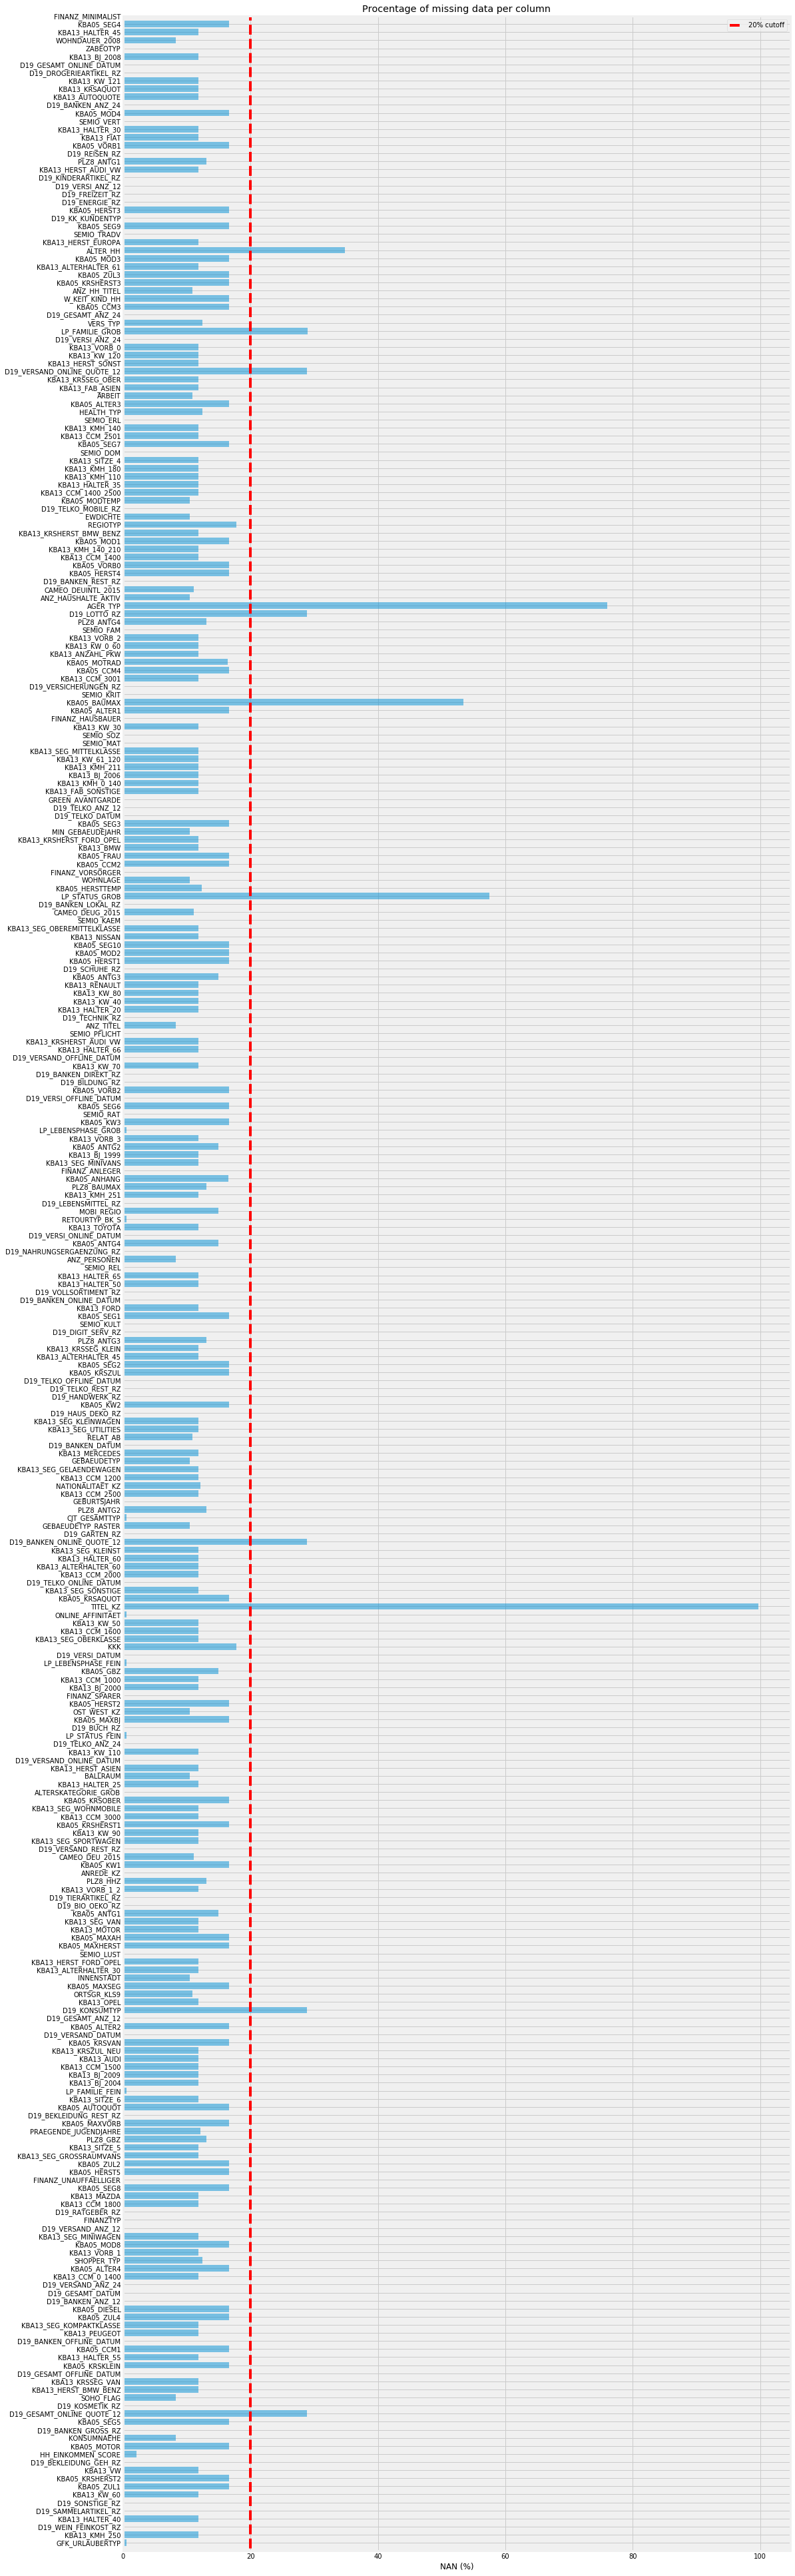

In [60]:
# Investigate patterns in the amount of missing data in each column.

plt.figure(figsize=(16,70))

y_pos = np.arange(len(col_names_a))
plt.barh(y_pos, nan_values_poc_a, align='center', alpha=0.5)
# visually show which features have more than 20% of missing data
plt.plot([20, 20],[-5, 400],"r--", label="20% cutoff")
plt.ylim(-1,85)
plt.yticks(y_pos, col_names_a)
plt.xlabel('NAN (%)')
plt.title('Procentage of missing data per column')
 
plt.legend()
plt.show()

In [61]:
# count columns with missing values above 20%
_ = nan_values_poc_a[nan_values_poc_a>=20].shape[0]
print(f'There are {_} columns with more than 20% missing values')

There are 11 columns with more than 20% missing values


In [62]:
# Remove the outlier columns from the dataset. 

def remove_nan_collumns(df, limit= 0.2):
    """
    Input:
        limit: float, ratio 
    Output:
        Returns a new dataframe without columns which had more than limit missing data
    """

    no_of_rows = df.shape[0]

    for col_name in df.columns.values:
        # count how many missing values in collumn
        no_of_missing_values = df[col_name].isnull().sum()
        if no_of_missing_values > no_of_rows * limit:
            df = df.drop([col_name], axis=1)
            miss_proc = (no_of_missing_values / no_of_rows) * 100
            print("{:30s} attribute removed, {:.2f} % of data was missing".format(col_name, miss_proc))
            
    return df

In [63]:
%%time
_ = azdias_3.shape
print(f"Before removing columns with missing data Dataframe shape={_} \n")
azdias_4 = remove_nan_collumns(azdias_3)
_ = azdias_4.shape
print(f"\n After removing columns with missing data Dataframe shape={_}")

Before removing columns with missing data Dataframe shape=(891221, 314) 

D19_GESAMT_ONLINE_QUOTE_12     attribute removed, 28.85 % of data was missing
D19_KONSUMTYP                  attribute removed, 28.85 % of data was missing
TITEL_KZ                       attribute removed, 99.76 % of data was missing
D19_BANKEN_ONLINE_QUOTE_12     attribute removed, 28.85 % of data was missing
LP_STATUS_GROB                 attribute removed, 57.53 % of data was missing
KBA05_BAUMAX                   attribute removed, 53.47 % of data was missing
D19_LOTTO_RZ                   attribute removed, 28.85 % of data was missing
AGER_TYP                       attribute removed, 76.02 % of data was missing
D19_VERSAND_ONLINE_QUOTE_12    attribute removed, 28.85 % of data was missing
LP_FAMILIE_GROB                attribute removed, 29.00 % of data was missing
ALTER_HH                       attribute removed, 34.81 % of data was missing

 After removing columns with missing data Dataframe shape=(891221, 

In [64]:
nan_sum = azdias_4.isnull().sum().values 

print("{:.2f} % of all data is still missing".format(100*np.sum(nan_sum) / (azdias_4.shape[0] * azdias_4.shape[1])))

9.13 % of all data is still missing


#### 0.4.2 Investigate missing data in each row

In [65]:
%%time

# create new column which counts how much data is per each row.
# This column will allow us to apply filters on our dataframe
azdias_4["data_count_per_row"] = azdias_4.apply(lambda x: x.count(), axis=1)

Wall time: 2min 4s


In [66]:
# Calculate % of missing data per row (divide number of missing data per round by number of columns)
azdias_4["data_count_per_row"] = azdias_4["data_count_per_row"]/azdias_4.shape[1]*100

In [67]:
# range between rows with largest and smallest number of available data (%)
print(azdias_4["data_count_per_row"].max()-azdias_4["data_count_per_row"].min())

70.06578947368422


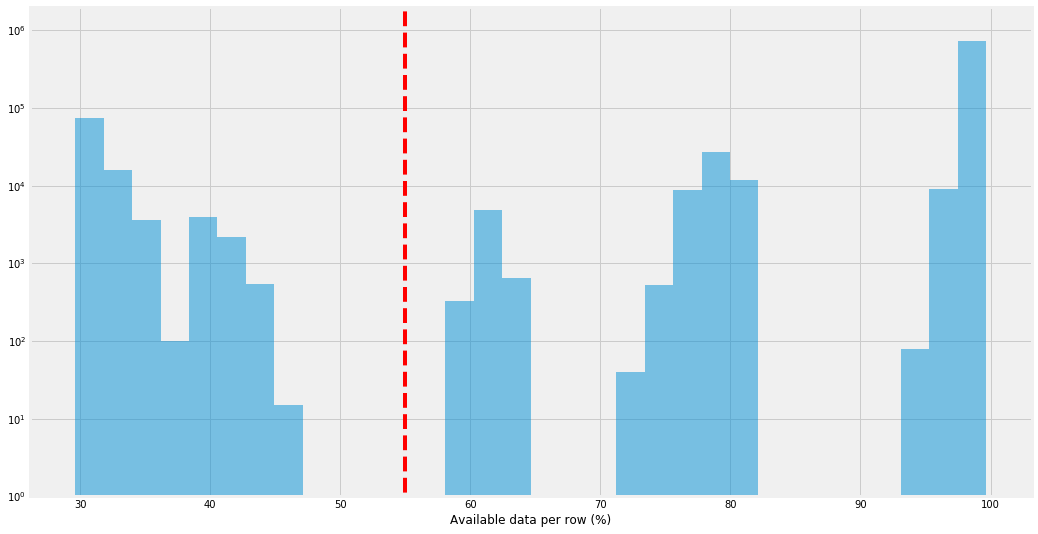

In [68]:
plt.figure(figsize=(16,9))
azdias_4["data_count_per_row"].hist(bins=32, log=True, alpha=0.5);
plt.xlabel("Available data per row (%)");
plt.plot([55, 55],[0, 2e6],"r--");
plt.ylim(1, 2e6);

In [69]:
# drop rows with more less than 55% of data available, i.e. filter out rows with more than 55% available data
azdias_5 = azdias_4[azdias_4["data_count_per_row"] > 55]

# delete "data_count_per_row" column (it messes up all missing data calculations)
del azdias_5["data_count_per_row"]

# reset index
azdias_5 = azdias_5.reset_index(drop=True)

In [70]:
nan_sum = azdias_5.isnull().sum().values 
nan_ratio = 100*np.sum(nan_sum) / (azdias_5.shape[0] * azdias_5.shape[1])

print("{:.2f} % of all remaining data is missing".format(nan_ratio))

1.72 % of all remaining data is missing


In [71]:
# how many rows (%) were droped?
print((azdias_4.shape[0] - azdias_5.shape[0])/azdias_5.shape[0]*100)

12.635419668269208


#### 0.4.3 Do same procedures on `customers` DataFrame

In [72]:
%%time
# get column name array
col_names_c = customers_3.columns.values
# count NAN values in each collumn
nan_values_c = customers_3.isnull().sum().values
# count procentage of each nan value
nan_values_poc_c = nan_values_c / customers_3.shape[0] * 100

Wall time: 4.62 s


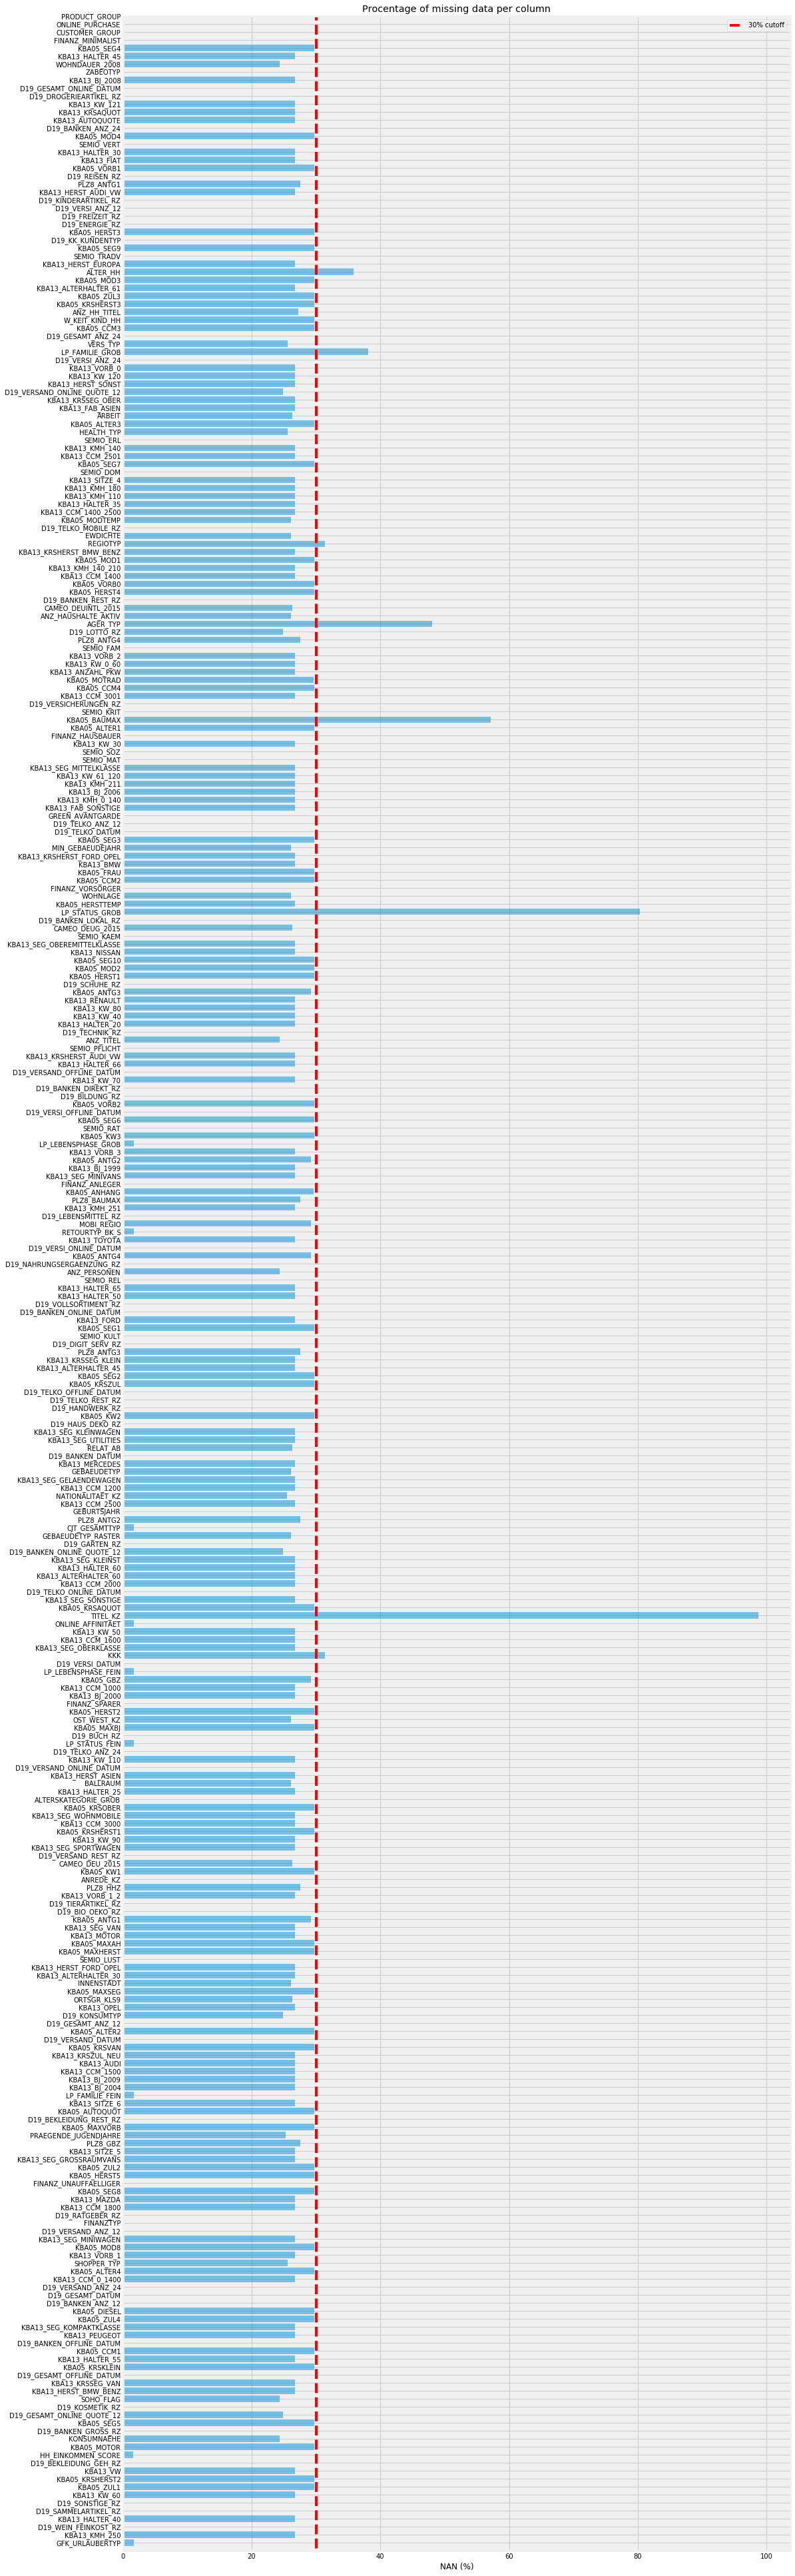

In [73]:
# Investigate patterns in the amount of missing data in each column.

plt.figure(figsize=(16,70))

y_pos = np.arange(len(col_names_c))
plt.barh(y_pos, nan_values_poc_c, align='center', alpha=0.5)
# visually show which features have more than 20% of missing data
plt.plot([30,30],[-5, 400],"r--", label="30% cutoff")
plt.ylim(-1,85)
plt.yticks(y_pos, col_names_c)
plt.xlabel('NAN (%)')
plt.title('Procentage of missing data per column')
 
plt.legend()
plt.show()

In [74]:
# count columns with missing vlaues above 20%
_ = nan_values_poc_c[nan_values_poc_c>30].shape[0]
print(f'There are {_} columns with more than 30% missing values')

There are 8 columns with more than 30% missing values


Larger cutoff range was used for `customers` DataFrame (30% instead of 20%), because from visual inspections it looks like there is number of users which are missing information in same columns. I will fix them by removing rows instead of columns. 

In [75]:
%%time
_ = customers_3.shape
print(f"Before removing columns with missing data Dataframe shape={_} \n")
customers_4 = remove_nan_collumns(customers_3, limit= 0.3)
_ = customers_4.shape
print(f"\n After removing columns with missing data Dataframe shape={_}")

Before removing columns with missing data Dataframe shape=(191652, 317) 

KKK                            attribute removed, 31.34 % of data was missing
TITEL_KZ                       attribute removed, 98.79 % of data was missing
LP_STATUS_GROB                 attribute removed, 80.30 % of data was missing
KBA05_BAUMAX                   attribute removed, 57.15 % of data was missing
AGER_TYP                       attribute removed, 48.06 % of data was missing
REGIOTYP                       attribute removed, 31.34 % of data was missing
LP_FAMILIE_GROB                attribute removed, 38.08 % of data was missing
ALTER_HH                       attribute removed, 35.87 % of data was missing

 After removing columns with missing data Dataframe shape=(191652, 309)
Wall time: 5.34 s


In [76]:
# create new column which counts how much data is per each row.
# This column will allow us to apply filters on our dataframe
customers_4["data_count_per_row"] = customers_4.apply(lambda x: x.count(), axis=1)
# Calculate % of missing data per row (divide number of missing data per round by number of columns)
customers_4["data_count_per_row"] = customers_4["data_count_per_row"]/customers_4.shape[1]*100

In [77]:
print(customers_4["data_count_per_row"].max()-customers_4["data_count_per_row"].min())

68.38709677419355


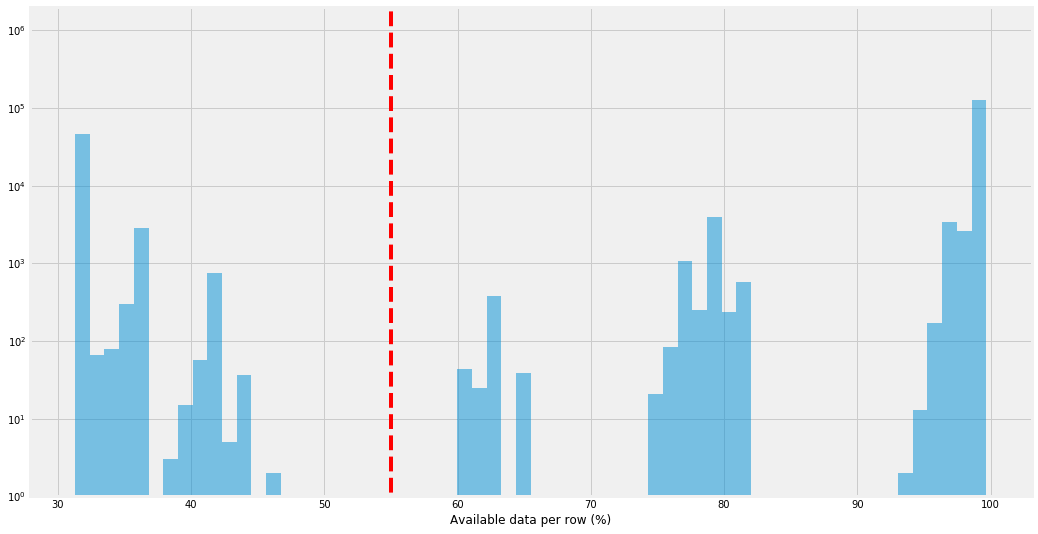

In [78]:
plt.figure(figsize=(16,9))
customers_4["data_count_per_row"].hist(bins=62, log=True, alpha=0.5);
plt.xlabel("Available data per row (%)");
plt.plot([55, 55],[0, 2e6],"r--");
plt.ylim(1, 2e6);

In [79]:
# drop rows with more less than 55% of data available, i.e. filter out rows with more than 55% available data
customers_5 = customers_4[customers_4["data_count_per_row"] > 55]

# delete "data_count_per_row" column (it messes up all missing data calculations)
del customers_5["data_count_per_row"]

# reset index
customers_5 = customers_5.reset_index(drop=True)

In [80]:
# how many rows (%) were droped?
print((customers_4.shape[0] - customers_5.shape[0])/customers_5.shape[0]*100)

36.05463425715584


In [81]:
nan_sum = customers_5.isnull().sum().values 

print("{:.2f} % of all data is missing".format(100*np.sum(nan_sum) / (customers_5.shape[0] * customers_5.shape[1])))

1.15 % of all data is missing


In [82]:
# calculate how much intial Data was droped after removing missing values
# for azdias DataFrame
size_a_before = azdias.shape[0] * azdias.shape[1]
size_a_after = azdias_5.shape[0] * azdias_5.shape[1]
data_droped_a = 100 - size_a_after/size_a_before*100

print(f"{data_droped_a:.2f}% of initial azdias data was droped")


# for customer DataFrame
size_c_before = customers.shape[0] * customers.shape[1]
size_c_after = customers_5.shape[0] * customers_5.shape[1]
data_droped_c = 100 - size_c_after/size_c_before*100

print(f"{data_droped_c:.2f}% of initial customers data was droped")

26.50% of initial azdias data was droped
38.45% of initial customers data was droped


### 0.5 Encode data

Before proceding, identify columns which are unique to `azdias` and `customers` DataFrames.

In [83]:
azdias_col_names = set(azdias_5.columns)
customers_col_names = set(customers_5.columns)

In [84]:
print('columns found in customers DataFrame but not in azdias DataFrame')
customers_col_names.difference(azdias_col_names)

columns found in customers DataFrame but not in azdias DataFrame


{'CUSTOMER_GROUP',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LOTTO_RZ',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'ONLINE_PURCHASE',
 'PRODUCT_GROUP'}

In [85]:
print('columns found in azdias DataFrame but not in customers DataFrame')
azdias_col_names.difference(customers_col_names)

columns found in azdias DataFrame but not in customers DataFrame


{'KKK', 'REGIOTYP'}

In [86]:
# get same columns names (column names present in both DataFrames)
same_cols = list(azdias_col_names.intersection(customers_col_names))

# create new DataFrames
azdias_6 = azdias_5.loc[:, same_cols]
customers_6 = customers_5.loc[:, same_cols]

#### 0.5.1 numeric data

Let's first identify which columns contain numeric data. For this let's how many meanings each attribute contains. While iterating of meanings, check if meanings list contains words **"numeric value"**.

In [87]:
# create empty lists to store whatever data is numeric, 1==True, 0==False
_data_1 = list()
# create empty list to store number of data meaings
_data_2 = list()

for _ in df_attr_p.Meanings:
    # if meanings value is not not, then it is list
    if isinstance(_, list):
        # assume that column is not numeric
        numeric = 0
        # iterate over meanings list and check whatever string "numeric" is present
        for i in _:
            if i is np.nan:
                pass
            elif "numeric" in i:
                numeric = 1
                break
        _data_1.append(numeric)
        # count unique values
        _data_2.append(len(_))
    else:
        _data_1.append(0)
        _data_2.append(0)
        
df_attr_p["numeric_value"] = pd.Series(_data_1)
df_attr_p["no_of_meanings"] = pd.Series(_data_2)

print(f'max number of unique meanings {df_attr_p.no_of_meanings.max()}')

max number of unique meanings 44


In [88]:
# find all numeric columns
numeric_col_names = list(df_attr_p[df_attr_p.numeric_value == 1].Attribute.values)
df_attr_p[df_attr_p.numeric_value == 1]

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations,dtype,numeric_value,no_of_meanings
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,[…],[numeric value (typically coded from 1-10)],Building,number of households known in this building,NaN,[],float64,1,1
5,ANZ_HH_TITEL,number of academic title holder in building,[…],[numeric value (typically coded from 1-10)],NaN,number of holders of an academic title in the ...,NaN,[],float64,1,1
6,ANZ_PERSONEN,number of adult persons in the household,[…],[numeric value (typically coded from 1-3)],NaN,number of persons known in this household,NaN,[],float64,1,1
7,ANZ_TITEL,number of professional title holder in household,[…],[numeric value (typically coded from 1-10)],NaN,number of bearers of an academic title within ...,NaN,[],float64,1,1
84,GEBURTSJAHR,year of birth,[…],[numeric value],NaN,year of birth,NaN,[],int64,1,1
159,KBA13_ANZAHL_PKW,number of cars in the PLZ8,[…],[numeric value],NaN,number of cars in the PLZ8,NaN,[],float64,1,1
271,MIN_GEBAEUDEJAHR,year the building was first mentioned in our d...,[…],[numeric value],NaN,year the building was first mentioned in our d...,NaN,[],float64,1,1


In [89]:
# save attr DataFrame for future use
# df_attr_p.to_csv('info_attributes_processed.csv', sep=',')

#### 0.5.2 encode binary categorical data

My definition of binary categorical data is object is either True or False. To find these type of columns, I will search through column meanings in `df_attr` DataFrame. Because meanings lists can also contain words "unknow", "none", following 4 cases could be used to find binary categorical data.

In [90]:
df_attr_p[df_attr_p.no_of_meanings == 0]

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations,dtype,numeric_value,no_of_meanings
310,D19_VERSI_OFFLINE_DATUM,NaN,[],[],NaN,actuality of the last transaction for the segm...,NaN,[],int64,0,0
311,D19_VERSI_ONLINE_DATUM,NaN,[],[],NaN,actuality of the last transaction for the segm...,NaN,[],int64,0,0
312,D19_VERSI_DATUM,NaN,[],[],NaN,actuality of the last transaction for the segm...,NaN,[],int64,0,0
313,ARBEIT,NaN,[],[],Community,share of unemployed person in the community,NaN,[],float64,0,0


These features are numeric with multiple values. They will be processed later.

In [91]:
df_attr_p[df_attr_p.no_of_meanings == 1]

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations,dtype,numeric_value,no_of_meanings
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,[…],[numeric value (typically coded from 1-10)],Building,number of households known in this building,NaN,[],float64,1,1
5,ANZ_HH_TITEL,number of academic title holder in building,[…],[numeric value (typically coded from 1-10)],NaN,number of holders of an academic title in the ...,NaN,[],float64,1,1
6,ANZ_PERSONEN,number of adult persons in the household,[…],[numeric value (typically coded from 1-3)],NaN,number of persons known in this household,NaN,[],float64,1,1
7,ANZ_TITEL,number of professional title holder in household,[…],[numeric value (typically coded from 1-10)],NaN,number of bearers of an academic title within ...,NaN,[],float64,1,1
84,GEBURTSJAHR,year of birth,[…],[numeric value],NaN,year of birth,NaN,[],int64,1,1
159,KBA13_ANZAHL_PKW,number of cars in the PLZ8,[…],[numeric value],NaN,number of cars in the PLZ8,NaN,[],float64,1,1
271,MIN_GEBAEUDEJAHR,year the building was first mentioned in our d...,[…],[numeric value],NaN,year the building was first mentioned in our d...,NaN,[],float64,1,1


All these columns contain only numeric data.

In [92]:
df_attr_p[df_attr_p.no_of_meanings == 2]

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations,dtype,numeric_value,no_of_meanings
86,GREEN_AVANTGARDE,Green avantgarde,"[0, 1]","[doesn't belong to the green avantgarde, belon...",NaN,the environmental sustainability is the domina...,own typology based on modelled on different AZ...,[],int64,0,2


In [93]:
# 'GREEN_AVANTGARDE' column contains binary categorical data
for col in df_attr_p[df_attr_p.no_of_meanings == 2].Attribute:
    print(f"{col} column has unique {azdias_6[col].unique()} values")

GREEN_AVANTGARDE column has unique [0 1] values


In [94]:
# add `` to binary_categorical_col names
binary_categorical_col_names = list()
binary_categorical_col_names.append('GREEN_AVANTGARDE')

No additional data processing is needed.

In [95]:
df_attr_p[df_attr_p.no_of_meanings == 3]

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations,dtype,numeric_value,no_of_meanings
3,ANREDE_KZ,gender,"[-1, 0, 1, 2]","[unknown, male, female]",NaN,gender,NaN,"[-1, 0]",int64,0,3
144,KBA05_SEG6,share of upper class cars (BMW 7er etc.) in th...,"[-1, 9, 0, 1]","[unknown, none, some]",NaN,share of upper class cars (BMW 7er etc.) in th...,NaN,"[-1, 9]",float64,0,3
276,OST_WEST_KZ,flag indicating the former GDR/FRG,"[-1, O, W]","[unknown, East (GDR), West (FRG)]",NaN,flag indicating the former GDR/FRG,NaN,[-1],object,0,3
303,SOHO_FLAG,small office/home office flag,"[-1, 0, 1]","[unknown, no small office/home office, small o...",NaN,small office/home office flag,NaN,[-1],float64,0,3
305,VERS_TYP,insurance typology,"[-1, 1, 2]","[unknown, social-safety driven, individualisti...",NaN,insurance typology,in cooperation with TNS Infratest,[-1],int64,0,3


In [96]:
# investigate unique values in each column
for col in df_attr_p[df_attr_p.no_of_meanings == 3].Attribute:
    print(f"{col:15s} column has unique {azdias_6[col].unique()} values")

ANREDE_KZ       column has unique [2 1] values
KBA05_SEG6      column has unique [ 1.  0. nan] values
OST_WEST_KZ     column has unique ['W' 'O'] values
SOHO_FLAG       column has unique [1. 0.] values
VERS_TYP        column has unique [ 2.  1. nan] values


Unique values need to be renamed to have numeric 0 or 1 expressions.

In [97]:
# rename 2's with zeros, to have binary encoded data
azdias_6.loc[:, "ANREDE_KZ"] = azdias_6["ANREDE_KZ"].replace({2: 0})
azdias_6.loc[:, "VERS_TYP"] = azdias_6["VERS_TYP"].replace({2: 0})
# rename west 'W' with 0 and east 'O' with 1
azdias_6.loc[:, "OST_WEST_KZ"] = azdias_6["OST_WEST_KZ"].replace({'W': 0, 'O': 1})

In [98]:
# make same procedures with customers dataframe
customers_6.loc[:, "ANREDE_KZ"] = customers_6["ANREDE_KZ"].replace({2: 0})
customers_6.loc[:, "VERS_TYP"] = customers_6["VERS_TYP"].replace({2: 0})
customers_6.loc[:, "OST_WEST_KZ"] = customers_6["OST_WEST_KZ"].replace({'W': 0, 'O': 1})

In [99]:
# investigate unique values in each column
for col in df_attr_p[df_attr_p.no_of_meanings == 3].Attribute:
    print(f"{col:15s} column has unique {azdias_6[col].unique()} values")
    # add col_names
    binary_categorical_col_names.append(col)

ANREDE_KZ       column has unique [0 1] values
KBA05_SEG6      column has unique [ 1.  0. nan] values
OST_WEST_KZ     column has unique [0 1] values
SOHO_FLAG       column has unique [1. 0.] values
VERS_TYP        column has unique [ 0.  1. nan] values


In [100]:
# all binary categorical columns
binary_categorical_col_names

['GREEN_AVANTGARDE',
 'ANREDE_KZ',
 'KBA05_SEG6',
 'OST_WEST_KZ',
 'SOHO_FLAG',
 'VERS_TYP']

#### 0.5.3 check for columns with "rough" and "detailed" scales

From previous project "Unsupervised Learning" I remmeber that `azdias` DataFrame contailed dublicate data, i.e. same information provided in rough or detailed scales. In cells bellow I identified these columns in both DataFrames.

In [101]:
for col in azdias_6.columns:
    if col[-5:] == "_FEIN" or col[-5:] == "_GROB":
        print(col)

LP_FAMILIE_FEIN
ALTERSKATEGORIE_GROB
LP_STATUS_FEIN
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB


In [102]:
for col in customers_6.columns:
    if col[-5:] == "_FEIN" or col[-5:] == "_GROB":
        print(col)

LP_FAMILIE_FEIN
ALTERSKATEGORIE_GROB
LP_STATUS_FEIN
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB


In [103]:
print("LP_LEBENSPHASE_FEIN has {:.2f} % missing data in azdias DataFrame".format(azdias_6.LP_LEBENSPHASE_FEIN.isnull().sum() / azdias_6.shape[0] * 100))
print("LP_LEBENSPHASE_GROB has {:.2f} % missing data in azdias DataFrame".format(azdias_6.LP_LEBENSPHASE_GROB.isnull().sum() / azdias_6.shape[0] * 100))

LP_LEBENSPHASE_FEIN has 0.59 % missing data in azdias DataFrame
LP_LEBENSPHASE_GROB has 0.59 % missing data in azdias DataFrame


In [104]:
print("LP_LEBENSPHASE_FEIN has {:.2f} % missing data in customers DataFrame".format(customers_6.LP_LEBENSPHASE_FEIN.isnull().sum() / customers_6.shape[0] * 100))
print("LP_LEBENSPHASE_GROB has {:.2f} % missing data in customers DataFrame".format(customers_6.LP_LEBENSPHASE_GROB.isnull().sum() / customers_6.shape[0] * 100))

LP_LEBENSPHASE_FEIN has 2.21 % missing data in customers DataFrame
LP_LEBENSPHASE_GROB has 2.21 % missing data in customers DataFrame


Only `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` had duplicate entires. It seems that rows contain equal information about both attributes, therefore I decided to drop rough scale `LP_LEBENSPHASE_GROB ` column.

In [105]:
azdias_6 = azdias_6.drop(["LP_LEBENSPHASE_GROB"], axis=1)
customers_6 = customers_6.drop(["LP_LEBENSPHASE_GROB"], axis=1)

#### `CAMEO_DEU_2015` quick fix.

I found this accidently by checking which columns have more meanings than maximum number of meanings. Out of 4 columns, 3 were numeric and `CAMEO_DEU_2015` after additional investigation, I found that 'XX' should be renamed with NAN.

In [106]:
max_no_of_meanings = df_attr_p.no_of_meanings.max()

for col in azdias_6.columns:
    # count unqiue values
    _data.append(azdias_6[col].nunique())
    if azdias_6[col].nunique() > max_no_of_meanings:
        print(col)

CAMEO_DEU_2015
GEBURTSJAHR
KBA13_ANZAHL_PKW
ANZ_HAUSHALTE_AKTIV


In [107]:
azdias_6["CAMEO_DEU_2015"].unique()

array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
       '8B', '7A', '5D', '9E', '9B', '1B', '3D', nan, '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

It seems that column `CAMEO_DEU_2015` contains missing values marked as 'XX'. It is safe to say, that it needs to be replaced with NAN value.

In [108]:
# rename "XX" with np.nan
azdias_6["CAMEO_DEU_2015"] = azdias_6["CAMEO_DEU_2015"].replace("XX", np.nan)
customers_6["CAMEO_DEU_2015"] = customers_6["CAMEO_DEU_2015"].replace("XX", np.nan)

In [109]:
azdias_6["CAMEO_DEU_2015"].unique()

array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
       '8B', '7A', '5D', '9E', '9B', '1B', '3D', nan, '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

#### `CAMEO_DEUINTL_2015` quick fix.

I also found that contains some missing values enotated with 'XX'.

In [110]:
azdias_6["CAMEO_DEUINTL_2015"].unique() 

array(['51.0', '24.0', '12.0', '43.0', '54.0', '22.0', '14.0', '13.0',
       '15.0', '33.0', '41.0', '34.0', '55.0', '25.0', nan, '23.0',
       '31.0', '52.0', '35.0', '45.0', '44.0', '32.0', '22', '24', '41',
       '12', '54', '51', '44', '35', '23', '25', '14', '34', '52', '55',
       '31', '32', '15', '13', '43', '33', '45', 'XX'], dtype=object)

In [111]:
# rename "XX" with np.nan
azdias_6["CAMEO_DEUINTL_2015"] = azdias_6["CAMEO_DEUINTL_2015"].replace("XX", np.nan)
customers_6["CAMEO_DEUINTL_2015"] = customers_6["CAMEO_DEUINTL_2015"].replace("XX", np.nan)

In [112]:
azdias_6["CAMEO_DEUINTL_2015"].unique() 

array(['51.0', '24.0', '12.0', '43.0', '54.0', '22.0', '14.0', '13.0',
       '15.0', '33.0', '41.0', '34.0', '55.0', '25.0', nan, '23.0',
       '31.0', '52.0', '35.0', '45.0', '44.0', '32.0', '22', '24', '41',
       '12', '54', '51', '44', '35', '23', '25', '14', '34', '52', '55',
       '31', '32', '15', '13', '43', '33', '45'], dtype=object)

It seems that some values are notated as strings while others as floats. These numbers should be normalized.

In [113]:
azdias_6["CAMEO_DEUINTL_2015"] = azdias_6["CAMEO_DEUINTL_2015"].astype('float')
customers_6["CAMEO_DEUINTL_2015"] = customers_6["CAMEO_DEUINTL_2015"].astype('float')
azdias_6["CAMEO_DEUINTL_2015"].unique() 

array([51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34., 55.,
       25., nan, 23., 31., 52., 35., 45., 44., 32.])

#### 0.5.4 Ordinal data

From previous *unsupervided learning* project **5** columns with mixed-type features were indentified. This means that all remaing features (excluding numeric, binary categorical and mixed-type features) should be categorical data or ordinal data. Before one-hot encoding categorical data, ordinal features needs to be identified.

* First I scanned all features meanings,
* Found examples of ordinal data, e.g. **['unknown', 'none', 'very low', 'low', 'average', 'high', 'very high']** or **['unknown', 'none', 'low share', 'average share', 'high share', 'very high share']**,
* Created new list `ordinal_sets` with all posible ordinal feature descriptions.

In [114]:
# mixed-type feature names (got from previous project)
mixed_col_names = ["PRAEGENDE_JUGENDJAHRE", "CAMEO_DEUINTL_2015", "LP_LEBENSPHASE_FEIN", "WOHNLAGE", "PLZ8_BAUMAX"]
# create DataFrame copies for one-hot encoding
azdias_7 = azdias_6.copy()
customers_7 = customers_6.copy()

In [115]:
# get NOT categorical data column names for azdias DataFrame
not_cat_col_names_a = numeric_col_names + binary_categorical_col_names + mixed_col_names
# get categorical data column names
cat_col_names_a = set(azdias_7.columns).difference(set(not_cat_col_names_a))

In [116]:
# how many categorical or ordinal features there are
print(f'there are {len(cat_col_names_a)} categorical or ordinal features left')

there are 282 categorical or ordinal features left


One needs to manually idenify which of the remainging features are categorical or ordinal data. For these reason 2 helper functions were created:

* `describe_attribute` prints out attribute name and unique values,
* `find_ordinal_attribute` finds ordinal atribute and prints it's unique values.

I manually iterated over all attributes and found lists of meanings which describe ordinal features. These lists were added to `ordinal_sets` set.

In [117]:
# create a list with all possible ordinal data meanings

ordinal_sets = [['unknown', 'none', 'very low', 'low', 'average', 'high', 'very high'],
               ['unknown', 'very high', 'high', 'average', 'low'],
               ['unknown', 'very low', 'low', 'average', 'high', 'very high'],
               ['unknown', 'none', 'low', 'average', 'high'],
               ['unknown', 'none', 'low share', 'average share', 'high share', 'very high share'],
               ['no transactions known', 'very low activity', 'low activity', 'slightly increased activity',
                'increased activity', 'high activity', 'very high activity'],
               ['unknown', 'none', 'very low', 'low', 'average', 'high'],
               ['unknown', 'very small engine', 'small engine', 'average engine', 'big engine'],
               ['unknown', 'highest affinity', 'very high affinity', 'high affinity', 'average affinity',
                'low affinity', 'very low affinity', 'lowest affinity'],
               ['unknown', 'no 3-5 family homes', 'lower share of 3-5 family homes',
                'average share of 3-5 family homes', 'high share of 3-5 family homes',
                'very high share of 3-5 family homes'],
               ['unknown', 'till 10 km', '10 - 20 km', '20 - 30 km', '30 - 40 km', '40 - 50 km', '50-100 km',
                'more than 100 km '],
               ['very high mobility', 'high mobility', 'middle mobility', 'low mobility', 'very low mobility ',
                'none'],
               ['unknown', 'highest income', 'very high income', 'high income', 'average income', 'lower income',
                'very low income'],
               ['unknown', 'way below average', 'below average', 'average', 'above average', 'way above average'],
               ['unknown', '< 30 years', '30 - 45 years', '46 - 60 years', '> 60 years', 'uniformly distributed'],
               ['unknown', 'no preowner', '1 preowner', '2 or more preowner'],
               ['unknown', 'none', 'some', 'some more', 'very many'],
               ['unknown', 'none', 'low', 'average', 'high', 'very high'],
               ['unknown', 'before 1994', '1994 - 1997', '1998 - 2000', 'since 2001'],
               ['unknown', 'small car', 'lower middleclass car', 'middle class car', 'upper class car'],
               ['unknown', 'below average', 'average', 'above average'],
               ['unknown', 'less than 130 households', '131-299 households', '300-599 households',
                '600-849 households', 'more than 849 households'],
               ['unknown', 'below 30 years', '30 - 40 years', '40 - 50 years', '50 - 60 years',
                'elder than 60 years'],
               ['unknown', 'no 6-10 family homes', 'lower share of 6-10 family homes',
                'average share of 6-10 family homes', 'high share of 6-10 family homes'],
               ['unknown', 'less than 34 HH/km²', '34 - 89 HH/km²', '90 - 149 HH/km²',
                '150 - 319 HH/km²', '320 - 999 HH/km²', 'more than 999 HH/²'],
               ['unknown', 'less than 60 buildings', '60-129 buildings', '130-299 buildings',
                '300-449 buildings', 'more than 449 buildings'],
               ['unknown', 'none', 'mainly small engines', 'mainly medium sized engines', 'mainly high engines',
                'mainly very big engines'],
               ['very low car quote', 'low car quote', 'average car quote', 'high car quote', 'very high car quote',
                'unknown'],
               ['unknown', 'most likely', 'very likely', 'likely', 'average', 'unlikely', 'very unlikely'],
               ['unknown', 'no >10 family homes', 'lower share of >10 family homes', 'high share of >10 family homes'],
               ['unknown', 'none', 'low share', 'high share'],
               ['unknown', '1-2 buildings', '3-4 buildings', '5-16 buildings', '17-22 buildings', '>=23 buildings'],
               ['unknown', 'none', 'low share', 'average share', 'high share'],
               ['unknown', 'length of residence below 1 year', 'length of residence 1-2 years',
                'length of residence 2-3 years', 'length of residence 3-4 years',
                'length of residence 4-5 years', 'length of residence 5-6 years',
                'length of residence 6-7 years', 'length of residence 7-10 years',
                'length of residence more than 10 years'],
               ['unknown', 'none', 'very low', 'low', 'average', 'high', 'very high'],
               ['none', 'low', 'middle', 'high', 'very high', 'highest  '],
               ['unknown', '<= 2.000 inhabitants', '2.001 to 5.000 inhabitants', '5.001 to 10.000 inhabitants',
                '10.001 to 20.000 inhabitants', '20.001 to 50.000 inhabitants', '50.001 to 100.000 inhabitants',
                '100.001 to 300.000 inhabitants', '300.001 to 700.000 inhabitants', '> 700.000  inhabitants'],
               ['unknown', 'city centre', 'distance to the city centre 3 km', 'distance to the city centre 3-5 km',
                'distance to the city centre 5-10 km', 'distance to the city centre 10-20 km',
                'distance to the city centre 20-30 km', 'distance to the city centre 30-40 km',
                'distance to the city centre > 40 km']]

# convert lists to sets
ordinal_sets = [set(_) for _ in ordinal_sets]

In [118]:
# Helper function to print out column/feature descrition

def describe_attribute(df, df_attr, attr_name):
    """
    Input:
        df: pands DataFrame, either azdias or customers DataFrame
        df_attr: pandas DataFrame, containing information about attributes
        attr_name: str, attribute name
    Output:
        prints attribute description
    """
    # check if attribute is available
    try:
        description = df_attr[df_attr.Attribute == attr_name].Description_a.values[0]
        meanings = df_attr[df_attr.Attribute == attr_name].Meanings.values[0]
    except:
        description = "attribute not found in Attribute column"
        meanings = []
        
    # in .xlsx attribute DataFrame not all attributes had description. If it is NAN then check info DataFrame
    # description
    if description is np.nan:
        description = df_attr[df_attr.Attribute == attr_name].Description_i.values[0]
    print(f'{attr_name}: {description}')
    print(meanings)
    print(df[attr_name].unique())
    print(30*"-")
    
def find_ordinal_attribute(df, df_attr, attr_name, ordinal_col_names):
    """
    Input:
        df: pandas DataFrame, either azdias or customers DataFrame
        df_attr: pandas DataFrame, containing information about attributes
        attr_name: str, attribute name,
        ordinal_col_names: list, list with ordinal column names
    """
    global ordinal_sets
    
    # check if column name is in Attribute list
    if attr_name in df_attr.Attribute.unique():
        description = df_attr[df_attr.Attribute == attr_name].Description_a.values[0]
    else:
        print(f'{attr_name} column not found in df_attr DataFrame')
        return ordinal_col_names

    if description is np.nan:
        # in .xlsx attribute DataFrame not all attributes had description. If it is NAN then check info DataFrame
        # description
        description = df_attr[df_attr.Attribute == attr_name].Description_i.values[0]
    meanings = df_attr[df_attr.Attribute == attr_name].Meanings.values[0]

    if set(meanings) in ordinal_sets:
        ordinal_col_names.append(attr_name)
        
    return ordinal_col_names

In [119]:
# create empty list for ordinal column names
ordinal_col_names_a = list()

for cat_name in cat_col_names_a:
    ordinal_col_names_a = find_ordinal_attribute(azdias_7, df_attr_p, cat_name, ordinal_col_names_a)

In [120]:
# get NOT categorical data column names for azdias DataFrame
not_cat_col_names_a = numeric_col_names + binary_categorical_col_names + mixed_col_names + ordinal_col_names_a

# get categorical data column names
cat_col_names_a = set(azdias_7.columns).difference(set(not_cat_col_names_a))

print(f'there are {len(cat_col_names_a)} categorical features left')

there are 69 categorical features left


In [121]:
# check descriptions and unique values of remaining features 
for cat_name in cat_col_names_a:
    describe_attribute(azdias_7, df_attr_p, cat_name)

D19_VOLLSORTIMENT_RZ: transactional activity based on the product group COMPLETE MAIL-ORDER OFFERS
['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months', 'Prospects > 24 months']
[0 7 6 3 2 5 4 1]
------------------------------
GFK_URLAUBERTYP: vacation habits
['Event travelers', 'Family-oriented vacationists', 'Winter sportspeople', 'Culture lovers', 'Nature fans', 'Hiker', 'Golden ager', 'Homeland-connected vacationists ', 'Package tour travelers', 'Connoisseurs', 'Active families', 'without vacation']
[10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
------------------------------
D19_WEIN_FEINKOST_RZ: transactional activity based on the product group WINE AND GOURMET FOOD
['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 

D19_GESAMT_OFFLINE_DATUM: actuality of the last transaction with the complete file OFFLINE
['highest activity within the last 12 months', 'very high activity within the last 12 months', 'high activity within the last 12 months', 'increased activity within the last 12 months', 'slightly increased activity within the last 12 months', 'activity elder than 1 year', 'activity elder than 1,5 years', 'activity elder than 2 years', 'activity elder than 3 years', 'no transactions known']
[10  6  8  9  5  2  4  1  7  3]
------------------------------
D19_VERSI_OFFLINE_DATUM: actuality of the last transaction for the segment insurance OFFLINE
[]
[10  7  9  6  4  8  5  2  3  1]
------------------------------
D19_BILDUNG_RZ: transactional activity based on the product group EDUCATION
['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months', 'Prospects > 24 months']
[0 6

D19_BANKEN_DATUM: actuality of the last transaction for the segment banks TOTAL
['highest activity within the last 12 months', 'very high activity within the last 12 months', 'high activity within the last 12 months', 'increased activity within the last 12 months', 'slightly increased activity within the last 12 months', 'activity elder than 1 year', 'activity elder than 1,5 years', 'activity elder than 2 years', 'activity elder than 3 years', 'no transactions known']
[10  5  8  6  9  1  7  4  2  3]
------------------------------
D19_ENERGIE_RZ: transactional activity based on the product group ENERGY
['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months', 'Prospects > 24 months']
[0 5 3 6 7 2 1 4]
------------------------------
D19_FREIZEIT_RZ: transactional activity based on the product group LEISURE PRODUCTS
['no transaction known', 'Multibuyer 0-12 mo

Comments about some of the features:

* Some features looks like mixed-type features, e.g. `D19_SAMMELARTIKEL_RZ` had meanings ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months', 'Prospects > 24 months']. Enconding them individually ( customer type and time they had interaction) would not provide meaningful data.
* `REGIOTYP` looks like ordinal type feature (values: ['unknown', 'upper class', 'conservatives', 'upper middle class', 'middle class', 'lower middle class', 'traditional workers', 'marginal groups']). In my opinion, values like 'conservatives' and 'marginal groups' doesn't let position them among other values.


#### do same procedure for `customers` DataFrame

In [122]:
# get NOT categorical data column names for azdias DataFrame
not_cat_col_names_c = numeric_col_names + binary_categorical_col_names + mixed_col_names
# get categorical data column names
cat_col_names_c = set(customers_7.columns).difference(set(not_cat_col_names_c))

print(f'there are {len(cat_col_names_c)} categorical or ordinal features left')

there are 282 categorical or ordinal features left


In [123]:
# create empty list for ordinal column names
ordinal_col_names_c = list()

for cat_name in cat_col_names_c:
    ordinal_col_names_c = find_ordinal_attribute(customers_7, df_attr_p, cat_name, ordinal_col_names_c)

In [124]:
# get NOT categorical data column names for azdias DataFrame
not_cat_col_names_c = numeric_col_names + binary_categorical_col_names + mixed_col_names + ordinal_col_names_c

# get categorical data column names
cat_col_names_c = set(customers_7.columns).difference(set(not_cat_col_names_c))

print(f'there are {len(cat_col_names_c)} categorical features left')

there are 69 categorical features left


In [125]:
# for cat_name in cat_col_names_c:
#     describe_attribute(customers_7, df_attr_p, cat_name)

In [126]:
# get NOT categorical data column names for customers DataFrame
not_cat_col_names_c = numeric_col_names + binary_categorical_col_names + mixed_col_names + ordinal_col_names_c
# get categorical data column names for customers DataFrame
cat_col_names_c = set(customers_7.columns).difference(set(not_cat_col_names_c))

In [127]:
# create categorical DataFrames for azdias and customers DataFrames
azdias_cat = azdias_7[list(cat_col_names_a)]
customers_cat = customers_7[list(cat_col_names_c)]

#### 0.5.5 Categorical data one-hot encoding

DeataFrame `azdias_cat` and `customers_cat` contain only categorical columns. These columns in following cells will be one hot-encoded. During one hot encoding, missing data will also be encoded, i.e. it is assumed that missing values also contain information about user.

In [128]:
%%time

# create temporary copy of DataFrame with only categorical data
_df = azdias_cat.copy()

# iterate over columns
for _ in _df.columns:
    # one-one-hot encode the feature and add it to the dataframe
    _df = _df.join(pd.get_dummies(_df[_], prefix=_))
    # drop feature from data
    _df = _df.drop([_], axis=1)
    print("{:30s} feature one-hot-encoded".format(_))    

D19_VOLLSORTIMENT_RZ           feature one-hot-encoded
GFK_URLAUBERTYP                feature one-hot-encoded
D19_WEIN_FEINKOST_RZ           feature one-hot-encoded
D19_TIERARTIKEL_RZ             feature one-hot-encoded
D19_SONSTIGE_RZ                feature one-hot-encoded
D19_SAMMELARTIKEL_RZ           feature one-hot-encoded
D19_NAHRUNGSERGAENZUNG_RZ      feature one-hot-encoded
D19_VERSI_ONLINE_DATUM         feature one-hot-encoded
RETOURTYP_BK_S                 feature one-hot-encoded
D19_BANKEN_REST_RZ             feature one-hot-encoded
D19_LEBENSMITTEL_RZ            feature one-hot-encoded
CAMEO_DEU_2015                 feature one-hot-encoded
D19_VERSAND_REST_RZ            feature one-hot-encoded
D19_BEKLEIDUNG_GEH_RZ          feature one-hot-encoded
KONSUMNAEHE                    feature one-hot-encoded
D19_BANKEN_GROSS_RZ            feature one-hot-encoded
D19_KOSMETIK_RZ                feature one-hot-encoded
D19_TELKO_MOBILE_RZ            feature one-hot-encoded
KBA05_MODT

In [129]:
# join temporary DataFrame with azdias DataFrame
azdias_8 = azdias_7[list(not_cat_col_names_a)].join(_df)
print(azdias_7.shape)
print(azdias_8.shape)

(791244, 300)
(791244, 826)


Make same procedure for `customers` DataFrame.

In [130]:
%%time

# create temporary copy of DataFrame with only categorical data
_df = customers_cat.copy()

# iterate over columns
for _ in _df.columns:
    # one-one-hot encode the feature and add it to the dataframe
    _df = _df.join(pd.get_dummies(_df[_], prefix=_))
    # drop feature from data
    _df = _df.drop([_], axis=1)
    print("{:30s} feature one-hot-encoded".format(_))    

D19_VOLLSORTIMENT_RZ           feature one-hot-encoded
GFK_URLAUBERTYP                feature one-hot-encoded
D19_WEIN_FEINKOST_RZ           feature one-hot-encoded
D19_TIERARTIKEL_RZ             feature one-hot-encoded
D19_SONSTIGE_RZ                feature one-hot-encoded
D19_SAMMELARTIKEL_RZ           feature one-hot-encoded
D19_NAHRUNGSERGAENZUNG_RZ      feature one-hot-encoded
D19_VERSI_ONLINE_DATUM         feature one-hot-encoded
RETOURTYP_BK_S                 feature one-hot-encoded
D19_BANKEN_REST_RZ             feature one-hot-encoded
D19_LEBENSMITTEL_RZ            feature one-hot-encoded
CAMEO_DEU_2015                 feature one-hot-encoded
D19_VERSAND_REST_RZ            feature one-hot-encoded
D19_BEKLEIDUNG_GEH_RZ          feature one-hot-encoded
KONSUMNAEHE                    feature one-hot-encoded
D19_BANKEN_GROSS_RZ            feature one-hot-encoded
D19_KOSMETIK_RZ                feature one-hot-encoded
D19_TELKO_MOBILE_RZ            feature one-hot-encoded
KBA05_MODT

In [131]:
# join temporary DataFrame with azdias DataFrame
customers_8 = customers_7[list(not_cat_col_names_c)].join(_df)
print(customers_7.shape)
print(customers_8.shape)

(140864, 300)
(140864, 825)


Make sure that both DataFrames have same columns.

In [132]:
set_a = set(azdias_8.columns)
set_c = set(customers_8.columns)
set_a.difference(set_c)

{'GEBAEUDETYP_5.0'}

It seems like `customers` DataFrame did not have any 5 value for GEBAEUDETYP column. To fix this, GEBAEUDETYP_5.0 with zeros is added to `customers` DataFrame.

In [133]:
# add column with zeros
customers_8['GEBAEUDETYP_5.0'] = 0

set_a = set(azdias_8.columns)
set_c = set(customers_8.columns)
set_a.difference(set_c)

set()

#### 0.5.5 One-hot-encode mixed-type features

Last 5 columns with mixed type features will be manually processed (see cells below).

In [134]:
# create DataFrame copies for one-hot encoding
azdias_9 = azdias_8.copy()
customers_9 = customers_8.copy()

##### 0.5.5.1 `PRAEGENDE_JUGENDJAHRE`

`PRAEGENDE_JUGENDJAHRE` combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.

In [135]:
# investigate "PRAEGENDE_JUGENDJAHRE" mixed meanings

_values = df_attr_p[df_attr_p.Attribute == "PRAEGENDE_JUGENDJAHRE"].Values.values[0]
_meanings = df_attr_p[df_attr_p.Attribute == "PRAEGENDE_JUGENDJAHRE"].Meanings.values[0]

for _ in range(len(_meanings)):
    print(f"{_values[_]}: {_meanings[_]}")

-1, 0: unknown
1: 40ies - war years (Mainstream, O+W)
2: 40ies - reconstruction years (Avantgarde, O+W)
3: 50ies - economic miracle (Mainstream, O+W)
4: 50ies - milk bar / Individualisation (Avantgarde, O+W)
5: 60ies - economic miracle (Mainstream, O+W)
6: 60ies - generation 68 / student protestors (Avantgarde, W)
7: 60ies - opponents to the building of the Wall (Avantgarde, O)
8: 70ies - family orientation (Mainstream, O+W)
9: 70ies - peace movement (Avantgarde, O+W)
10: 80ies - Generation Golf (Mainstream, W)
11: 80ies - ecological awareness (Avantgarde, W)
12: 80ies - FDJ / communist party youth organisation (Mainstream, O)
13: 80ies - Swords into ploughshares (Avantgarde, O)
14: 90ies - digital media kids (Mainstream, O+W)
15: 90ies - ecological awareness (Avantgarde, O+W)


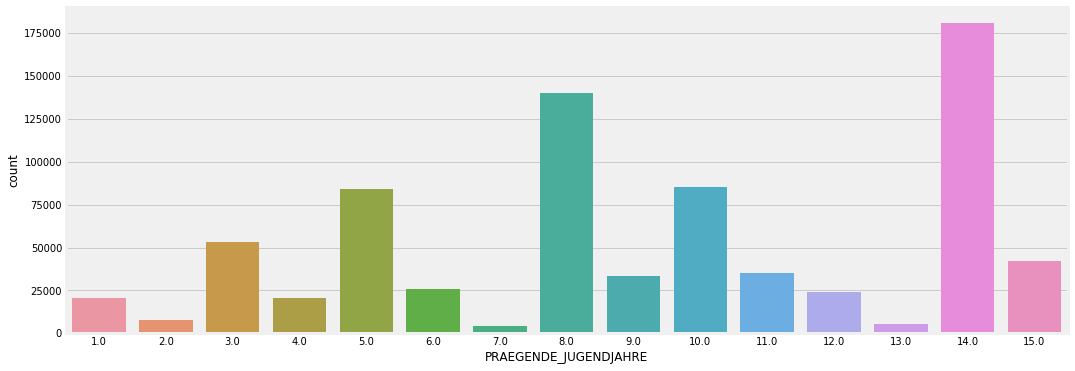

In [136]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables and visualize
plt.figure(figsize=(16, 6))
sns.countplot(x="PRAEGENDE_JUGENDJAHRE", data=azdias_9);

In [137]:
# replace NAN values with 0s, so that dictonary mapping could be used
# e.g. {np.nan: [np.nan, np.nan]} doesn't work.
azdias_9.PRAEGENDE_JUGENDJAHRE = azdias_9.PRAEGENDE_JUGENDJAHRE.fillna(0)
customers_9.PRAEGENDE_JUGENDJAHRE = customers_9.PRAEGENDE_JUGENDJAHRE.fillna(0)

# manual dictonary was created to encode diffent values to different collumn
PRAEGENDE_JUGENDJAHRE_dict = {
    0.0: [np.nan, np.nan],
    1.0: ["40s", 0],
    2.0: ["40s", 1],
    3.0: ["50s", 0],
    4.0: ["50s", 1],
    5.0: ["60s", 0],
    6.0: ["60s", 1],
    7.0: ["60s", 1],
    8.0: ["70s", 0],
    9.0: ["70s", 1],
    10.0: ["80s", 0],
    11.0: ["80s", 1],
    12.0: ["80s", 0],
    13.0: ["80s", 1],
    14.0: ["90s", 0],
    15.0: ["90s", 1]
}

In [138]:
%%time
# create new columns for decade and movement values
_ = azdias_9.PRAEGENDE_JUGENDJAHRE.apply(lambda s: pd.Series({
    'PRAEGENDE_JUGENDJAHRE_decade':PRAEGENDE_JUGENDJAHRE_dict[s][0],
    'PRAEGENDE_JUGENDJAHRE_movement':PRAEGENDE_JUGENDJAHRE_dict[s][1]}))

# add these columns to data frame
azdias_9 = azdias_9.merge(_, left_index=True, right_index=True)
# drop PRAEGENDE_JUGENDJAHRE column from dataframe
azdias_9 = azdias_9.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1)
# one-hot-encode decade data
azdias_9 = azdias_9.join(pd.get_dummies(azdias_9["PRAEGENDE_JUGENDJAHRE_decade"],
                                        prefix="PRAEGENDE_JUGENDJAHRE_decade"))
# drop "PRAEGENDE_JUGENDJAHRE_decade" column
azdias_9 = azdias_9.drop(["PRAEGENDE_JUGENDJAHRE_decade"], axis=1)

Wall time: 7min 56s


Apply same steps to `customers` DataFrame.

In [139]:
%%time
# create new columns for decade and movement values
_ = customers_9.PRAEGENDE_JUGENDJAHRE.apply(lambda s: pd.Series({
    'PRAEGENDE_JUGENDJAHRE_decade':PRAEGENDE_JUGENDJAHRE_dict[s][0],
    'PRAEGENDE_JUGENDJAHRE_movement':PRAEGENDE_JUGENDJAHRE_dict[s][1]}))

# add these columns to data frame
customers_9 = customers_9.merge(_, left_index=True, right_index=True)
# drop PRAEGENDE_JUGENDJAHRE column from dataframe
customers_9 = customers_9.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1)
# one-hot-encode decade data
customers_9 = customers_9.join(pd.get_dummies(customers_9["PRAEGENDE_JUGENDJAHRE_decade"],
                                              prefix="PRAEGENDE_JUGENDJAHRE_decade"))
# drop "PRAEGENDE_JUGENDJAHRE_decade" column
customers_9 = customers_9.drop(["PRAEGENDE_JUGENDJAHRE_decade"], axis=1)

Wall time: 1min 22s


##### 0.5.5.2 `CAMEO_DEUINTL_2015`

`CAMEO_DEUINTL_2015` combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values). 

**Quick comment**: in unsupervised learning project this feature was `CAMEO_INTL_2015`. In this project `CAMEO_INTL_2015` was renamed to `CAMEO_DEUINTL_2015` to match column notation in `.xlsx` files.

In [140]:
# investigate "CAMEO_DEUINTL_2015" mixed-type meanings

_values = df_attr_p[df_attr_p.Attribute == "CAMEO_DEUINTL_2015"].Values.values[0]
_meanings = df_attr_p[df_attr_p.Attribute == "CAMEO_DEUINTL_2015"].Meanings.values[0]

for _ in range(len(_meanings)):
    print(f"{_values[_]}: {_meanings[_]}")

-1: unknown
11: Wealthy Households-Pre-Family Couples & Singles
12: Wealthy Households-Young Couples With Children
13: Wealthy Households-Families With School Age Children
14: Wealthy Households-Older Families &  Mature Couples
15: Wealthy Households-Elders In Retirement
21: Prosperous Households-Pre-Family Couples & Singles
22: Prosperous Households-Young Couples With Children
23: Prosperous Households-Families With School Age Children
24: Prosperous Households-Older Families & Mature Couples
25: Prosperous Households-Elders In Retirement
31: Comfortable Households-Pre-Family Couples & Singles
32: Comfortable Households-Young Couples With Children
33: Comfortable Households-Families With School Age Children
34: Comfortable Households-Older Families & Mature Couples
35: Comfortable Households-Elders In Retirement
41: Less Affluent Households-Pre-Family Couples & Singles
42: Less Affluent Households-Young Couples With Children
43: Less Affluent Households-Families With School Age Childr

One can see that 10ths indicate wealth, while one's indicate family type:

* **1X** *Wealthy*, **2X** *Prosperous* and ect.
* **X1** *Households-Pre-Family Couples & Singles*, **X2** *Households-Young Couples With Children* and ect.

Information about wealth will be written using function:
```python
lambda x: x//10
```
, while information about famility type use:
```python
lambda x: x%10
```




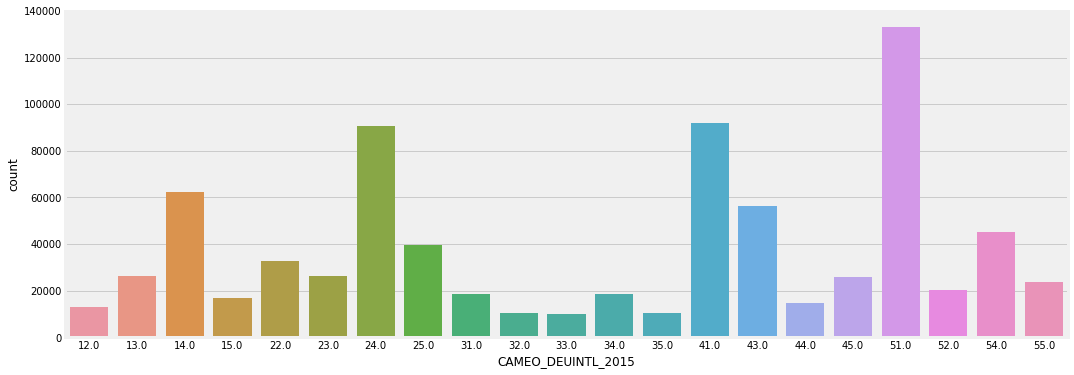

In [141]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables and visualize
plt.figure(figsize=(16, 6))
sns.countplot(x="CAMEO_DEUINTL_2015", data=azdias_9);

In [142]:
%%time

# create new collumns for decade and movement values
_ = azdias_9.CAMEO_DEUINTL_2015.apply(lambda s: pd.Series({
    'CAMEO_DEUINTL_2015_wealth':s//10,
    'CAMEO_DEUINTL_2015_lifestage':s%10}))
# add these collumns to data frame
azdias_9 = azdias_9.merge(_, left_index=True, right_index=True);
# drop CAMEO_INTL_2015 collumn from dataframe
azdias_9 = azdias_9.drop(["CAMEO_DEUINTL_2015"], axis=1)
# one-hot-encode wealth and lifestage data
azdias_9 = azdias_9.join(pd.get_dummies(azdias_9["CAMEO_DEUINTL_2015_wealth"],
                                        prefix="CAMEO_DEUINTL_2015_wealth"))
azdias_9 = azdias_9.join(pd.get_dummies(azdias_9["CAMEO_DEUINTL_2015_lifestage"],
                                        prefix="CAMEO_DEUINTL_2015_lifestage"))
# drop one-hot-encoded original collumns
azdias_9 = azdias_9.drop(["CAMEO_DEUINTL_2015_wealth"], axis=1)
azdias_9 = azdias_9.drop(["CAMEO_DEUINTL_2015_lifestage"], axis=1)

Wall time: 6min 56s


Apply same steps to `customers` DataFrame.

In [143]:
%%time

# create new collumns for decade and movement values
_ = customers_9.CAMEO_DEUINTL_2015.apply(lambda s: pd.Series({
    'CAMEO_DEUINTL_2015_wealth':s//10,
    'CAMEO_DEUINTL_2015_lifestage':s%10}))

# add these collumns to data frame
customers_9 = customers_9.merge(_, left_index=True, right_index=True)

# drop CAMEO_INTL_2015 collumn from dataframe
customers_9 = customers_9.drop(["CAMEO_DEUINTL_2015"], axis=1)

# one-hot-encode wealth and lifestage data
customers_9 = customers_9.join(pd.get_dummies(customers_9["CAMEO_DEUINTL_2015_wealth"],
                                              prefix="CAMEO_DEUINTL_2015_wealth"))
customers_9 = customers_9.join(pd.get_dummies(customers_9["CAMEO_DEUINTL_2015_lifestage"],
                                              prefix="CAMEO_DEUINTL_2015_lifestage"))

# drop one-hot-encoded original collumns
customers_9 = customers_9.drop(["CAMEO_DEUINTL_2015_wealth"], axis=1)
customers_9 = customers_9.drop(["CAMEO_DEUINTL_2015_lifestage"], axis=1)

Wall time: 1min 19s


##### 0.5.5.3 `LP_LEBENSPHASE_FEIN`

Provides information about life stage in fine scale (social unit type, earnings and age).

In [144]:
# investigate "LP_LEBENSPHASE_FEIN" mixed-type meanings

_values = df_attr_p[df_attr_p.Attribute == "LP_LEBENSPHASE_FEIN"].Values.values[0]
_meanings = df_attr_p[df_attr_p.Attribute == "LP_LEBENSPHASE_FEIN"].Meanings.values[0]

for _ in range(len(_meanings)):
    print(f"{_values[_]}: {_meanings[_]}")

1: single low-income earners of younger age
2: single low-income earners of middle age
3: single average earners of younger age 
4: single average earners of middle age
5: single low-income earners of advanced age
6: single low-income earners at retirement age 
7: single average earners of advanced age
8: single average earners at retirement age
9: single independant persons
10: wealthy single homeowners
11: single homeowners of advanced age
12: single homeowners at retirement age
13: single top earners of higher age 
14: low-income- and average earner-couples of younger age
15: low-income earner-couples of higher age
16: average earner-couples of higher age 
17: independant couples
18: wealthy homeowner-couples of younger age 
19: homeowner-couples of higher age
20: top earner-couples of higher age
21: single parent low-income earners
22: single parent average earners
23: single parent high-income earners
24: low-income earner-families
25: average earner-families 
26: independant fami

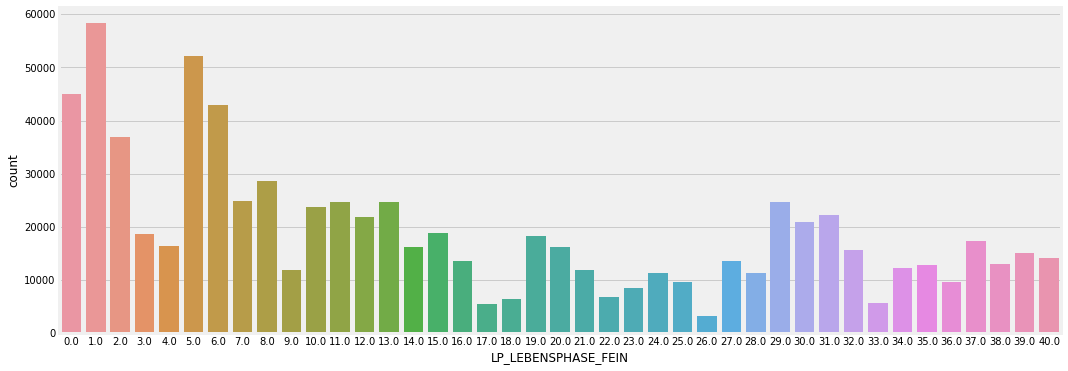

In [145]:
# Investigate "LP_LEBENSPHASE_FEIN" and engineer two new variables and visualize
plt.figure(figsize=(16, 6))
sns.countplot(x="LP_LEBENSPHASE_FEIN", data=azdias_9);

In [146]:
# replace NAN values with 0s, so that dictonary mapping could be used
# e.g. {np.nan: [np.nan, np.nan, np.nan]} doesn't work.
azdias_9.LP_LEBENSPHASE_FEIN = azdias_9.LP_LEBENSPHASE_FEIN.fillna(0)
customers_9.LP_LEBENSPHASE_FEIN = customers_9.LP_LEBENSPHASE_FEIN.fillna(0)

# create custom dictonary to encode: social unit type, earnings and age.
LP_LEBENSPHASE_FEIN_dict = {
    0.0: [np.nan, np.nan, np.nan],
    1.0: ["single", "low", "young"],
    2.0: ["single", "low", "middle"],
    3.0: ["single", "average", "young"],
    4.0: ["single", "average", "middle"],
    5.0: ["single", "low", "advanced"],
    6.0: ["single", "low", "retirement"],
    7.0: ["single", "average", "advanced"],
    8.0: ["single", "average", "retirement"],
    9.0: ['single', "unknow", "unknow"],
    10.0: ['single_home', 'high', "unknow"],
    11.0: ['single_home', "unknow", "advanced"],
    12.0: ['single_home', "unknow", "retirement"],
    13.0: ['single', 'high', "higher"],
    14.0: ["couple", 'average', 'young'],
    15.0: ["couple", "low", 'higher'],
    16.0: ['couple', "average", "higher"],
    17.0: ['couple', "unknow", "unknow"],
    18.0: ['couple', 'high', 'young'],
    19.0: ['couple', "unknow", "higher"],
    20.0: ['couple', 'high', "higher"],
    21.0: ['single_parent', 'low', "unknow"],
    22.0: ['single_parent', 'average', "unknow"],
    23.0: ['single_parent', 'high', "unknow"],
    24.0: ['family', 'low', "unknow"],
    25.0: ['family', 'average', "unknow"],
    26.0: ['family', "unknow", "unknow"],
    27.0: ['family', "unknow", "unknow"],
    28.0: ['family', 'high', "unknow"],
    29.0: ['multi', 'low', 'young'],
    30.0: ['multi', 'average', 'young'],
    31.0: ['multi', 'low', 'higher'],
    32.0: ['multi', 'average', 'higher'],
    33.0: ['multi', "unknow" , 'young'],
    34.0: ['multi', "unknow", 'young'],
    35.0: ['multi', 'high' , 'young'],
    36.0: ['multi', "unknow" , 'higher'],
    37.0: ['multi', "unknow" , 'advanced'],
    38.0: ['multi', "unknow" , 'retirement'],
    39.0: ['multi', 'high' , 'middle'],
    40.0: ['multi', 'high' , 'retirement']    
}

#### comments regarding interpretation of some of the features
* single independent person was encoded as single with unknown income and age.
* wealthy was interpreted as high income.
* independent couple were recorded as couple with unknown income and age.
* homeowner couples of higher age were recorded as couples with unknown income.
* top earner couples of higher age were recorder as couples with high income and higher age
* independent families, homeowner families were recorded as just families with unknow income and age
* independent persons of younger age from multiperson households and homeowners of younger age from multiperson households were recorded as multiperson household with unknown income and youg age.
* top earners of younger age from multiperson households were recorded as multiperson household with high income
* top earners of middle age from multiperson households were recorded as multiperson household with high income and midle age

In [147]:
%%time
# create new collumns for decade and movement values
_ = azdias_9.LP_LEBENSPHASE_FEIN.apply(lambda s: pd.Series({
    'LP_LEBENSPHASE_FEIN_type':LP_LEBENSPHASE_FEIN_dict[s][0],
    'LP_LEBENSPHASE_FEIN_income':LP_LEBENSPHASE_FEIN_dict[s][1],
    'LP_LEBENSPHASE_FEIN_age':LP_LEBENSPHASE_FEIN_dict[s][2]}))
# add these collumns to data frame
azdias_9 = azdias_9.merge(_, left_index=True, right_index=True);
# drop LP_LEBENSPHASE_FEIN collumn from dataframe
azdias_9 = azdias_9.drop(["LP_LEBENSPHASE_FEIN"], axis=1)

# one-hot-encode type, income and age data
azdias_9 = azdias_9.join(pd.get_dummies(azdias_9["LP_LEBENSPHASE_FEIN_type"],
                                        prefix="LP_LEBENSPHASE_FEIN_type"))
azdias_9 = azdias_9.join(pd.get_dummies(azdias_9["LP_LEBENSPHASE_FEIN_income"],
                                        prefix="LP_LEBENSPHASE_FEIN_income"))
azdias_9 = azdias_9.join(pd.get_dummies(azdias_9["LP_LEBENSPHASE_FEIN_age"],
                                        prefix="LP_LEBENSPHASE_FEIN_age"))

# drop one-hot-encoded original collumns
azdias_9 = azdias_9.drop(["LP_LEBENSPHASE_FEIN_type"], axis=1)
azdias_9 = azdias_9.drop(["LP_LEBENSPHASE_FEIN_income"], axis=1)
azdias_9 = azdias_9.drop(["LP_LEBENSPHASE_FEIN_age"], axis=1)

Wall time: 7min 37s


Apply same steps to `customers` DataFrame.

In [148]:
%%time
# create new collumns for decade and movement values
_ = customers_9.LP_LEBENSPHASE_FEIN.apply(lambda s: pd.Series({
    'LP_LEBENSPHASE_FEIN_type':LP_LEBENSPHASE_FEIN_dict[s][0],
    'LP_LEBENSPHASE_FEIN_income':LP_LEBENSPHASE_FEIN_dict[s][1],
    'LP_LEBENSPHASE_FEIN_age':LP_LEBENSPHASE_FEIN_dict[s][2]}))
# add these collumns to data frame
customers_9 = customers_9.merge(_, left_index=True, right_index=True);
# drop LP_LEBENSPHASE_FEIN collumn from dataframe
customers_9 = customers_9.drop(["LP_LEBENSPHASE_FEIN"], axis=1)

# one-hot-encode type, income and age data
customers_9 = customers_9.join(pd.get_dummies(customers_9["LP_LEBENSPHASE_FEIN_type"],
                                              prefix="LP_LEBENSPHASE_FEIN_type"))
customers_9 = customers_9.join(pd.get_dummies(customers_9["LP_LEBENSPHASE_FEIN_income"],
                                              prefix="LP_LEBENSPHASE_FEIN_income"))
customers_9 = customers_9.join(pd.get_dummies(customers_9["LP_LEBENSPHASE_FEIN_age"],
                                              prefix="LP_LEBENSPHASE_FEIN_age"))
# drop one-hot-encoded original collumns
customers_9 = customers_9.drop(["LP_LEBENSPHASE_FEIN_type"], axis=1)
customers_9 = customers_9.drop(["LP_LEBENSPHASE_FEIN_income"], axis=1)
customers_9 = customers_9.drop(["LP_LEBENSPHASE_FEIN_age"], axis=1)

Wall time: 1min 19s


#### 5.5.4 `WOHNLAGE`

Provides information about neighborhood quality (score) and whatever area is rural.

In [149]:
# investigate "WOHNLAGE" mixed-type meanings

_values = df_attr_p[df_attr_p.Attribute == "WOHNLAGE"].Values.values[0]
_meanings = df_attr_p[df_attr_p.Attribute == "WOHNLAGE"].Meanings.values[0]

for _ in range(len(_meanings)):
    print(f"{_values[_]}: {_meanings[_]}")

-1: unknown
0: no score calculated
1: very good neighbourhood
2: good neighbourhood
3: average neighbourhood
4: poor neighbourhood
5: very poor neighbourhood
7: rural neighbourhood
8: new building in rural neighbourhood


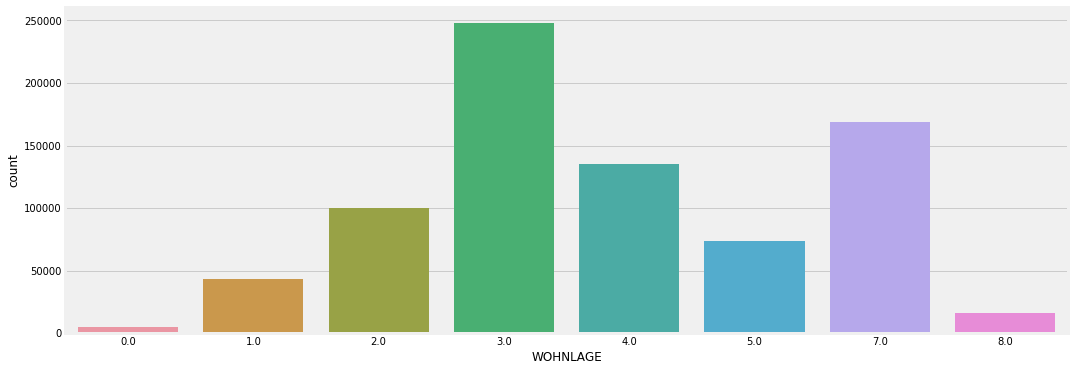

In [150]:
# Investigate "WOHNLAGE" and engineer two new variables and visualize
plt.figure(figsize=(16, 6))
sns.countplot(x="WOHNLAGE", data=azdias_9)

In [151]:
# replace NAN values with 0s, so that dictonary mapping could be used
# e.g. {np.nan: [np.nan, np.nan]} doesn't work.
azdias_9.WOHNLAGE = azdias_9.WOHNLAGE.fillna(0)
customers_9.WOHNLAGE = customers_9.WOHNLAGE.fillna(0)

# create custom dictonary for WOHNLANGE feature
WOHNLAGE_dict = {
    0.0: [np.nan, np.nan],
    1.0: ["very good", 0],
    2.0: ["good", 0],
    3.0: ["average", 0],
    4.0: ["poor", 0],
    5.0: ["very poor", 0],
    7.0: ["unknown", 1],
    8.0: ["new building", 1]
}

In [152]:
%%time
# create new collumns for decade and movement values
_ = azdias_9.WOHNLAGE.apply(lambda s: pd.Series({
    'WOHNLAGE_score':WOHNLAGE_dict[s][0],
    'WOHNLAGE_score_rular':WOHNLAGE_dict[s][1]}))
# add these collumns to data frame
azdias_9 = azdias_9.merge(_, left_index=True, right_index=True);
# drop WOHNLAGE collumn from dataframe
azdias_9 = azdias_9.drop(["WOHNLAGE"], axis=1)

# one-hot encode score
azdias_9 = azdias_9.join(pd.get_dummies(azdias_9["WOHNLAGE_score"],
                                        prefix="WOHNLAGE_score"))

# drop one-hot-encoded original collumns
azdias_9 = azdias_9.drop(["WOHNLAGE_score"], axis=1)

Wall time: 8min 19s


Apply same steps to `customers` DataFrame.

In [153]:
%%time
# create new collumns for decade and movement values
_ = customers_9.WOHNLAGE.apply(lambda s: pd.Series({
    'WOHNLAGE_score':WOHNLAGE_dict[s][0],
    'WOHNLAGE_score_rular':WOHNLAGE_dict[s][1]}))
# add these collumns to data frame
customers_9 = customers_9.merge(_, left_index=True, right_index=True);
# drop WOHNLAGE collumn from dataframe
customers_9 = customers_9.drop(["WOHNLAGE"], axis=1)

# one-hot encode score
customers_9 = customers_9.join(pd.get_dummies(customers_9["WOHNLAGE_score"],
                                              prefix="WOHNLAGE_score"))

# drop one-hot-encoded original collumns
customers_9 = customers_9.drop(["WOHNLAGE_score"], axis=1)

Wall time: 2min 12s


#### 5.5.5 `PLZ8_BAUMAX`

Provides information how many family members are in home or if building is for busness use.

In [154]:
# investigate "PLZ8_BAUMAX" mixed-type meanings

_values = df_attr_p[df_attr_p.Attribute == "PLZ8_BAUMAX"].Values.values[0]
_meanings = df_attr_p[df_attr_p.Attribute == "PLZ8_BAUMAX"].Meanings.values[0]

for _ in range(len(_meanings)):
    print(f"{_values[_]}: {_meanings[_]}")

1: mainly 1-2 family homes
2: mainly 3-5 family homes
3: mainly 6-10 family homes
4: mainly >10 family homes
5: mainly business building


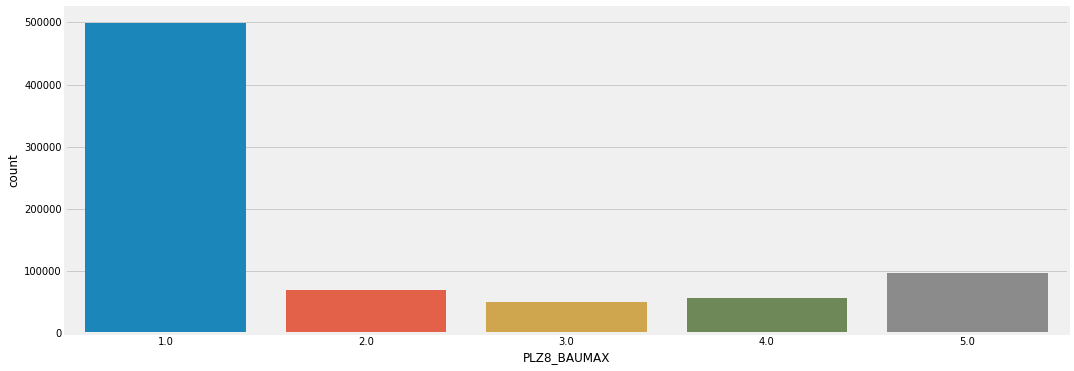

In [155]:
# Investigate "PLZ8_BAUMAX" and engineer two new variables and visualize
plt.figure(figsize=(16, 6))
sns.countplot(x="PLZ8_BAUMAX", data=azdias_9);

In [156]:
azdias_9.PLZ8_BAUMAX.isna().sum()

16708

In [157]:
# replace NAN values with 0s, so that dictonary mapping could be used
# e.g. {np.nan: [np.nan, np.nan]} doesn't work.
azdias_9.PLZ8_BAUMAX = azdias_9.PLZ8_BAUMAX.fillna(0)
customers_9.PLZ8_BAUMAX = customers_9.PLZ8_BAUMAX.fillna(0)

# create custom dictonary for WOHNLANGE feature
PLZ8_BAUMAX_dict = {
    0.0: [np.nan, np.nan],
    1.0: ["1-2", 0],
    2.0: ["3-5", 0],
    3.0: ["6-10", 0],
    4.0: ["10+", 0],
    5.0: ["unknown", 1]
}

In [158]:
%%time
# create new collumns for decade and movement values
_ = azdias_9.PLZ8_BAUMAX.apply(lambda s: pd.Series({
    'PLZ8_BAUMAX_size':PLZ8_BAUMAX_dict[s][0],
    'PLZ8_BAUMAX_cell_type':PLZ8_BAUMAX_dict[s][1]}))
# add these collumns to data frame
azdias_9 = azdias_9.merge(_, left_index=True, right_index=True);
# drop WOHNLAGE collumn from dataframe
azdias_9 = azdias_9.drop(["PLZ8_BAUMAX"], axis=1);

# one-hot encode size
azdias_9 = azdias_9.join(pd.get_dummies(azdias_9["PLZ8_BAUMAX_size"], prefix="PLZ8_BAUMAX_size"))

# drop one-hot-encoded original collumns
azdias_9 = azdias_9.drop(["PLZ8_BAUMAX_size"], axis=1)

Wall time: 11min 21s


Apply same steps to `customers` DataFrame.

In [159]:
%%time
# create new collumns for decade and movement values
_ = customers_9.PLZ8_BAUMAX.apply(lambda s: pd.Series({
    'PLZ8_BAUMAX_size':PLZ8_BAUMAX_dict[s][0],
    'PLZ8_BAUMAX_cell_type':PLZ8_BAUMAX_dict[s][1]}))
# add these collumns to data frame
customers_9 = customers_9.merge(_, left_index=True, right_index=True);
# drop WOHNLAGE collumn from dataframe
customers_9 = customers_9.drop(["PLZ8_BAUMAX"], axis=1)

# one-hot encode size
customers_9 = customers_9.join(pd.get_dummies(customers_9["PLZ8_BAUMAX_size"],
                                              prefix="PLZ8_BAUMAX_size"))

# drop one-hot-encoded original collumns
customers_9 = customers_9.drop(["PLZ8_BAUMAX_size"], axis=1)

Wall time: 2min 18s


## Part 0: Main take aways

* In both `azdias` and `customers` DataFrames 52 columns were found unknown, i.e. no meanings could be identified in provided `.xlsx` files. These columns were droped from further analysis. Even though 3 additinal columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP') in `customers` DataFrames were also not present in `.xlsx` files, column names were explicit enought to understand value's meaning. For this reason, these columns were not dropped,
* Additional **60** columns were droped from `azdias` because they had more than **20%** data missing,
* Additional **59** columns were droped from `customers` because they had more than **30%** data missing. Larger cutoff procentage limit was used, because from visual analysis there there many rows which had **~25%** of missing data in same ammount of columns. Using smaller limit would have resulted in dropping too many columns,
* **12.6%** of rows were droped from from `azdias` because they had more than **55%** missing data,
* **36%** of rows were droped from from `customers` because they had more than **55%** missing data,
* After these procedures 38.39% and 48.61% of data was droped for initail `azdias` and `customers` DataFrames,
* 10 columns were droped (2 and 8 from azdias and customers DataFrames, respectively) so that both DataFrames would ahve same columns,
* I found that columns `CAMEO_DEU_2015` and `CAMEO_DEUINTL_2015` contained 'XX' values (value not found in `.xlsx` files). 'XX' were replaced with numpy nan values,
* 2 columns with `_GROB` endings were droped. Such ending provides same information as `_FEIN`, but rough scale,
* 7 columns were found to contain numeric data,
* 5 columns were found to contain binary categorical data,
* 213 columns were identified as ordinal data, 
* 5 columns had mixed-type data. Custom data encoding was used, 
* Other columns were considered as categorical data and were one-hot encoded (including NAN values).


**DataFrame notations**

* `azdias` and `costomers` contains raw and unprocessed data,
* `_1` raw data with renamed columns to match attribute names in provided `.xlsx` files,
* `_2` contains data of only those columns about which information is found in `.xlsx` files,
* `_3` contains data with renamed NAN values, e.g. -1 was converted to np.nan,
* `_4` columns with 20-30% of missing data are removed,
* `_5` rows with 55% of missing data are removed,
* `_6` contains columns found in both azdias and customers DataFrames. 
* `_7` contains only one-hot encoded categorical data,
* `_8` contains one-hot-encoded categorical data and other not categorical data,
* `_9` mixed-type data was added and one-hot encoded.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Visual investigation of mixed-features

In part 0 found some interesting features, which could be used to compare relative distributions of some of the features.

By comparing distributions of some attributes between `azdias` and `customers` DataFrame one can start to see some interestring patterns.

#### Helper functions for ploting

In [160]:
def plot_attribute(df_azdias, df_customers, attribute_name):
    """
    Input:
        df_azdias: pandas DataFrame,
        df_customers: pandas DataFrame,
        attribute_name: str, attribute name    
    Output:
        Returns a bar plot
    """
    # create figure and axis objects
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex='col')
    # figure title
    fig.suptitle(attribute_name)
    
    # select data with attribute name
    _1 = df_azdias[attribute_name]
    # sort by index
    _1 = _1.value_counts().sort_index() / _1.shape[0] * 100
    # convert x-axis to string to avoid spacing
    ax1.bar(_1.index.astype(str), _1.values, width=0.5, align='edge', label="azdias")
    # select data with attribute name
    _2 = df_customers[attribute_name]
    # sort by index
    _2 = _2.value_counts().sort_index() / _2.shape[0] * 100

    ax1.bar(_2.index.astype(str), _2.values, width=0.5, label="customers")
    
    # calculate procentage difference
    _diff = _1 - _2

    # plot procentage difference
    ax2.bar(_diff.index.astype(str), _diff.values, color="#ff9933")
    
    # add legend and labels to plots
    ax1.legend()
    ax2.set_xlabel(attribute_name)
    ax1.set_ylabel("% of data")
    ax2.set_ylabel("Difference")
    # create small gap between plots
    plt.subplots_adjust(hspace=0.025)

#### 1.1.1 CAMEO_DEUINTL_2015

* `customers` segment has larger representation of *Wealthy Households-Older Families &  Mature Couples* and *Wealthy Households-Elders In Retirement*, i.e. wealthy older people. This naturally leads to lower representation from *Poorer Households-Pre-Family Couples & Singles* and *Poorer Households-Young Couples With Children*.

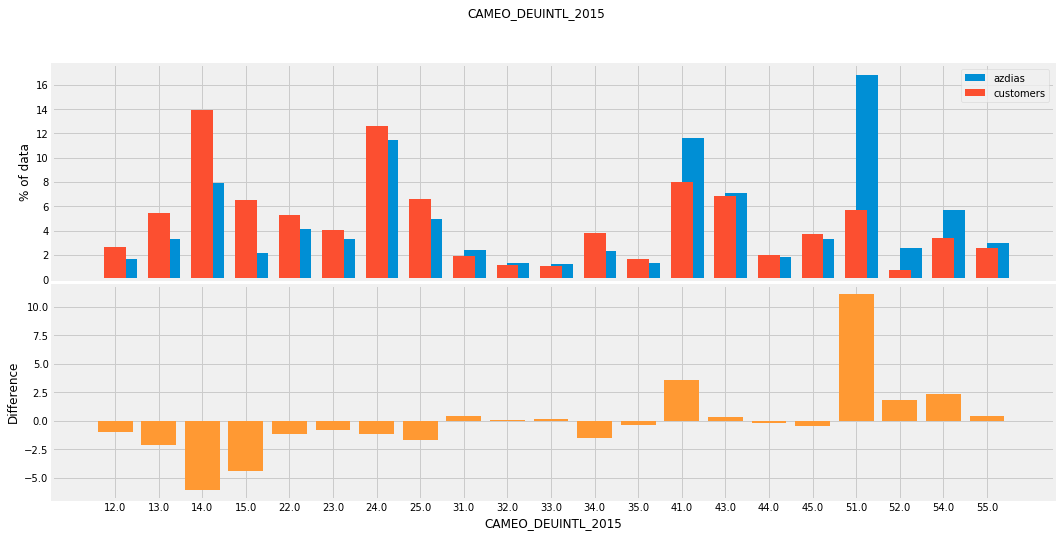

In [161]:
plot_attribute(azdias_8, customers_8, "CAMEO_DEUINTL_2015")

#### 1.1.2 PRAEGENDE_JUGENDJAHRE

* Plot below shows that `customers` are mostly born from 40s to 60s.

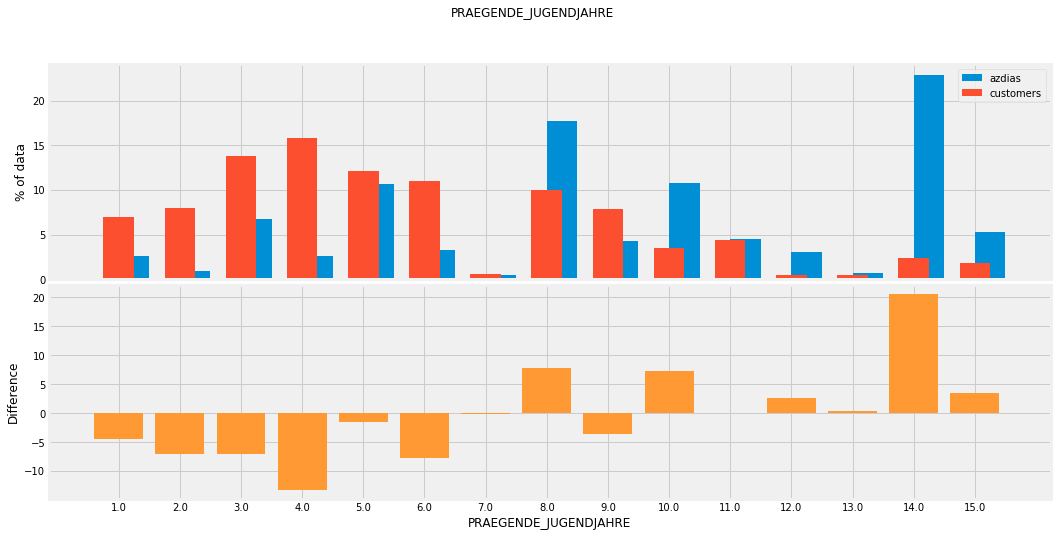

In [162]:
plot_attribute(azdias_8, customers_8, "PRAEGENDE_JUGENDJAHRE")

#### 1.1.3 LP_LEBENSPHASE_FEIN

* `customers` DataFrame contains procentange of *top earners at retirement age from mulitperson households*. It lacks young and low income customers. 

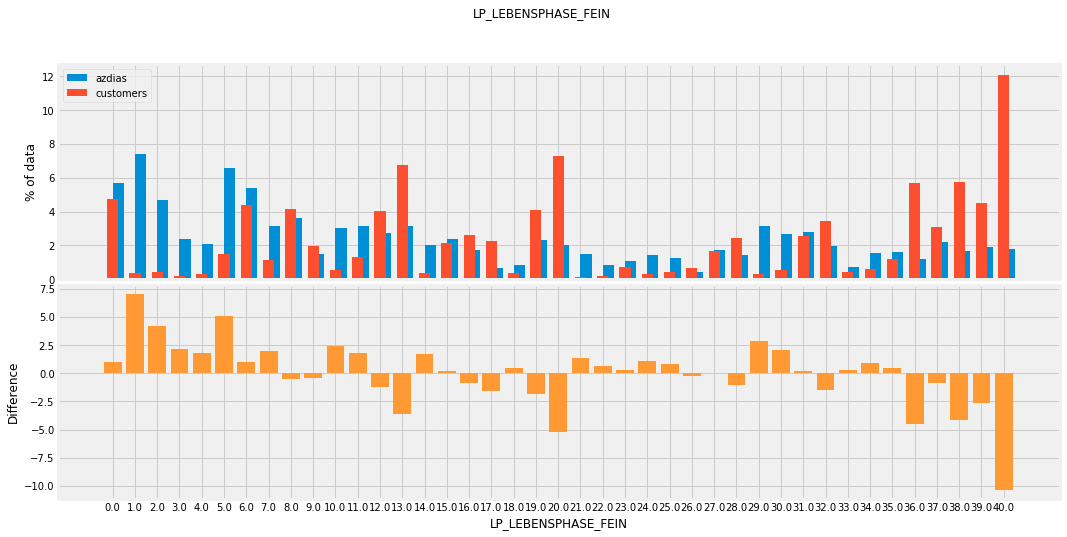

In [163]:
plot_attribute(azdias_8, customers_8, "LP_LEBENSPHASE_FEIN")

#### 1.1.4 WOHNLAGE

* `customers` live in *very good* or *good neighbourhoods*.

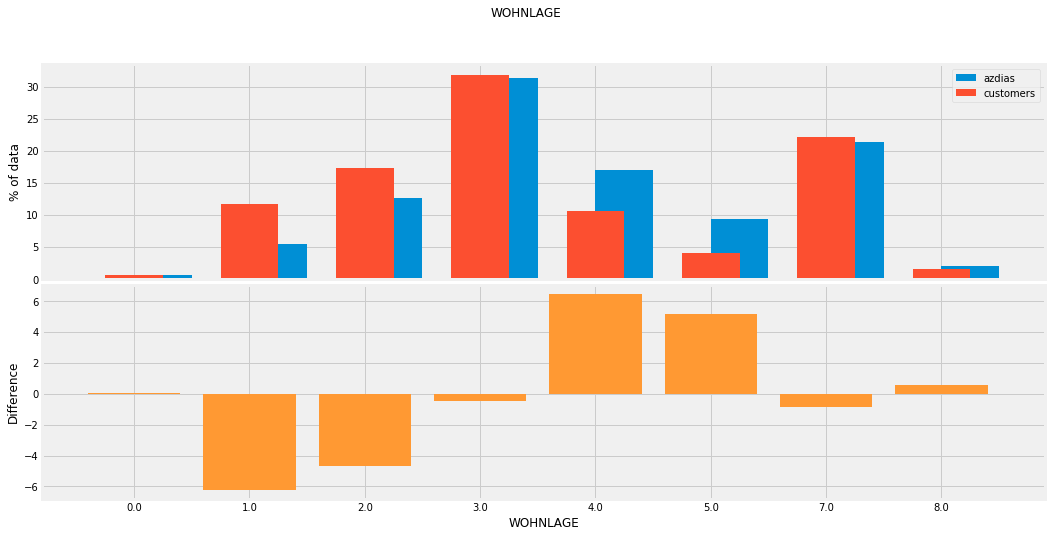

In [164]:
plot_attribute(azdias_8, customers_8, "WOHNLAGE")

#### 1.1.5 PLZ8_BAUMAX

* Most `customers` have *1-2 family homes*, i.e. old people whose children moved out.

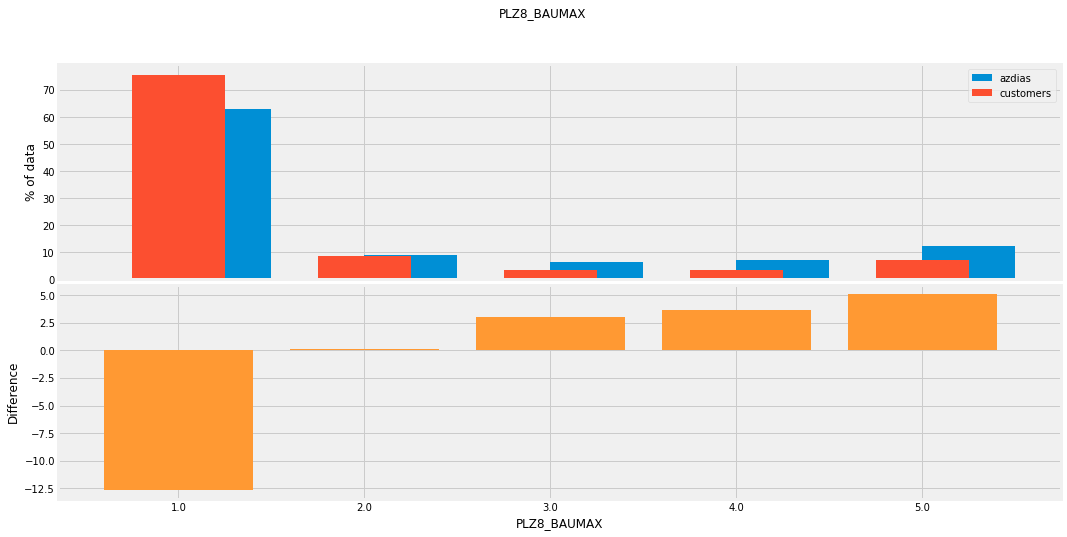

In [165]:
plot_attribute(azdias_8, customers_8, "PLZ8_BAUMAX")

From mixed-type features one can observe that `customers` dataset contains more old, born in 40s-60s, and wealthy, e.g. live in better neighbourhoods.

### 1.2 Features with largest procentage differences

Idea is to find features, which have largest relative procentage difference. `azdias_7` and `customers_7` DataFrame were used (pre one-hot-encoded data).

In [166]:
%%time

_data = list()

# iterate over all population columns
for col_name in azdias_7.columns:
    try:
        # check if col is not numeric
        if col_name not in numeric_col_names:
            # calculate customers value procentages
            _c = customers_7[col_name].value_counts().sort_index() / customers_7[col_name].shape[0] * 100
            # calculate azdias value procentages
            _a = azdias_7[col_name].value_counts().sort_index() / azdias_7[col_name].shape[0] * 100
            # calculate procentage difference
            _diff = _c - _a
            
            # max difference between custoemrs and azdias DataFrames
            _max = _diff.max()
            
            # append max difference data
            _data.append([col_name, _max])
            
        else:
            print(f'{col_name} is numeric value, exclude it from analysis')
    except:
        print(f'{col_name} not found in customers DataFrame')

GEBURTSJAHR is numeric value, exclude it from analysis
ANZ_PERSONEN is numeric value, exclude it from analysis
ANZ_TITEL is numeric value, exclude it from analysis
MIN_GEBAEUDEJAHR is numeric value, exclude it from analysis
KBA13_ANZAHL_PKW is numeric value, exclude it from analysis
ANZ_HAUSHALTE_AKTIV is numeric value, exclude it from analysis
ANZ_HH_TITEL is numeric value, exclude it from analysis
Wall time: 15.3 s


In [167]:
# get top 5 most different 
pd.DataFrame(_data, columns=["col_name", "max_diff"]).sort_values(by='max_diff', ascending=False).head(5)

,col_name,max_diff
267,D19_KK_KUNDENTYP,52.119728
197,FINANZ_VORSORGER,42.399810
103,FINANZ_SPARER,42.123547
163,FINANZ_ANLEGER,39.731819
292,FINANZ_MINIMALIST,37.826384


#### 1.2.1 D19_KK_KUNDENTYP

* Most `customers` are *active customers*, while in `azdias` population people are *inactiver or passive customers*. 

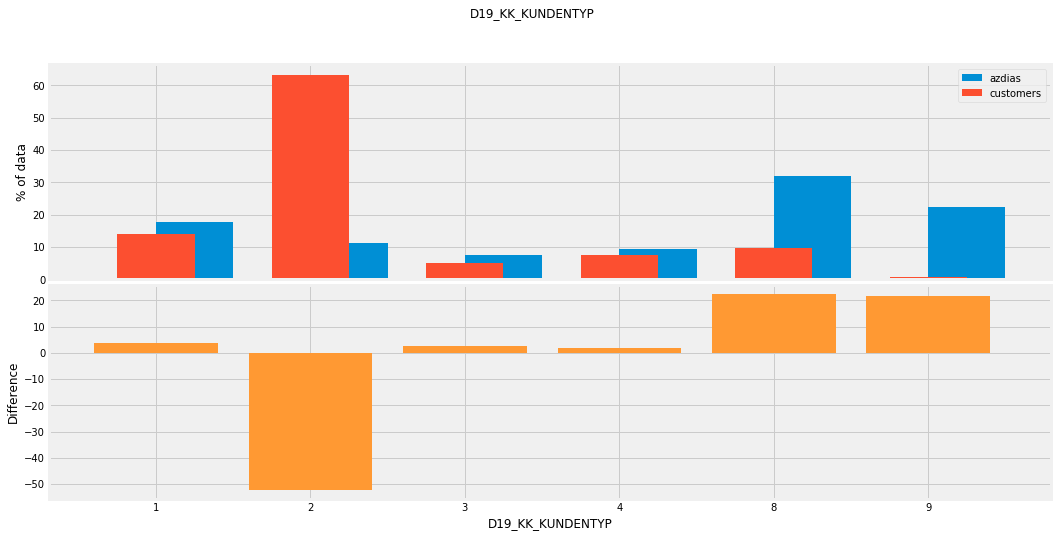

In [168]:
plot_attribute(azdias_7, customers_7, "D19_KK_KUNDENTYP")

#### 1.2.2 FINANZ_VORSORGER

* Most `customers` have financial typology of low preparation.

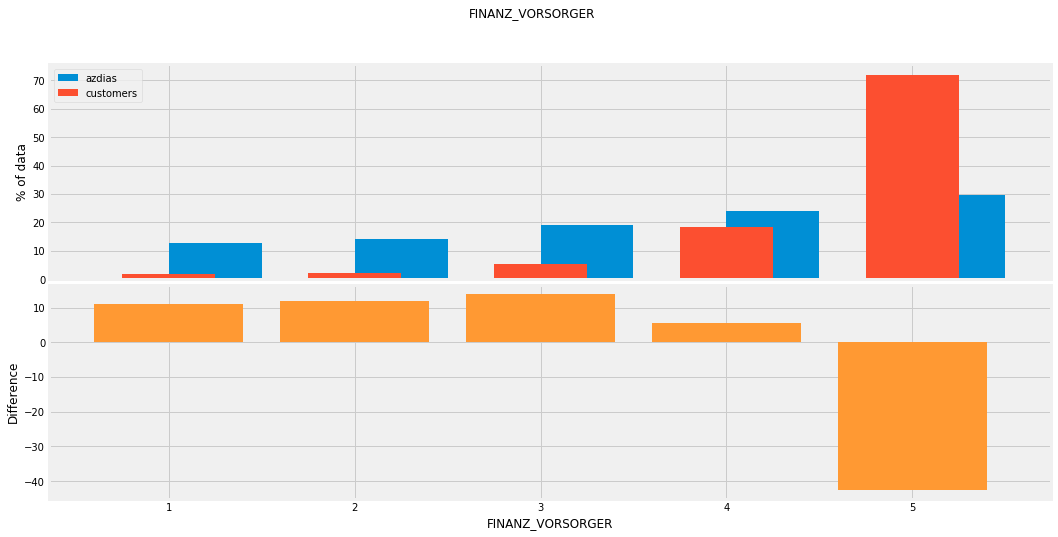

In [169]:
plot_attribute(azdias_7, customers_7, "FINANZ_VORSORGER")

#### 1.2.3 FINANZ_SPARER

* Most `customers` have financial typology of very-high savings.

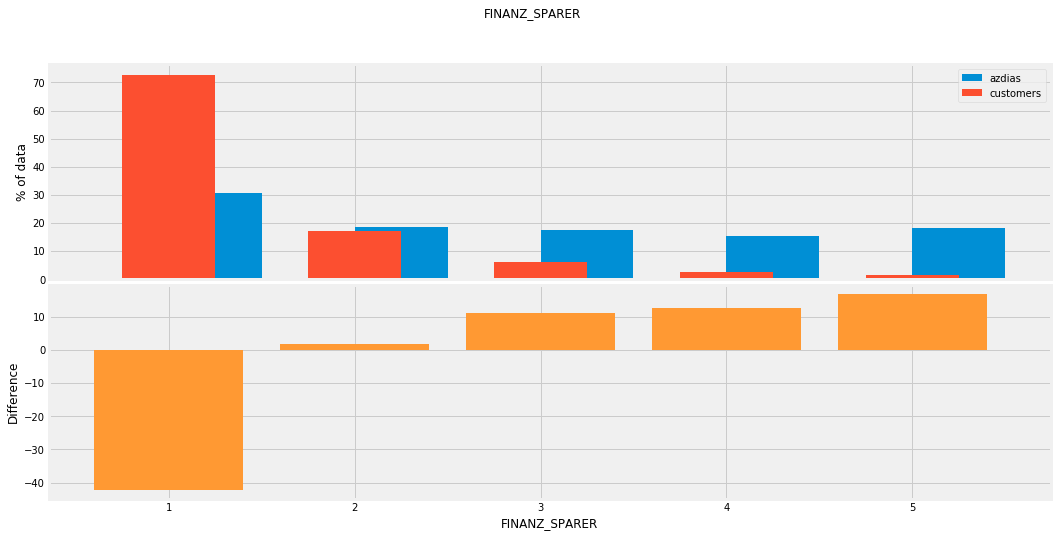

In [170]:
plot_attribute(azdias_7, customers_7, "FINANZ_SPARER")

#### 1.2.4 FINANZ_ANLEGER

* Most `customers` have very-high investments. 

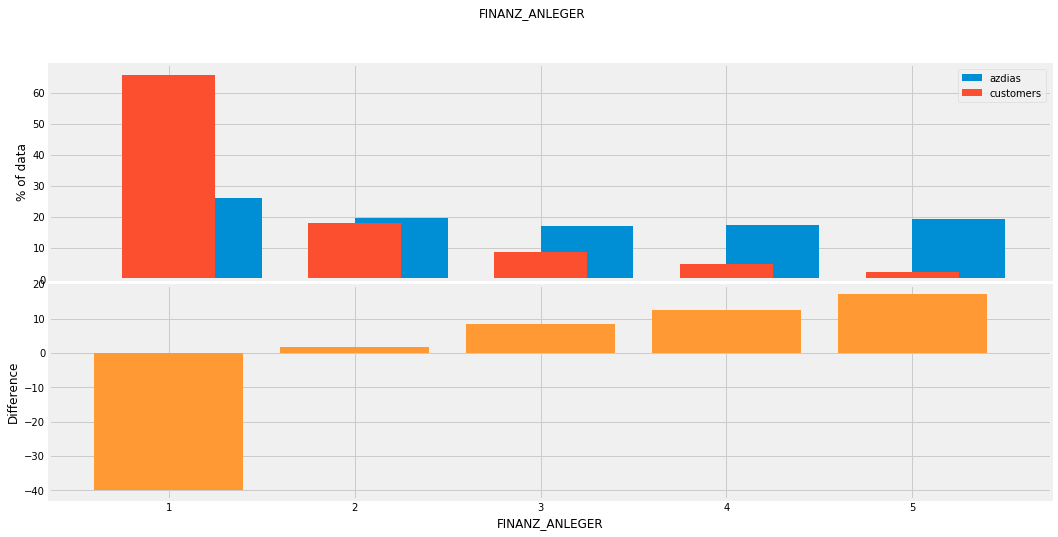

In [171]:
plot_attribute(azdias_7, customers_7, "FINANZ_ANLEGER")

#### 1.2.5 FINANZ_MINIMALIST

* Most `customers` have very-low low financial interest.

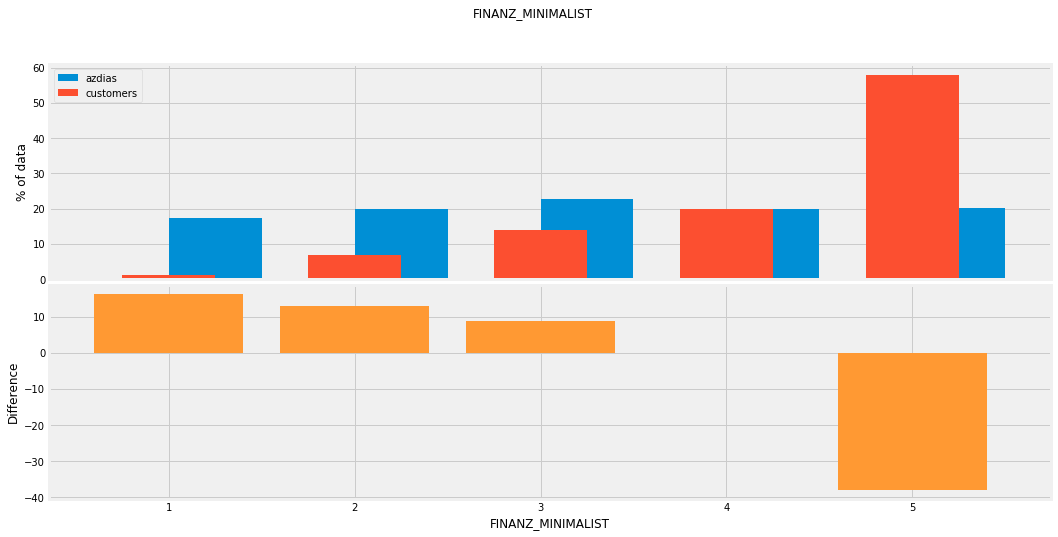

In [172]:
plot_attribute(azdias_7, customers_7, "FINANZ_MINIMALIST")

### 1.3 PCA

After data processing `azdias_8` and `customers_8` DataFrames contains 1777 and 1812 columns, respectively. Principal component analysis (PCA) will be used to reduce dimesionality to extract features from general population of Germany and customers dataset.  

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### 1.3.1 Removing remaining missing data entries

`sklearn` models requires that data not have missing values in order for its estimators to work properly. For this reason, remaining missing data needs to be processed.

In [173]:
# create DataFrame copies for removing remaining data with NAN values
azdias_10 = azdias_9.copy()
customers_10 = customers_9.copy()

#### Investigate how much missing data is left in `azdias` DataFrame

In [174]:
%%time

# total missing data in processed DataFrame
total_nan = azdias_10.isna().sum().sum()
total = azdias_10.shape[0] * azdias_10.shape[1]
print("Total misssing data {:.3f}% from azdias".format(total_nan/total*100))

Total misssing data 0.547% from azdias
Wall time: 35 s


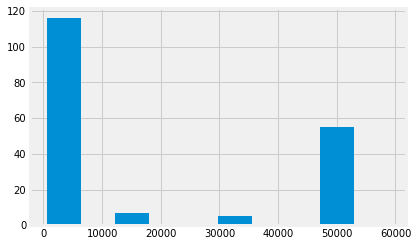

In [175]:
# count NAN values per column
_ = azdias_10.isna().sum()
# print out only columns containing missing values
_[_>0].hist();

It seems like most rows have missing values in same columns. Not all missing values can be imputed or replaced with zero. For this reason I chose to fix few columns below and then drop all remaining missing data.

In [176]:
%%time
# remove all rows which contain atleast one nan value
_no_nan = azdias_10.dropna()
total = azdias_10.shape[0]
total_no_nan = _no_nan.shape[0]
proc = total_no_nan/total*100
print("{:.2f}% of data will be left if all rows containing atleast one NAN would be removed (azdias)".format(proc))

_no_nan = customers_10.dropna()
total = customers_10.shape[0]
total_no_nan = _no_nan.shape[0]
proc = total_no_nan/total*100
print("{:.2f}% of data will be left if all rows containing atleast one NAN would be removed (customers)".format(proc))

81.78% of data will be left if all rows containing atleast one NAN would be removed (azdias)
85.84% of data will be left if all rows containing atleast one NAN would be removed (customers)
Wall time: 42.7 s


In [177]:
# Helper function to print out column/feature descrition

def get_description(df_attr, attr_name):
    """
    Input:
        df_attr: pandas DataFrame, containing information about attributes
        attr_name: str, attribute name
    Output:
        prints attribute description
    """
    try:
        description = df_attr[df_attr.Attribute == attr_name].Description_a.values[0]
    except:
        description = "not found"
    print(f'{attr_name:30s}: {description}')

In [178]:
# iterate over attribute names
for a_name in _[_>0].index:
    get_description(df_attr_p, a_name)

ANZ_HH_TITEL                  : number of academic title holder in building
KBA13_ANZAHL_PKW              : number of cars in the PLZ8
KBA05_SEG6                    : share of upper class cars (BMW 7er etc.) in the microcell
VERS_TYP                      : insurance typology 
KBA13_KW_60                   : share of cars with an engine power between 51 and 60 KW - PLZ8
KBA13_VW                      : share of VOLKSWAGEN within the PLZ8
KBA05_ZUL1                    : share of cars built before 1994
KBA05_MOTOR                   : most common engine size in the microcell
KBA13_KRSSEG_VAN              : share of vans (referred to the county average) - PLZ8
KBA05_KRSKLEIN                : share of small cars (referred to the county average)
KBA13_HALTER_55               : share of car owners between 51 and 55 within the PLZ8
KBA13_SEG_KOMPAKTKLASSE       : share of lowe midclass cars (Ford Focus etc.) in the PLZ8
KBA05_ZUL4                    : share of cars built from 2003 on
KBA05_ALTER

KBA13_RENAULT                 : share of RENAULT within the PLZ8
KBA05_ANTG3                   : number of 6-10 family houses in the cell
KBA05_HERST1                  : share of top German manufacturer (Mercedes, BMW) 
KBA05_SEG10                   : share of more specific cars (Vans, convertables, all-terrains, MUVs etc.)
KBA05_FRAU                    : share of female car owners
KBA13_BMW                     : share of BMW within the PLZ8
KBA13_KRSHERST_FORD_OPEL      : share of FORD/Opel (referred to the county average) - PLZ8
KBA05_SEG3                    : share of lowe midclass cars (Ford Focus etc.) in the microcell
KBA13_SEG_MITTELKLASSE        : share of middle class cars (Ford Mondeo etc.) in the PLZ8
KBA13_KMH_0_140               : share of cars with max speed 140 km/h within the PLZ8
KBA05_ALTER1                  : share of car owners less than 31 years old
KBA05_CCM4                    : share of cars with more than 2499ccm
KBA05_MOTRAD                  : share of motorcy

* Some columns NAN values can be substituted with 0s (read commments above lines of code).

* `KBA13_ANZAHL_PKW` missing values were imputed with mean value.

In [179]:
# most users don't hold title inbuilding, i.e. 0 value, hence it is safe to replace NAN values with zeros
azdias_10["ANZ_HH_TITEL"].fillna(0, inplace=True)
customers_10["ANZ_HH_TITEL"].fillna(0, inplace=True)

# I asume that it is more likely for people to declare that they have BMW 7er etc., i.e. bragging. 
# For this reason I will replace NAN values with 0, which indicates that people don't have BMW 7er etc.
azdias_10["KBA05_SEG6"].fillna(0, inplace=True)
customers_10["KBA05_SEG6"].fillna(0, inplace=True)

# PLZ8_BAUMAX_cell_type tells whatever building is business building. It is much more likely that building 
# is not for business (mean 0.12), for this reason will make assumtion, that unknown values are about buildings
# not for business, i.e. fill NAN values with zeros. 
azdias_10["PLZ8_BAUMAX_cell_type"].fillna(0, inplace=True)
customers_10["PLZ8_BAUMAX_cell_type"].fillna(0, inplace=True)

# Because only <1% of data is missing, I decided to impute KBA13_ANZAHL_PKW NAN values with general population mean.
_mean = azdias_10["KBA13_ANZAHL_PKW"].mean()
azdias_10["KBA13_ANZAHL_PKW"].fillna(_mean, inplace=True)
customers_10["KBA13_ANZAHL_PKW"].fillna(_mean, inplace=True)

Cells below were used to manually investigate feature.

In [180]:
# get_description(df_attr_p, "ANZ_HH_TITEL")
# azdias_10["ANZ_HH_TITEL"].describe()

In [181]:
# _ = azdias_10["ANZ_HH_TITEL"].isna().mean() * 100
# print(f'{_:.2f}% of data is missing')

#### Drop rows with missing values from `azdias` and `customers` DataFrame

In [182]:
%%time
# remove all rows which contain atleast one nan value

total = azdias_10.shape[0]
# drop NAN values and re-save
azdias_10 = azdias_10.dropna()
total_no_nan = azdias_10.shape[0]
proc = total_no_nan/total*100
print("{:.2f}% of data left after dropping all rows which contain atleast one NAN value".format(proc))


total = customers_10.shape[0]
# drop NAN values and re-save
customers_10 = customers_10.dropna()
total_no_nan = customers_10.shape[0]
proc = total_no_nan/total*100
print("{:.2f}% of data left after dropping all rows which contain atleast one NAN value".format(proc))

81.78% of data left after dropping all rows which contain atleast one NAN value
85.84% of data left after dropping all rows which contain atleast one NAN value
Wall time: 52.2 s


No significant changes were were achieved after imputing missing values. 

#### Final check
Check that both DataFrames have same columns.

In [183]:
set_a = set(azdias_10.columns)
set_c = set(customers_10.columns)
set_a.difference(set_c)

set()

It seems that both DataFrames have same columns. Final quick fix is to make sure that column order is the same.

In [184]:
# make sure that both DataFrames have same columns ordering
col_order = azdias_10.columns.tolist()
azdias_10 = azdias_10[col_order]
customers_10 = customers_10[col_order]
# make sure that all values are encoded as float64
azdias_10 = azdias_10.astype(np.float64)
customers_10 = customers_10.astype(np.float64)

#### 1.3.2 Feature Scaling

Use StandardScaler module scales each feature to mean 0 and standard deviation 1.

In [185]:
%%time

# create scaler
scaler_a = p.StandardScaler()
scaler_c = p.StandardScaler()
# scale data with no NAN values
scaler_a.fit(azdias_10)
scaler_c.fit(customers_10)
# create new dataframe using standard scaller
azdias_ss = pd.DataFrame(scaler_a.transform(azdias_10), columns = azdias_10.columns.values)
customers_ss = pd.DataFrame(scaler_c.transform(customers_10), columns = customers_10.columns.values)

Wall time: 1min


#### 1.3.3 Dimensionality Reduction

First one needs to decide on how meany features can we reduce DataFrame.

Here one needs to identify how much one can reduce features without loosing variability.

In [186]:
azdias_ss.shape

(647044, 868)

In [187]:
customers_ss.shape

(120917, 868)

#### Decide how much should features can we reduce

Main idea is to find balance between reduced number of features and remaining variance.

In [ ]:
%%time

# Apply PCA to azdias DataFrame

var_list = list()
comp_list= list()

for _ in [100, 150, 200, 250, 300, 350, 400, 450,  500, 550, 600, 700, 800, 860]:
    pca = PCA(_)
    X_pca = pca.fit_transform(customers_ss)
    var = np.sum(pca.explained_variance_ratio_)
    var_list.append(var)
    comp_list.append(_)

#### Plot results

In [ ]:
# fit segments of PCA variance results
p1 = np.polyfit(comp_list[2:5], var_list[2:5], deg=1)
p2 = np.polyfit(comp_list[-4:], var_list[-4:], deg=1)

x = np.array(comp_list)
y1 = p1[1] + p1[0] * np.array(comp_list)
y2 = p2[1] + p2[0] * np.array(comp_list)

plt.figure(figsize=(16,6))
plt.plot(comp_list, var_list, "o-", linewidth=3);
plt.title("Principle component variance vs no. of components")
plt.xlabel('no. of principal components')
plt.ylabel('Variance explained (%)');
plt.plot(x, y1, 'g--', linewidth=2)
plt.plot(x, y2, 'g--', linewidth=2)
plt.plot([520, 520],[0, 1], "r-")
plt.ylim(0.3,1.05);

In [ ]:
plt.figure(figsize=(16,6))

plt.plot([0, 100], [0, 100])

plt.plot([45, 45],[0, 100])

plt.plot(np.array(comp_list)/879*100, np.array(comp_list)/879/var_list*100, "o-", linewidth=3)

plt.title("How much variance explained vs data dimension reduction")
plt.xlabel('Dimensionality reduction (%)')
plt.ylabel('Variance explained (%)');
# plt.ylim(0.1,1.05);

In [188]:
%%time

# Re-apply PCA to the data while selecting for number of components to retain.

# I chose to use 400 components (due to memory constrains) 
# it reduces component number by ~55%, while retaining >80% variance
pca_a = PCA(400)
azdias_pca = pca_a.fit_transform(azdias_ss)
var = np.sum(pca_a.explained_variance_ratio_)
print("Variance: {}".format(var))

Variance: 0.8121763980734026
Wall time: 5min 19s


In [189]:
def scree_plot(pca, comp_start = 0, comp_end = 10):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_) #comp_end-comp_start
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    
    ax.bar(ind[comp_start:comp_end], vals[comp_start:comp_end], alpha=0.5)
    ax.plot(ind[comp_start:comp_end], cumvals[comp_start:comp_end], "r--", alpha=0.5)
    for i in list(range(comp_start, comp_end)): #range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component (Range {}-{} components)'.format(comp_start, comp_end))

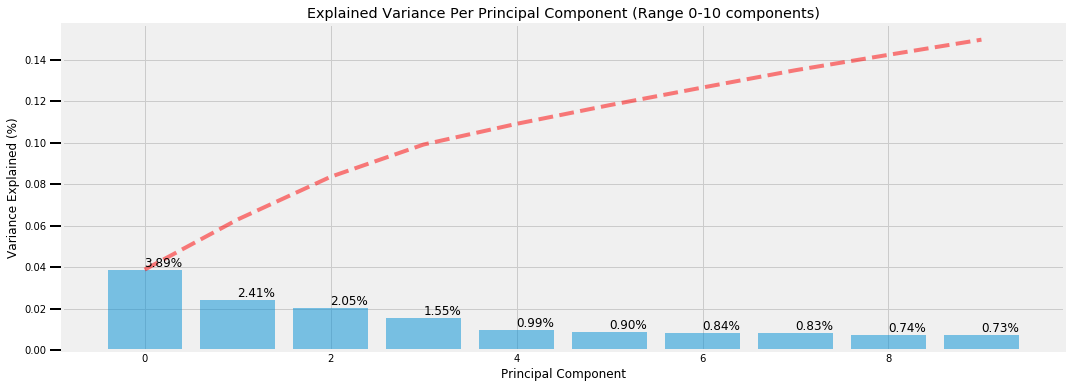

In [190]:
# check first 15 components
scree_plot(pca_a, comp_start = 0, comp_end = 10)

#### 1.3.4 Interperete main principle components

#### `Azdias` DataFrame

Helper fuction `analyze_component` plots and prints out most components with largest (positive, negative and absolute) weights.

In [191]:
# function used to find weights.
def analyze_component(df, pca, comp, top=5):
    '''
    Plots an image associated with each component to understand how the weighting 
    of the components 
    INPUT: 
          df - Dataframe on which PCA was done
          pca - pca object created from PCA in sklearn
          comp - int - the component you want to see starting at 0
          
    OUTPUT
          None
    '''
    if comp <= len(pca.components_):
        # create Dataframe for PCA weighs for each feature
        df = pd.DataFrame(np.array([df.columns.values, pca.components_[comp]]).T, columns=["Feature", "Weight"])
        # convert weights to floats
        df["Weight"] = df["Weight"].astype("float64")
        # get top positive and negative features
        df_p = df.nlargest(top, 'Weight')
        df_n = df.nsmallest(top, 'Weight')
        df_list = [df_p, df_n]
        
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,20))
        names = ["Top {} positive features".format(top),
                 "Top {} negative features".format(top)]
        for ax, index in zip(axes.flatten(), range(2)):
            sns.barplot(y="Feature", x="Weight", data=df_list[index], ax=ax).set_title(names[index])
           
        print(f"top {top} positive")
        for _ in df_p.Feature:
            get_description(df_attr_p, _)
            
        
        print(f"top {top} negative")
        for _ in df_n.Feature:
            get_description(df_attr_p, _)
    else:
        print('{} components are available, you asked for {} compoent which is out of range'.format(len(pca.components_) ,comp))

#### 1st component

It is about people's tendancies to shop/order stuff online. Top positive features are all about afinity towards mail-order, while negative features (which should anticoralte) show that there is no information about peoples online behaviours. It also shows that there is correlation between people who shop and their movement behaviours.

top 5 positive
D19_GESAMT_ANZ_24             : transaction activity TOTAL POOL in the last 24 months 
ONLINE_AFFINITAET             : online affinity
D19_VERSAND_ANZ_24            : transaction activity MAIL-ORDER in the last 24 months
D19_GESAMT_ANZ_12             : transaction activity TOTAL POOL in the last 12 months 
MOBI_REGIO                    : moving patterns
top 5 negative
HH_EINKOMMEN_SCORE            : estimated household net income 
D19_VERSAND_DATUM_10          : not found
D19_VERSAND_ONLINE_DATUM_10   : not found
D19_GESAMT_ONLINE_DATUM_10    : not found
D19_GESAMT_OFFLINE_DATUM_10   : not found


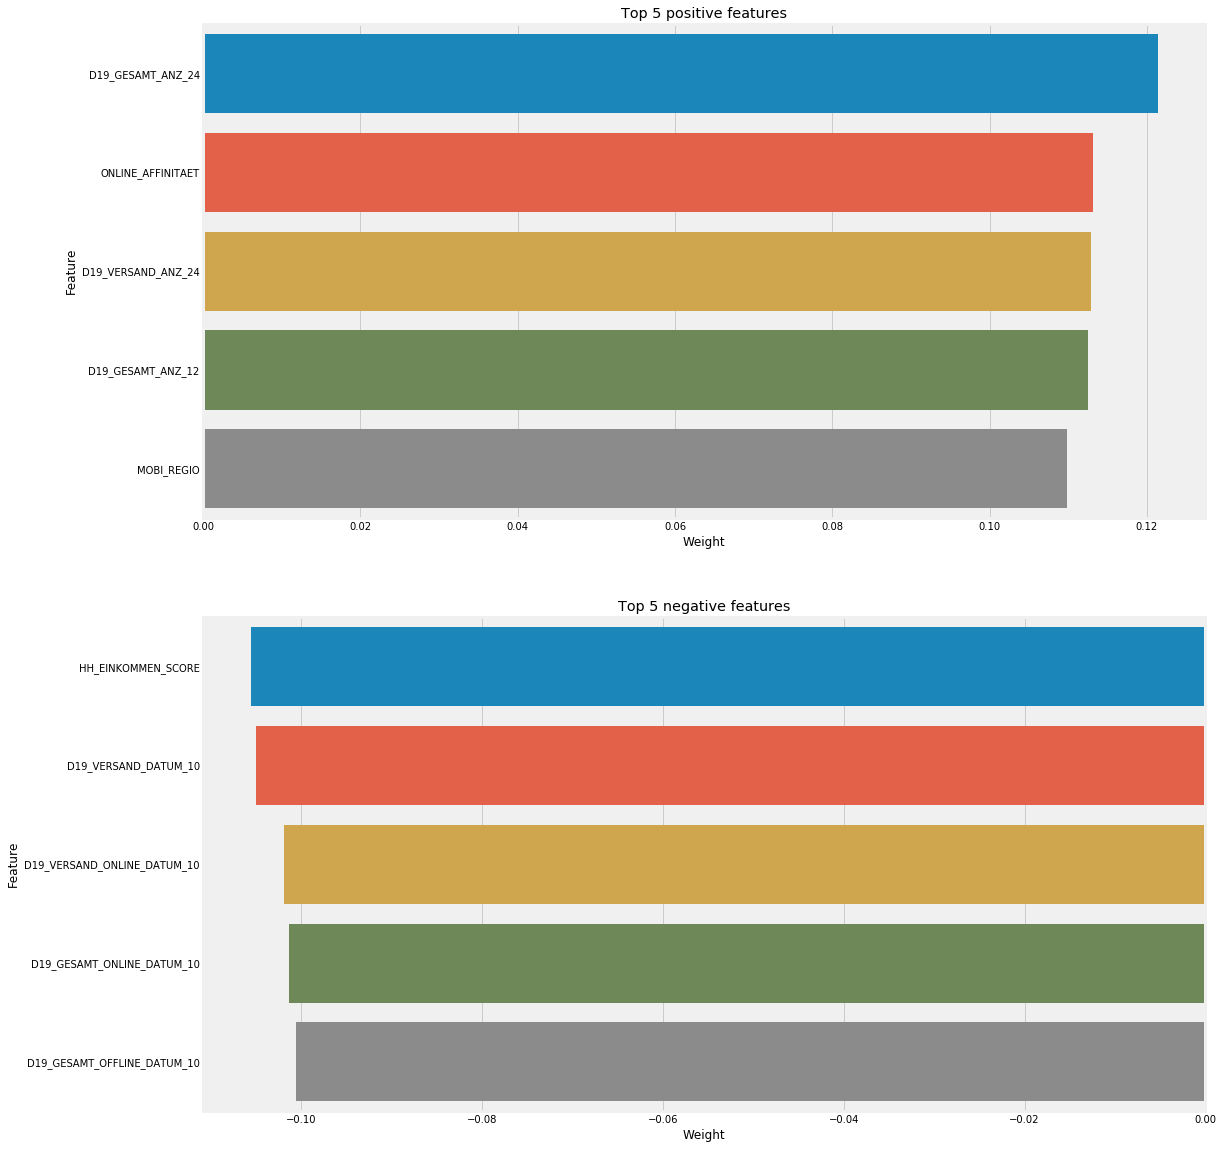

In [192]:
# Map weights for the first principal component to corresponding feature names

analyze_component(azdias_ss, pca_a, 0, top=5)

In [193]:
get_description(df_attr_p, "D19_GESAMT_OFFLINE_DATUM")

D19_GESAMT_OFFLINE_DATUM      : actuality of the last transaction with the complete file OFFLINE


#### 2nd component

It is about financial typology. Positive features show that people save money and have affinity towards online transactions, while negative fetures show small size families with low interest in saving money.

top 5 positive
FINANZ_SPARER                 : financial typology: money saver
D19_GESAMT_ANZ_24             : transaction activity TOTAL POOL in the last 24 months 
D19_GESAMT_ANZ_12             : transaction activity TOTAL POOL in the last 12 months 
ONLINE_AFFINITAET             : online affinity
D19_VERSAND_ANZ_24            : transaction activity MAIL-ORDER in the last 24 months
top 5 negative
FINANZ_MINIMALIST             : financial typology: low financial interest
FINANZ_VORSORGER              : financial typology: be prepared
PLZ8_ANTG1                    : number of 1-2 family houses in the PLZ8
D19_BANKEN_DATUM_10           : not found
PLZ8_BAUMAX_size_1-2          : not found


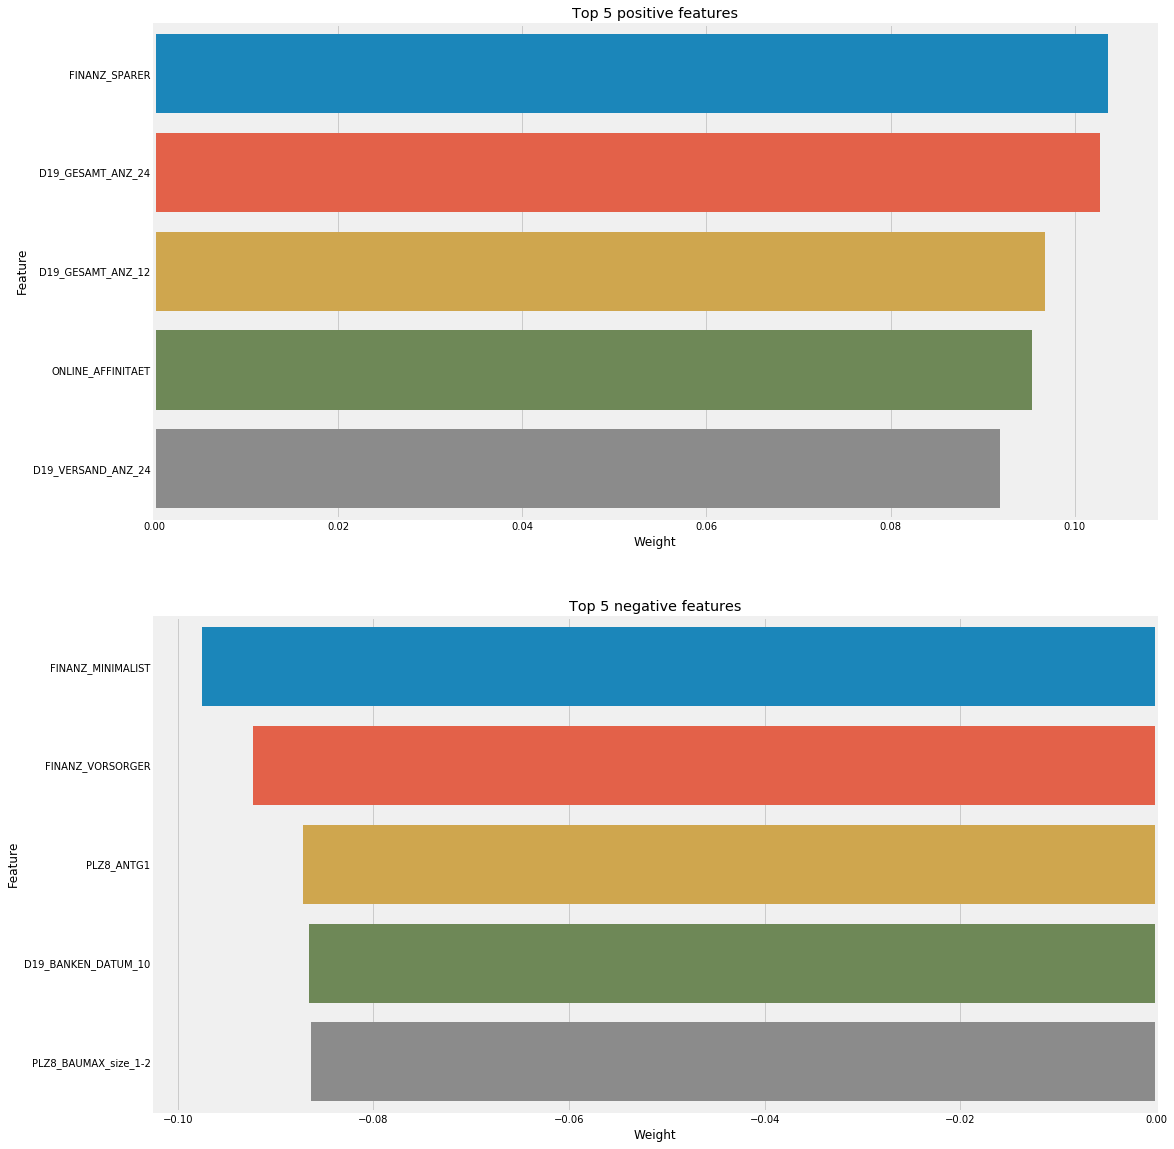

In [194]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

analyze_component(azdias_ss, pca_a, 1, top=5)

In [195]:
get_description(df_attr_p, "PLZ8_BAUMAX")

PLZ8_BAUMAX                   : most common building-type within the PLZ8


#### 3rd component

This component is about cars. Positive attributes show the share of expensive german cars in PLZ8 region while negative attributes show how many old people have this cars. I can just suspect that the more expensive cars area has, the less old people are in that area with expensive cars.

top 5 positive
KBA13_HERST_BMW_BENZ          : share of BMW & Mercedes Benz within the PLZ8
KBA13_SEG_OBEREMITTELKLASSE   : share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)
KBA13_BMW                     : share of BMW within the PLZ8
KBA13_MERCEDES                : share of MERCEDES within the PLZ8
EWDICHTE                      : density of inhabitants per square kilometer
top 5 negative
KBA13_SITZE_5                 : number of cars with 5 seats in the PLZ8
KBA13_ALTERHALTER_60          : share of car owners between 46 and 60 within the PLZ8
KBA13_HALTER_20               : share of car owners below 21 within the PLZ8
KBA13_KMH_140_210             : share of cars with max speed between 140 and 210 km/h within the PLZ8
KBA13_HALTER_55               : share of car owners between 51 and 55 within the PLZ8


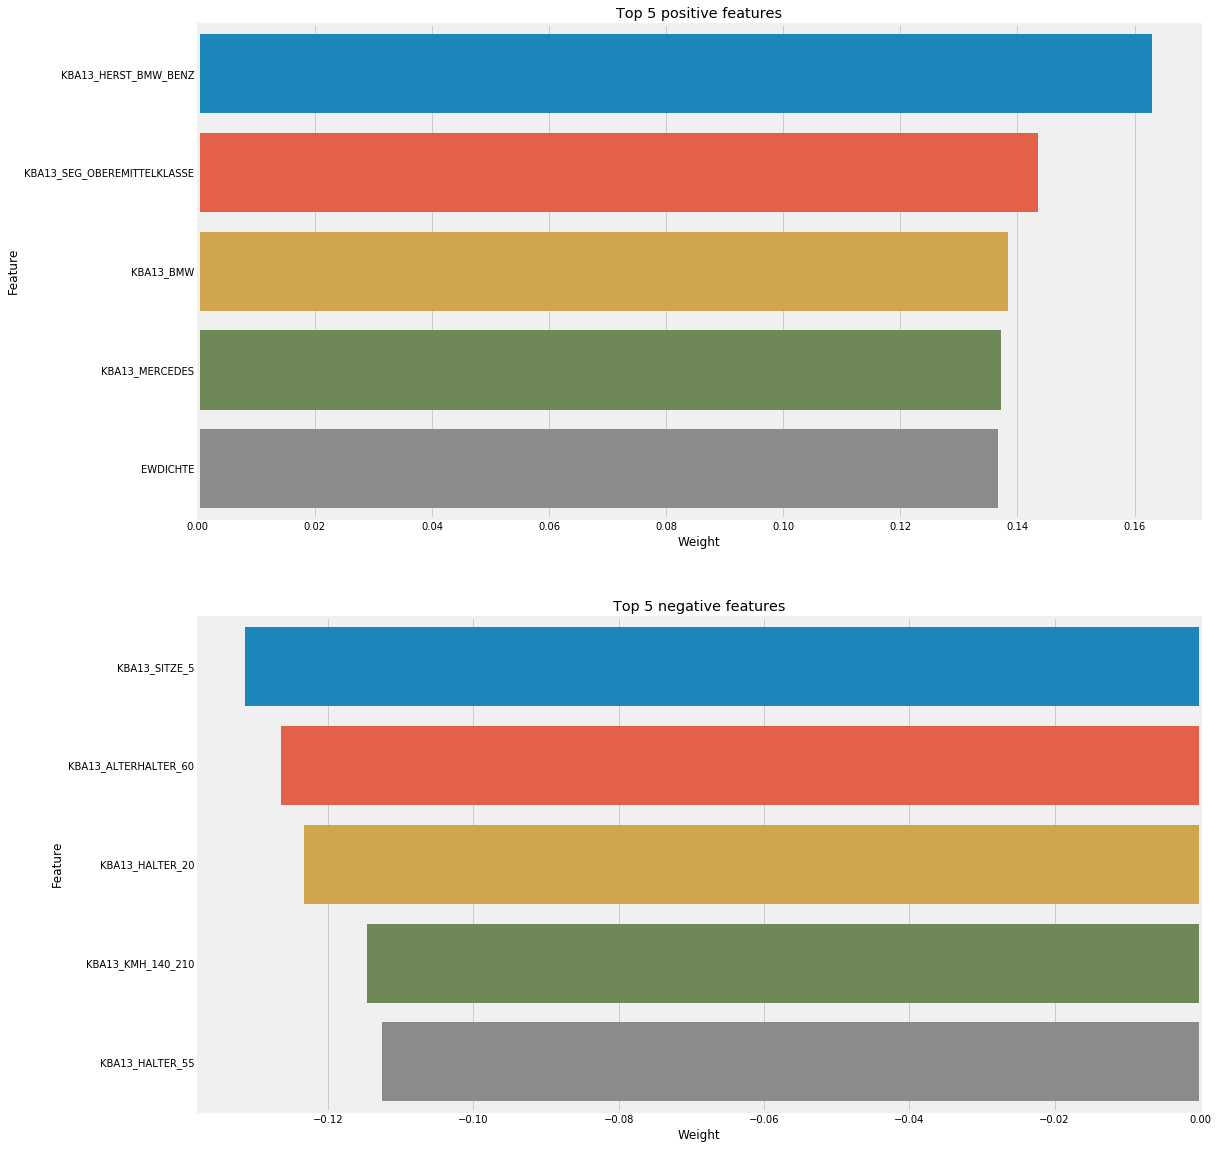

In [196]:
analyze_component(azdias_ss, pca_a, 2, top=5)

#### `Customers` DataFrame

In [197]:
%%time

# Re-apply PCA to the data while selecting for number of components to retain.

# I chose to use 400 components (due to memory constrains) 
# it reduces component number by ~55%, while retaining >80% variance
pca_c = PCA(400)
customers_pca = pca_c.fit_transform(customers_ss)
var = np.sum(pca_c.explained_variance_ratio_)
print("Variance: {}".format(var))

Variance: 0.8095018182132923
Wall time: 49.8 s


#### 1st component

Very similiar to `azdias` DataFrame's first component. Main differences comes from features with negative sign. It seems that if user is more likely to use online services then it anti-correlates wth larger families, density of inhabinants and family having a child.

top 5 positive
D19_GESAMT_ANZ_24             : transaction activity TOTAL POOL in the last 24 months 
ONLINE_AFFINITAET             : online affinity
D19_GESAMT_ANZ_12             : transaction activity TOTAL POOL in the last 12 months 
D19_VERSAND_ANZ_24            : transaction activity MAIL-ORDER in the last 24 months
MOBI_REGIO                    : moving patterns
top 5 negative
FINANZ_HAUSBAUER              : financial typology: main focus is the own house
PLZ8_ANTG3                    : number of 6-10 family houses in the PLZ8
W_KEIT_KIND_HH                : likelihood of a child present in this household
EWDICHTE                      : density of inhabitants per square kilometer
KBA05_ANTG1_0.0               : not found


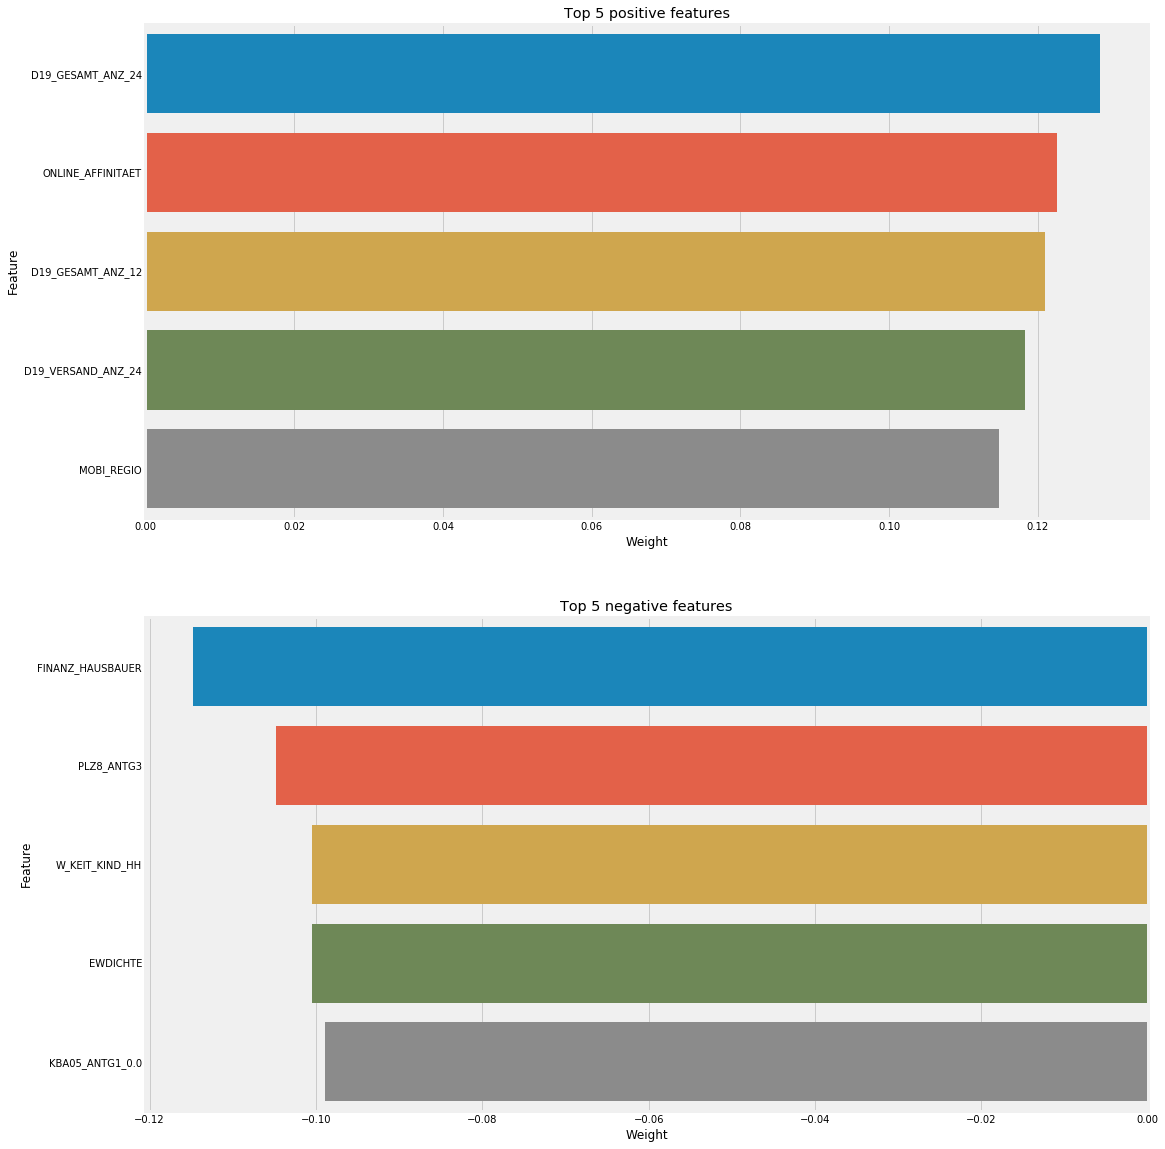

In [198]:
# Map weights for the first principal component to corresponding feature names

analyze_component(customers_ss, pca_c, 0, top=5)

In [199]:
get_description(df_attr_p, "KBA05_ANTG1")

KBA05_ANTG1                   : number of 1-2 family houses in the cell


#### 2nd component

Again, very similiar to `azdias` 3rd component.

top 5 positive
KBA13_HERST_BMW_BENZ          : share of BMW & Mercedes Benz within the PLZ8
KBA13_SEG_OBEREMITTELKLASSE   : share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)
KBA05_KW3                     : share of cars with an engine power of more than 119 KW
KBA13_MERCEDES                : share of MERCEDES within the PLZ8
KBA05_HERST1                  : share of top German manufacturer (Mercedes, BMW) 
top 5 negative
KBA13_KMH_180                 : share of cars with max speed between 110 km/h and 180km/h within the PLZ8
KBA13_KW_0_60                 : share of cars up to 60 KW engine power - PLZ8
KBA13_KMH_140_210             : share of cars with max speed between 140 and 210 km/h within the PLZ8
KBA13_SEG_KLEINWAGEN          : share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8
KBA13_HERST_FORD_OPEL         : share of Ford & Opel/Vauxhall within the PLZ8


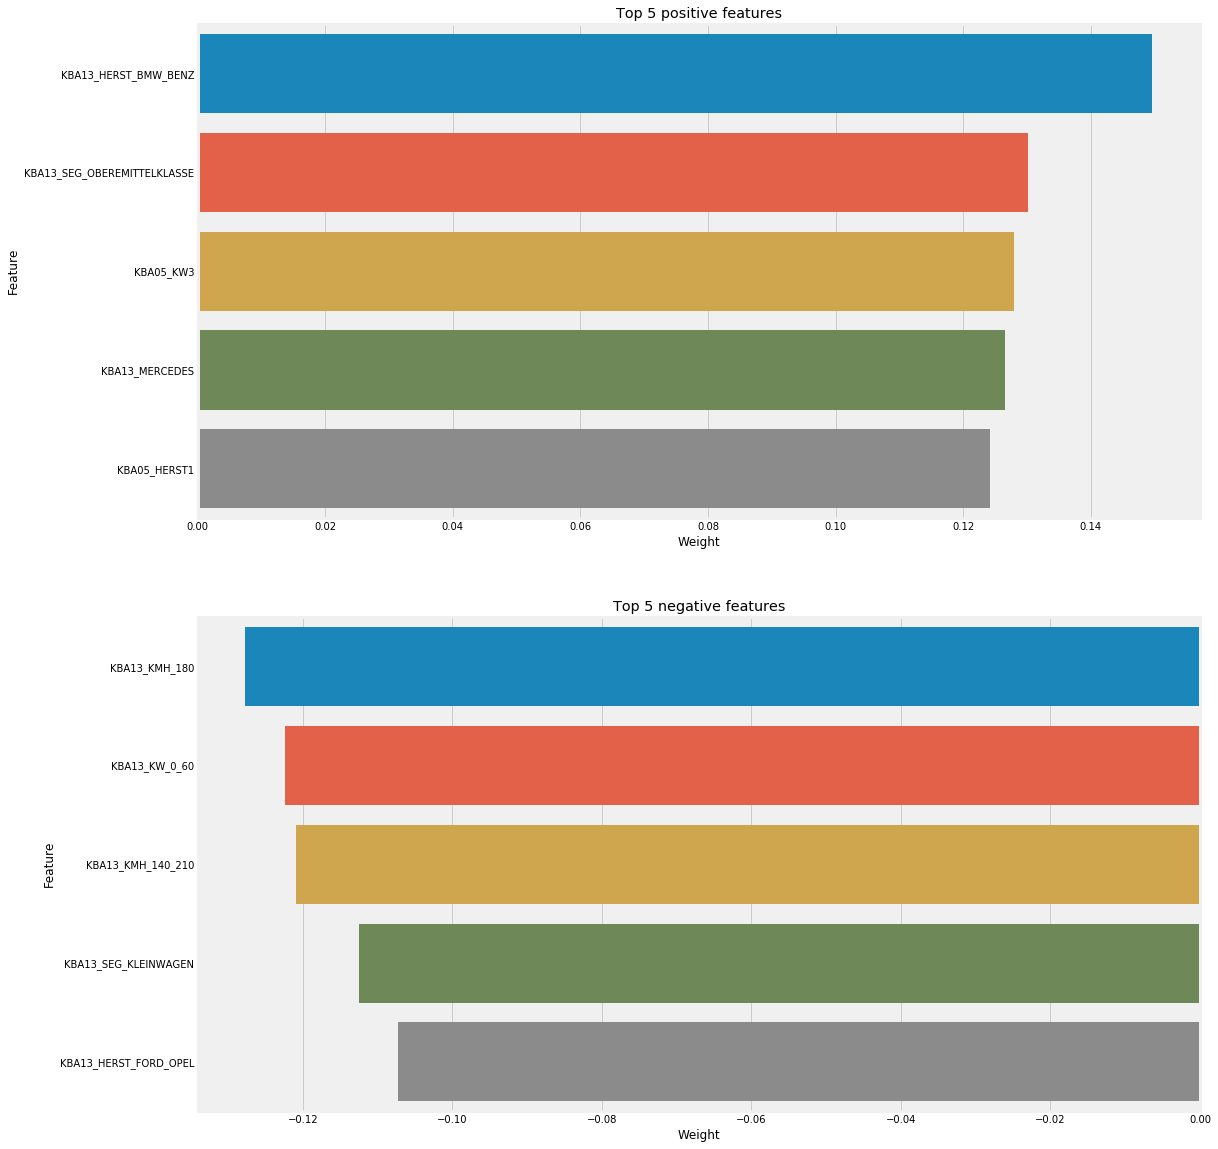

In [200]:
# Map weights for the first principal component to corresponding feature names

analyze_component(customers_ss, pca_c, 1, top=5)

#### 3rd component

It is similiar to `azdias` 2nd component. It is all about size family, positive attributes are about large families, while negative about small famililies with low finiancial interest.

top 5 positive
D19_GESAMT_ANZ_24             : transaction activity TOTAL POOL in the last 24 months 
PLZ8_ANTG3                    : number of 6-10 family houses in the PLZ8
D19_GESAMT_ANZ_12             : transaction activity TOTAL POOL in the last 12 months 
D19_VERSAND_ANZ_24            : transaction activity MAIL-ORDER in the last 24 months
PLZ8_ANTG4                    : number of >10 family houses in the PLZ8
top 5 negative
PLZ8_BAUMAX_size_1-2          : not found
PLZ8_ANTG1                    : number of 1-2 family houses in the PLZ8
FINANZ_MINIMALIST             : financial typology: low financial interest
MOBI_REGIO                    : moving patterns
KBA13_AUTOQUOTE               : share of cars per household within the PLZ8


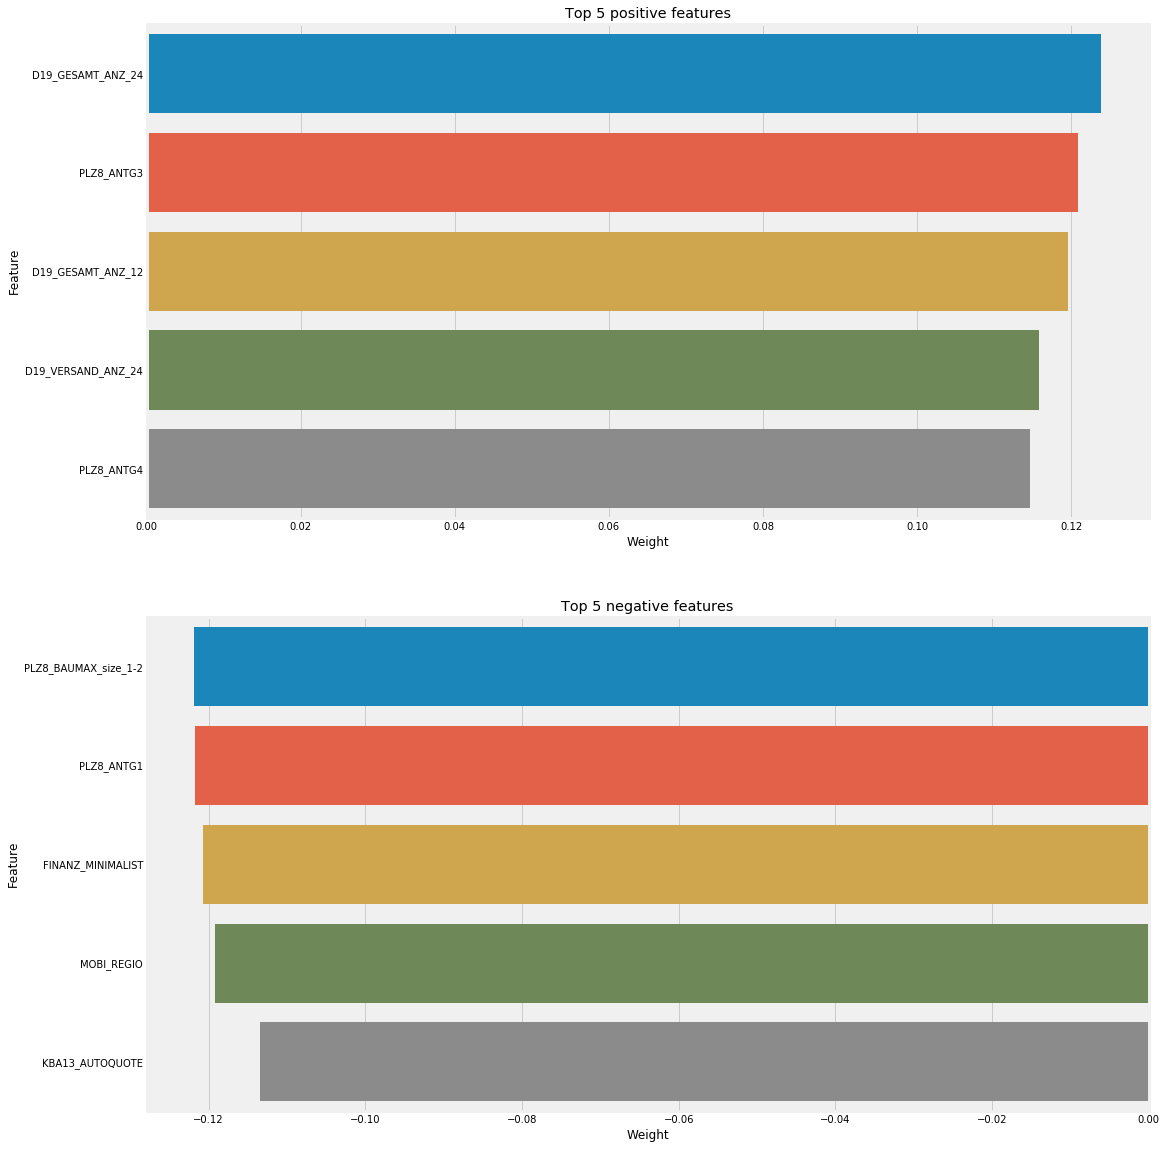

In [201]:
# Map weights for the first principal component to corresponding feature names

analyze_component(customers_ss, pca_c, 2, top=5)

### 1.4 Clustering

#### 1.4.1. How many K clusters to use?

In [ ]:
%%time

# Over a number of different cluster counts...
centroids = [10, 15, 20, 25, 30]
k_scores = list()
for c in centroids:

    # run k-means clustering on the data and...
    kmeans = KMeans(c)
    model = kmeans.fit(azdias_pca)
    
    # compute the average within-cluster distances on random samples of data
    scores = list()
    for _ in range(10000):
        azdias_sample = azdias_pca[np.random.choice(azdias_pca.shape[0], 10000, replace=False), :]
        k_s = kmeans.score(azdias_sample)
        scores.append(abs(k_s))
    k_scores.append(scores)  

# for ploting
centroids = ["KMean_"+str(_) for _ in centroids]

In [ ]:
# Visualize the change in within-cluster distance across number of clusters.

df_temp = pd.DataFrame(np.array(k_scores).T, columns= centroids[:4])
df_temp.boxplot(figsize=(16, 6))
plt.ylabel("Score");

In [202]:
azdias_pca = pca_a.fit_transform(azdias_ss)
customers_pca = pca_a.fit_transform(customers_ss)

#### 1.4.2 Fit both DataFrames with 15 clusters

In [203]:
%%time

# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(15)
model = kmeans.fit(azdias_pca)

Wall time: 58min 45s


Save model for future use.

In [206]:
%%time

# save model
import pickle
filename = 'kmeans_model_20190317.sav'
# pickle.dump(model, open(filename, 'wb'))
kmeans = pickle.load(open(filename, 'rb'))

Wall time: 4.62 ms


In [207]:
%%time

# get labels with fitted KMeans model
azdias_labels = kmeans.predict(azdias_pca)
customer_labels = kmeans.predict(customers_pca)

Wall time: 6.86 s


In [208]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# create dataframes with cluster labels for Azdias and customers
azdias_Kmeans = pd.DataFrame(azdias_labels, columns=["Label"])
customer_Kmeans = pd.DataFrame(customer_labels, columns=["Label"])
azdias_size = azdias_labels.shape[0]
customer_size = customer_labels.shape[0]
# count clusters and join them in new dataframe
s1 = azdias_Kmeans["Label"].value_counts() / azdias_size
s2 = customer_Kmeans["Label"].value_counts() / customer_size
clusters_df = pd.DataFrame(dict(Azdias = s1, Customers = s2)).reset_index()
clusters_df = clusters_df.rename(columns={"index": "cluster"})

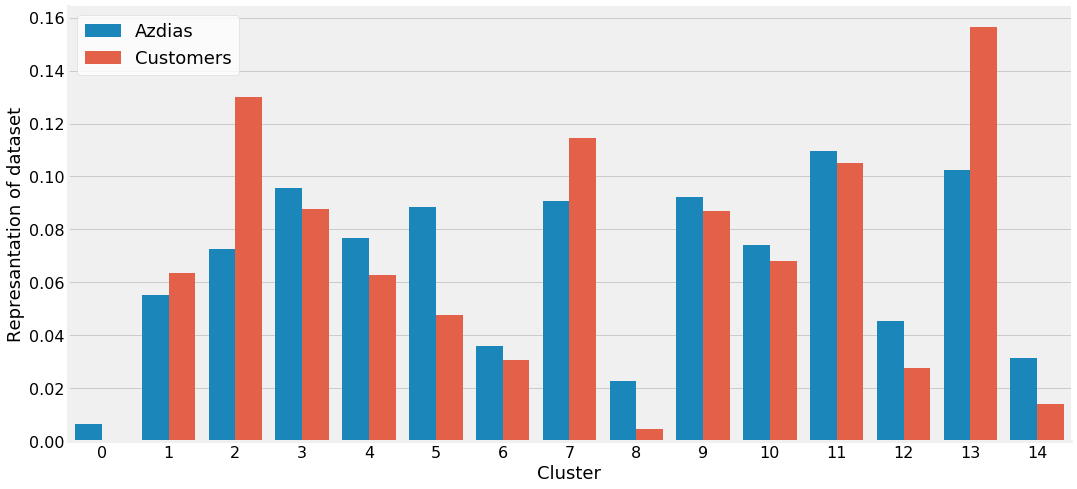

In [209]:
# visualize proportion
fig, ax1 = plt.subplots(figsize=(16, 8))
tidy = (
    clusters_df.set_index('cluster')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'DataFrame', 0: 'Represantation of dataset (%)'})
)
sns.barplot(x='cluster', y='Represantation of dataset (%)', hue='DataFrame', data=tidy, ax=ax1)
sns.despine(fig)
# ax1.legend();
legend = plt.legend(frameon = 1, fontsize=18)
frame = legend.get_frame()
frame.set_facecolor('w')

plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
ax1.set_ylabel("Represantation of dataset", fontsize=18)
ax1.set_xlabel("Cluster", fontsize=18);

plt.savefig("clusters.png", facecolor='w', dpi=96)

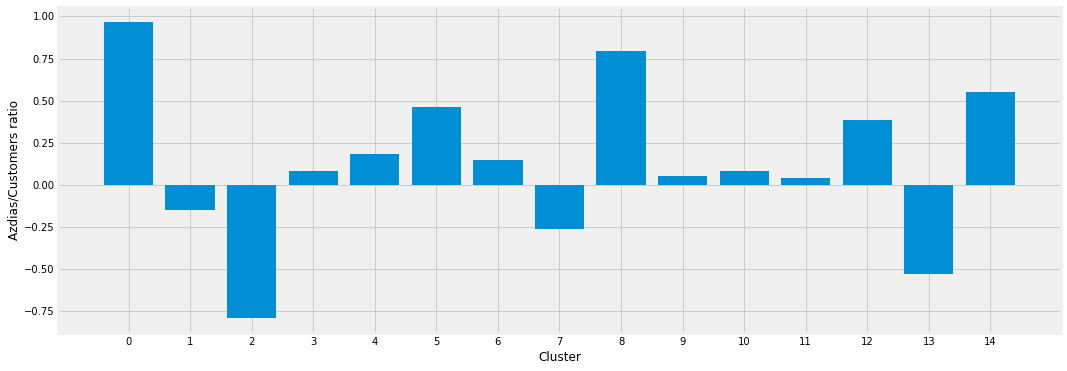

In [210]:
# check ratio between azdias and customers DataFrames
clusters_df["ratio"] = (clusters_df["Azdias"] - clusters_df["Customers"]) / clusters_df["Azdias"]

plt.figure(figsize=(16, 6))
plt.bar(clusters_df.cluster.values, clusters_df.ratio.values, align='center');
plt.ylabel("Azdias/Customers ratio");
plt.xlabel("Cluster")
plt.xticks([x for x in range(15)]);

In [211]:
# helper function
def get_meanings(df_attr, attribute_name):
    """
    Prints out attribute meanings
    Input:
        df_attr: pandas DataFrame,
        attribute_name: str, attribute name
    Output:
        print out meanings and values of spesific attribute
    """
    try:
        values = df_attr[df_attr.Attribute == attribute_name].Values.values[0]
        meanings = df_attr[df_attr.Attribute == attribute_name].Meanings.values[0]
        
        print(f'{attribute_name:25s}: {meanings}')
        print("_"*25 + f': {values}')
    except:
        meanings = "attribute not found"
        print(f'{attribute_name:25s}: {meanings}')

#### 1.4.4 Analyze clusters

Customer's data set has over-representation of clusters 2 and 4, while under-representation  comes from clusters 0 and 10.

#### Cluster 2

This cluster indicates that customers of a mail-order sales company in Germany have more expensive cars:

* `KBA05_HERST1` most common car segment in the microcell is upper class car,
* `EWDICHTE` density of inhabitants per square kilometer.

Negative weights come from having a car with small engine.

In [389]:
# inverse transform Kmean centers
centers = pca_a.inverse_transform(kmeans.cluster_centers_)

# most overrepresented feature in customer data set is Clester #2
df_temp = pd.DataFrame(centers[2,:])
df_temp.columns= ["Weight"]
df_temp["Column_name"] = azdias_ss.columns.values
df_temp.nlargest(10, 'Weight')

,Weight,Column_name
126,1.010955,KBA05_HERST1
139,0.922019,KBA05_KW3
48,0.891234,KBA05_MOTOR
16,0.883282,KBA05_KRSHERST1
102,0.875419,KBA05_MAXSEG
155,0.838088,KBA13_HERST_BMW_BENZ
216,0.802032,KBA05_MOD1
103,0.800599,KBA05_SEG5
68,0.791319,EWDICHTE
651,0.789727,KBA05_MAXHERST_1.0


In [390]:
df_temp.nsmallest(10, 'Weight')

,Weight,Column_name
47,-1.075365,KBA05_KW1
145,-0.937264,KBA05_CCM1
39,-0.875283,KBA05_SEG2
88,-0.819391,KBA13_KW_0_60
201,-0.786250,KBA13_HALTER_50
373,-0.778678,LP_STATUS_FEIN_9.0
26,-0.769297,KBA13_ALTERHALTER_60
118,-0.757804,KBA05_KRSKLEIN
61,-0.751116,KBA13_KMH_180
129,-0.745023,KBA05_MOD4


EWDICHTE                      : density of inhabitants per square kilometer
EWDICHTE                 : ['unknown', 'less than 34 HH/km²', '34 - 89 HH/km²', '90 - 149 HH/km²', '150 - 319 HH/km²', '320 - 999 HH/km²', 'more than 999 HH/²']
_________________________: [-1, 1, 2, 3, 4, 5, 6]


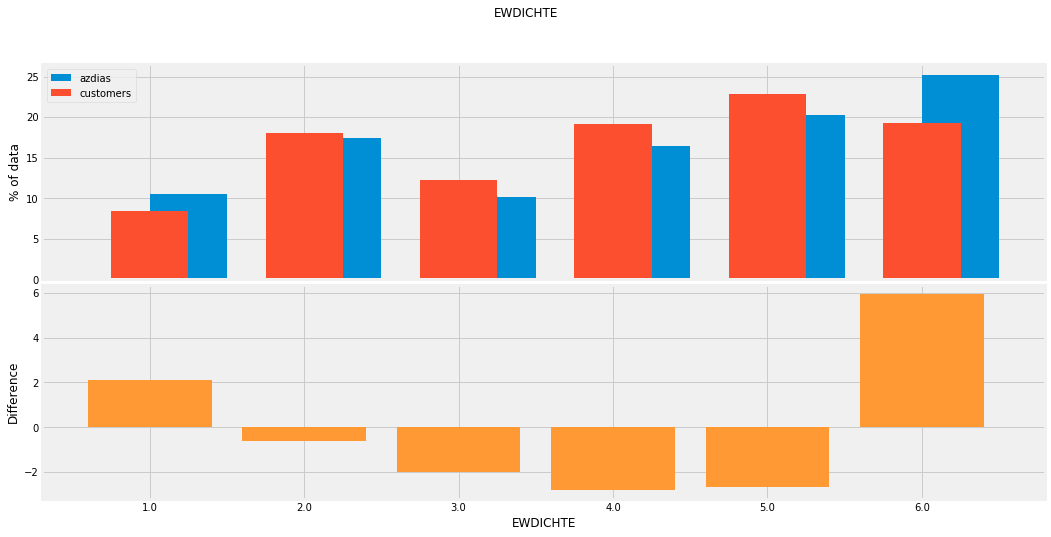

In [400]:
attribute_name = "EWDICHTE"
get_description(df_attr_p, attribute_name)
plot_attribute(azdias_7, customers_7, attribute_name)
# plot_attribute(azdias_9, customers_9, attribute_name)
get_meanings(df_attr_p, attribute_name)

#### plot figure for segmentation report

In [374]:
def create_attr_dataframe(attribute_name, azdias=azdias_9, customers=customers_9):
    # select data with attribute name
    _1 = azdias[attribute_name]
    # sort by index
    _1 = _1.value_counts().sort_index() / _1.shape[0] * 100
    df_1 = pd.DataFrame(_1)
    df_1['index'] = df_1.index
    df_1['Type'] = 'azdias'

    # select data with attribute name
    _2 = customers[attribute_name]
    # sort by index
    _2 = _2.value_counts().sort_index() / _2.shape[0] * 100

    df_2 = pd.DataFrame(_2)
    df_2['index'] = df_2.index
    df_2['Type'] = 'customer'

    # join dataFrames
    df_ = pd.concat([df_1, df_2])
    return df_

df_ = create_attr_dataframe("KBA05_MAXSEG", azdias=azdias_9, customers=customers_9)
df_

,KBA05_MAXSEG,index,Type
1.0,25.634950,1.0,azdias
2.0,37.811345,2.0,azdias
3.0,21.732108,3.0,azdias
4.0,8.738392,4.0,azdias
1.0,24.060796,1.0,customer
2.0,37.269281,2.0,customer
3.0,22.396070,3.0,customer
4.0,11.925687,4.0,customer


C:\Users\Tomas\PycharmProjects\nano_degree_DS\venv\lib\site-packages\pandas\core\indexes\base.py:3078: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


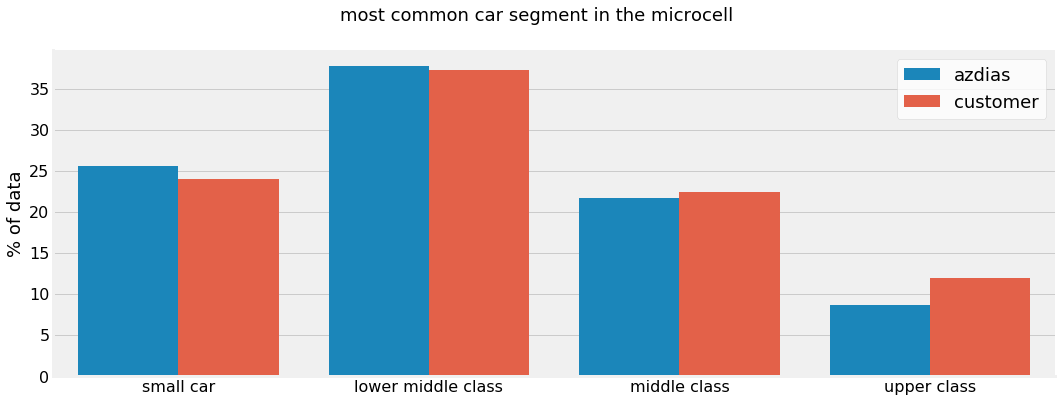

In [375]:
# create figure and axis objects
fig, ax1 = plt.subplots(figsize=(16, 6), sharex='col')
# figure title
fig.suptitle(f"most common car segment in the microcell", fontsize=18)

sns.barplot(x='index', y='KBA05_MAXSEG', hue='Type', data=df_, ax=ax1)
sns.despine(fig)


# add legend and labels to plots
legend = plt.legend(frameon = 1, fontsize=18)
frame = legend.get_frame()
frame.set_facecolor('w')

ax1.set_ylabel("% of data", fontsize=18)
plt.xticks([0.0, 1, 2, 3], ['small car', 'lower middle class', 'middle class', 'upper class'], fontsize=18);
ax1.set_xlabel("");
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.savefig("car_segment.png", facecolor='w', dpi=96)

In [378]:
df_ = create_attr_dataframe("KBA05_MOTOR", azdias=azdias_9, customers=customers_9)
df_

,KBA05_MOTOR,index,Type
1.0,15.303118,1.0,azdias
2.0,28.072124,2.0,azdias
3.0,36.633200,3.0,azdias
4.0,13.908352,4.0,azdias
1.0,10.173643,1.0,customer
2.0,22.778709,2.0,customer
3.0,41.427902,3.0,customer
4.0,21.271581,4.0,customer


C:\Users\Tomas\PycharmProjects\nano_degree_DS\venv\lib\site-packages\pandas\core\indexes\base.py:3078: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


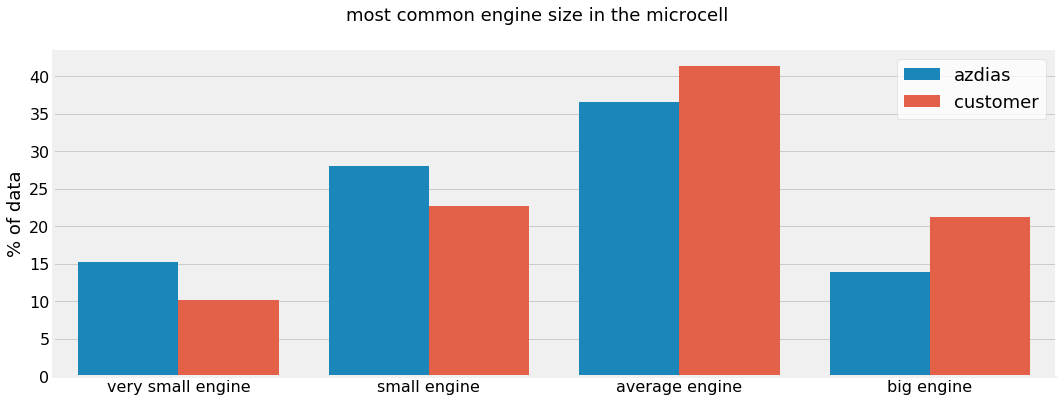

In [377]:
attribute_name = "KBA05_MAXSEG"
# create figure and axis objects
fig, ax1 = plt.subplots(figsize=(16, 6), sharex='col')
# figure title
fig.suptitle(f"most common engine size in the microcell", fontsize=18)

sns.barplot(x='index', y='KBA05_MOTOR', hue='Type', data=df_, ax=ax1)
sns.despine(fig)


# add legend and labels to plots
legend = plt.legend(frameon = 1, fontsize=18)
frame = legend.get_frame()
frame.set_facecolor('w')

ax1.set_ylabel("% of data", fontsize=18)
plt.xticks([0, 1, 2, 3], ['very small engine', 'small engine', 'average engine', 'big engine'], fontsize=18);
ax1.set_xlabel("");
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.savefig("engine_size.png", facecolor='w', dpi=96)

#### Cluster 13

This cluster indicates that customers of a mail-order sales company are:

* `KBA13_ALTERHALTER_60`, `KBA13_HALTER_55` older car owners,
* `KBA13_AUTOQUOTE`, `KBA13_OPEL` who don't drive cheaper cars, 

In [396]:
# inverse transform Kmean centers
centers = pca_a.inverse_transform(kmeans.cluster_centers_)

# most overrepresented feature in customer data set is Clester #2
df_temp = pd.DataFrame(centers[13,:])
df_temp.columns= ["Weight"]
df_temp["Column_name"] = azdias_ss.columns.values
df_temp.nlargest(10, 'Weight')

,Weight,Column_name
26,0.940445,KBA13_ALTERHALTER_60
161,0.879989,KBA13_HALTER_55
201,0.841312,KBA13_HALTER_50
208,0.821467,KBA13_HERST_FORD_OPEL
150,0.788412,KBA13_AUTOQUOTE
61,0.774536,KBA13_KMH_180
196,0.731176,MOBI_REGIO
36,0.717742,KBA13_KMH_140_210
109,0.704514,KBA13_OPEL
88,0.694761,KBA13_KW_0_60


In [430]:
df_temp.nsmallest(10, 'Weight')

,Weight,Column_name
68,-1.678102,EWDICHTE
37,-1.547138,ORTSGR_KLS9
665,-1.504566,D19_VERSAND_OFFLINE_DATUM_10
383,-1.496861,KBA05_HERSTTEMP_3.0
243,-1.474561,D19_GESAMT_OFFLINE_DATUM_10
653,-1.355711,KBA05_MAXHERST_3.0
176,-1.311284,RELAT_AB
394,-1.289013,D19_HAUS_DEKO_RZ_0
49,-1.281934,KBA05_HERST3
602,-1.276150,D19_TELKO_MOBILE_RZ_0


MOBI_REGIO                    : moving patterns
MOBI_REGIO               : ['very high mobility', 'high mobility', 'middle mobility', 'low mobility', 'very low mobility ', 'none']
_________________________: [1, 2, 3, 4, 5, 6]


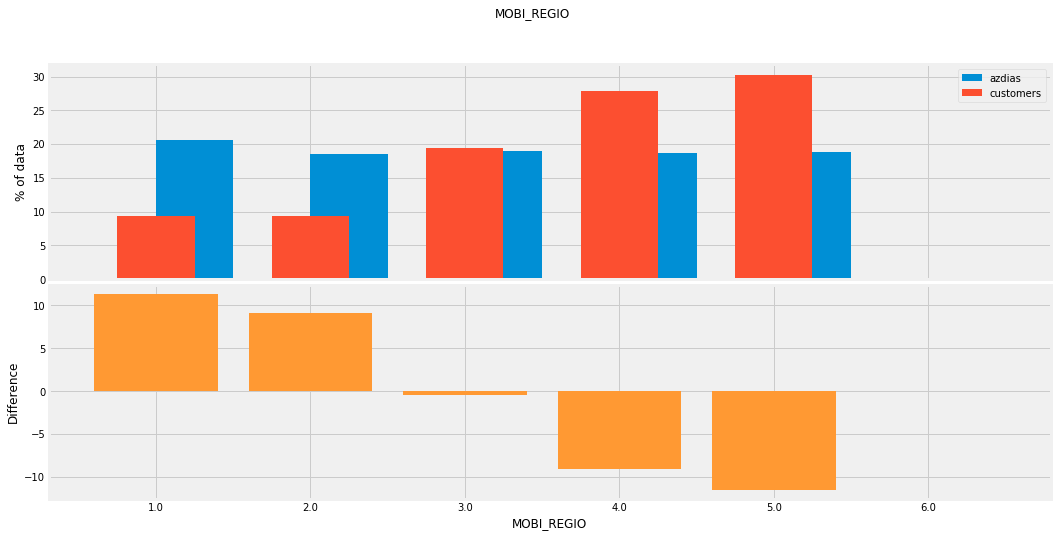

In [431]:
attribute_name = "MOBI_REGIO"
get_description(df_attr_p, attribute_name)
plot_attribute(azdias_9, customers_9, attribute_name)
get_meanings(df_attr_p, attribute_name)

In [404]:
df_temp.nsmallest(10, 'Weight')

,Weight,Column_name
55,-1.756643,KBA05_KRSHERST3
206,-1.730486,HH_EINKOMMEN_SCORE
253,-1.692139,D19_BANKEN_ONLINE_DATUM_10
49,-1.540002,KBA05_HERST3
277,-1.455338,D19_BANKEN_DATUM_10
653,-1.427730,KBA05_MAXHERST_3.0
189,-1.297915,KBA13_BJ_2000
96,-1.296126,FINANZ_HAUSBAUER
412,-1.288828,KBA05_ANTG1_0.0
365,-1.239412,LP_STATUS_FEIN_1.0


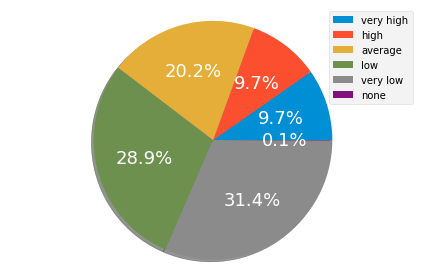

In [244]:
# calculate procentages for single and multibuyers
_ = customers_9["MOBI_REGIO"].value_counts().sort_index() / customers_9["MOBI_REGIO"].size * 100



patches, texts, autotexts = plt.pie(_.values, shadow=True, autopct='%1.1f%%', startangle=0)
for autotext in autotexts:
    autotext.set_color('w')
    autotext.set_fontsize(18)
    
# plt.title("Customer type")
plt.legend(patches, ["very high", "high", "average", "low", "very low", "none"], loc="best")
plt.axis('equal')
plt.tight_layout()
plt.savefig("mobility_customers.png", facecolor='w', dpi=96)

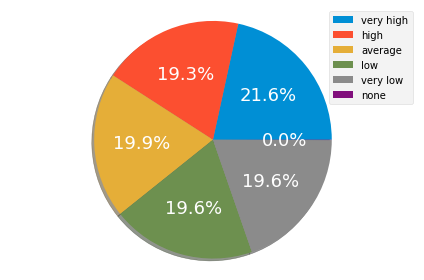

In [245]:
# calculate procentages for single and multibuyers
_ = azdias_9["MOBI_REGIO"].value_counts().sort_index() / azdias_9["MOBI_REGIO"].size * 100

patches, texts, autotexts = plt.pie(_.values, shadow=True, autopct='%1.1f%%', startangle=0)
for autotext in autotexts:
    autotext.set_color('w')
    autotext.set_fontsize(18)
    
# plt.title("Customer type")
plt.legend(patches, ["very high", "high", "average", "low", "very low", "none"], loc="best")
plt.axis('equal')
plt.tight_layout()
plt.savefig("mobility_azdias.png", facecolor='w', dpi=96)

In [241]:
azdias_9["MOBI_REGIO"].value_counts().sort_index()

1.0    163383
2.0    146240
3.0    150296
4.0    148197
5.0    148700
6.0       338
Name: MOBI_REGIO, dtype: int64

#### Cluster 8

This cluster indicates that customers of a mail-order sales company are:

* `LP_LEBENSPHASE_FEIN_income_high` wealthy people,
*

In [405]:
# inverse transform Kmean centers
centers = pca_a.inverse_transform(kmeans.cluster_centers_)

# most overrepresented feature in customer data set is Clester #2
df_temp = pd.DataFrame(centers[8,:])
df_temp.columns= ["Weight"]
df_temp["Column_name"] = azdias_ss.columns.values
df_temp.nlargest(10, 'Weight')

,Weight,Column_name
7,1.887300,GREEN_AVANTGARDE
821,1.887300,PRAEGENDE_JUGENDJAHRE_movement
53,1.671607,ONLINE_AFFINITAET
845,1.555141,LP_LEBENSPHASE_FEIN_income_high
374,1.545073,LP_STATUS_FEIN_10.0
181,1.533228,D19_GESAMT_ANZ_24
91,1.443773,D19_BANKEN_ANZ_24
43,1.395761,KBA13_VORB_0
828,1.393631,CAMEO_DEUINTL_2015_wealth_1.0
92,1.346251,D19_VERSAND_ANZ_24


In [407]:
df_temp.nsmallest(10, 'Weight')

,Weight,Column_name
55,-1.756643,KBA05_KRSHERST3
206,-1.730486,HH_EINKOMMEN_SCORE
253,-1.692139,D19_BANKEN_ONLINE_DATUM_10
49,-1.540002,KBA05_HERST3
277,-1.455338,D19_BANKEN_DATUM_10
653,-1.427730,KBA05_MAXHERST_3.0
189,-1.297915,KBA13_BJ_2000
96,-1.296126,FINANZ_HAUSBAUER
412,-1.288828,KBA05_ANTG1_0.0
365,-1.239412,LP_STATUS_FEIN_1.0


In [432]:
get_description(df_attr_p, "HH_EINKOMMEN_SCORE")
get_meanings(df_attr_p, "HH_EINKOMMEN_SCORE")

HH_EINKOMMEN_SCORE            : estimated household net income 
HH_EINKOMMEN_SCORE       : ['unknown', 'highest income', 'very high income', 'high income', 'average income', 'lower income', 'very low income']
_________________________: ['-1, 0', 1, 2, 3, 4, 5, 6]


KBA13_VORB_0                  : share of cars with no preowner - PLZ8
KBA13_VORB_0             : ['unknown', 'none', 'very low', 'low', 'average', 'high', 'very high']
_________________________: [-1, 0, 1, 2, 3, 4, 5]


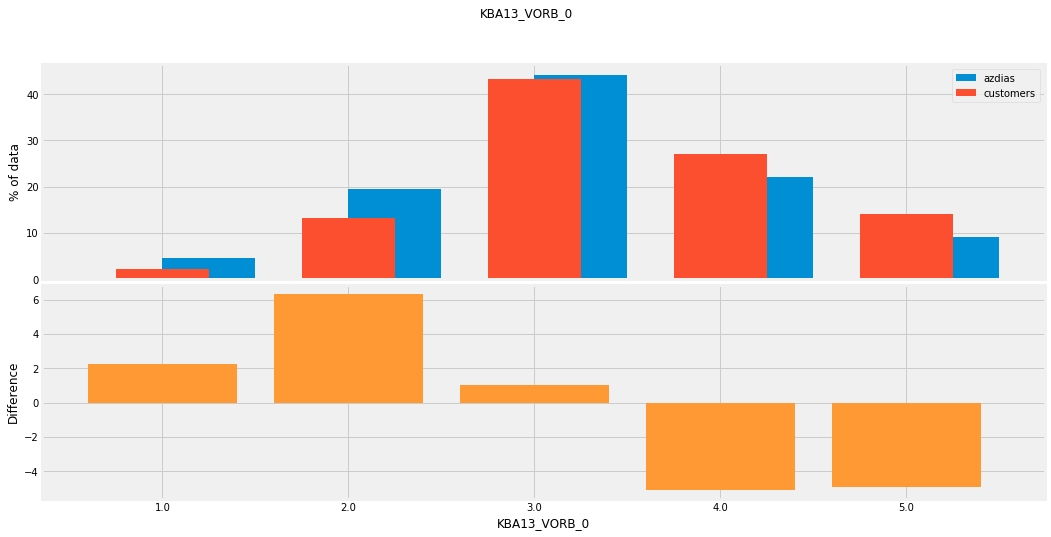

In [435]:
attribute_name = "KBA13_VORB_0"
get_description(df_attr_p, attribute_name)
plot_attribute(azdias_9, customers_9, attribute_name)
get_meanings(df_attr_p, attribute_name)

In [ ]:
azdias_9["GREEN_AVANTGARDE"].value_counts()

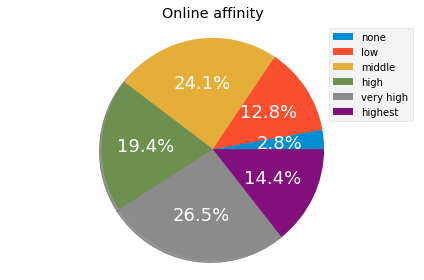

In [265]:
# calculate procentages for single and multibuyers
_ = customers_9["ONLINE_AFFINITAET"].value_counts().sort_index() / customers_9["ONLINE_AFFINITAET"].size * 100


patches, texts, autotexts = plt.pie(_.values, shadow=True, autopct='%1.1f%%', startangle=0)
for autotext in autotexts:
    autotext.set_color('w')
    autotext.set_fontsize(18)
    
plt.title("Online affinity")
plt.legend(patches, ["none", "low", "middle", "high", "very high", "highest"], loc="best")
plt.axis('equal')
plt.tight_layout()
plt.savefig("online_affinity_c.png", facecolor='w', dpi=96)

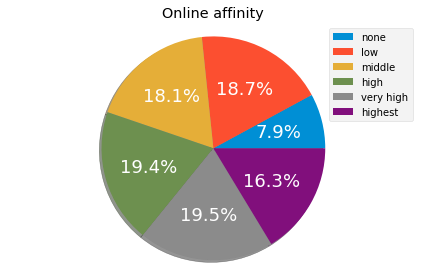

In [264]:
# calculate procentages for single and multibuyers
_ = azdias_9["ONLINE_AFFINITAET"].value_counts().sort_index() / azdias_9["ONLINE_AFFINITAET"].size * 100


patches, texts, autotexts = plt.pie(_.values, shadow=True, autopct='%1.1f%%', startangle=0)
for autotext in autotexts:
    autotext.set_color('w')
    autotext.set_fontsize(18)
    
plt.title("Online affinity")
plt.legend(patches, ["none", "low", "middle", "high", "very high", "highest"], loc="best")
plt.axis('equal')
plt.tight_layout()
plt.savefig("online_affinity_a.png", facecolor='w', dpi=96)

In [258]:
azdias_9["ONLINE_AFFINITAET"].value_counts().sort_index()

0.0     62269
1.0    147320
2.0    142554
3.0    152418
4.0    153466
5.0    128511
Name: ONLINE_AFFINITAET, dtype: int64

In [255]:
customers_9["GREEN_AVANTGARDE"].value_counts().sort_index()

0    70648
1    70216
Name: GREEN_AVANTGARDE, dtype: int64

In [ ]:
## plot pie chart for segmentation report.


# calculate procentages for single and multibuyers
_ = customers_special['CUSTOMER_GROUP'].value_counts() / customers_special['CUSTOMER_GROUP'].size * 100

patches, texts, autotexts = plt.pie(_.values, shadow=True, autopct='%1.1f%%', startangle=90)
for autotext in autotexts:
    autotext.set_color('w')
    autotext.set_fontsize(18)
    
# plt.title("Customer type")
# plt.legend(patches, ["Multi", "Single"], loc="best")
plt.axis('equal')
plt.tight_layout()
# plt.savefig("green_avantgarde.png", facecolor='w', dpi=96)

#### Cluster 14

This cluster indicates that customers of a mail-order sales company are:

* 

In [421]:
# inverse transform Kmean centers
centers = pca_a.inverse_transform(kmeans.cluster_centers_)

# most overrepresented feature in customer data set is Clester #2
df_temp = pd.DataFrame(centers[14,:])
df_temp.columns= ["Weight"]
df_temp["Column_name"] = azdias_ss.columns.values
df_temp.nlargest(10, 'Weight')

,Weight,Column_name
147,1.953957,KBA13_HERST_AUDI_VW
34,1.905919,KBA05_HERST2
50,1.764694,KBA13_VW
652,1.692904,KBA05_MAXHERST_2.0
2,1.637993,ANZ_PERSONEN
854,1.624054,WOHNLAGE_score_rular
859,1.606504,WOHNLAGE_score_unknown
663,1.606481,D19_VERSAND_OFFLINE_DATUM_8
840,1.545256,LP_LEBENSPHASE_FEIN_type_multi
182,1.499938,KBA05_KRSHERST2


In [422]:
df_temp.nsmallest(10, 'Weight')

,Weight,Column_name
68,-1.678102,EWDICHTE
37,-1.547138,ORTSGR_KLS9
665,-1.504566,D19_VERSAND_OFFLINE_DATUM_10
383,-1.496861,KBA05_HERSTTEMP_3.0
243,-1.474561,D19_GESAMT_OFFLINE_DATUM_10
653,-1.355711,KBA05_MAXHERST_3.0
176,-1.311284,RELAT_AB
394,-1.289013,D19_HAUS_DEKO_RZ_0
49,-1.281934,KBA05_HERST3
602,-1.276150,D19_TELKO_MOBILE_RZ_0


In [271]:
get_description(df_attr_p, "KBA05_HERSTTEMP")
get_meanings(df_attr_p, "KBA05_HERSTTEMP")

KBA05_HERSTTEMP               : development of the most common car manufacturers in the neighbourhood
KBA05_HERSTTEMP          : ['unknown', 'promoted', 'stayed upper level', 'stayed lower/average level', 'demoted', 'new building']
_________________________: ['-1, 9', 1, 2, 3, 4, 5]


EWDICHTE                      : density of inhabitants per square kilometer
EWDICHTE                 : ['unknown', 'less than 34 HH/km²', '34 - 89 HH/km²', '90 - 149 HH/km²', '150 - 319 HH/km²', '320 - 999 HH/km²', 'more than 999 HH/²']
_________________________: [-1, 1, 2, 3, 4, 5, 6]


Text(0.5,0,'tes')

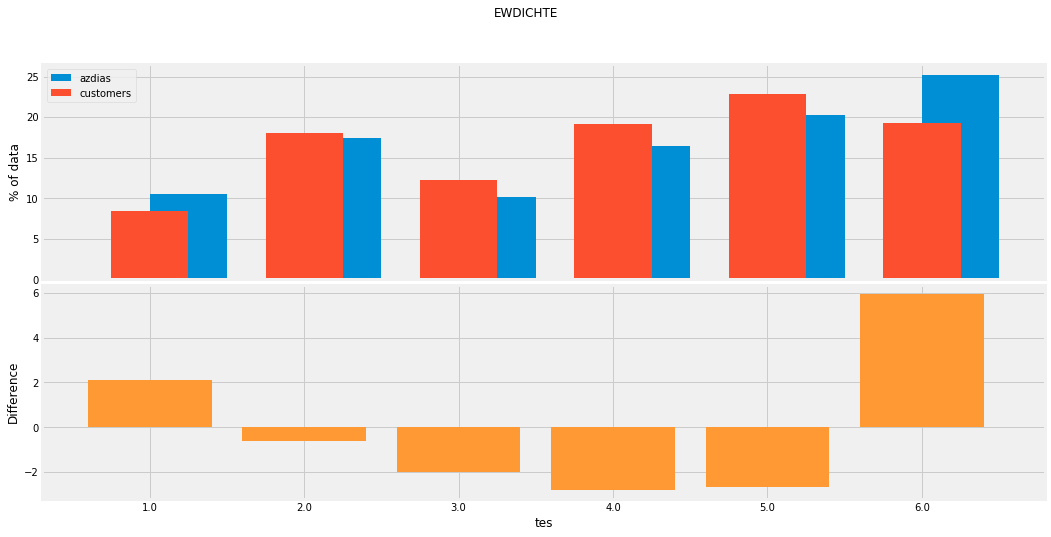

In [273]:
attribute_name = "EWDICHTE"
get_description(df_attr_p, attribute_name)
plot_attribute(azdias_9, customers_9, attribute_name)
get_meanings(df_attr_p, attribute_name)
plt.xlabel("test")

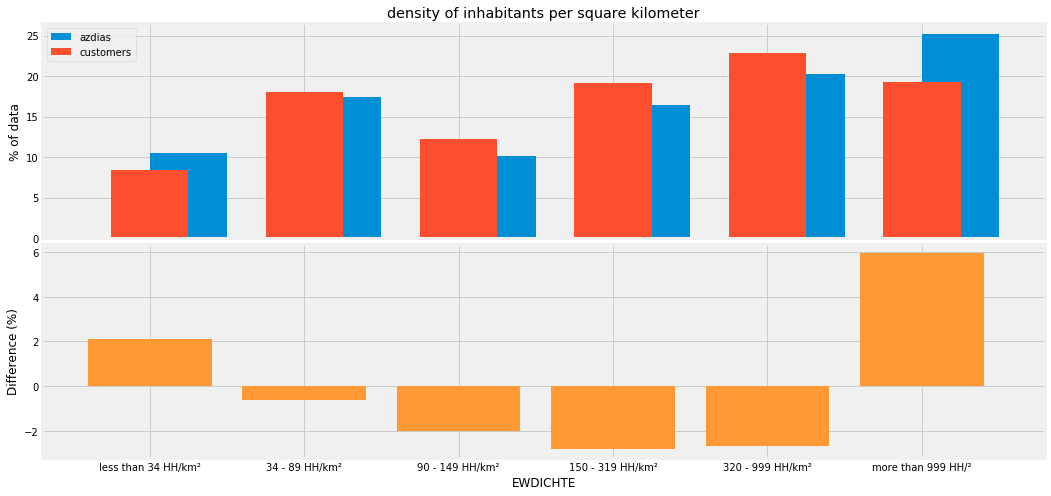

In [281]:
attribute_name = "EWDICHTE"

# create figure and axis objects
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex='col')
# figure title
# fig.suptitle(attribute_name)

# select data with attribute name
_1 = azdias_9[attribute_name]
# sort by index
_1 = _1.value_counts().sort_index() / _1.shape[0] * 100
# convert x-axis to string to avoid spacing
ax1.bar(_1.index.astype(str), _1.values, width=0.5, align='edge', label="azdias")
# select data with attribute name
_2 = customers_9[attribute_name]
# sort by index
_2 = _2.value_counts().sort_index() / _2.shape[0] * 100

ax1.bar(_2.index.astype(str), _2.values, width=0.5, label="customers")

# calculate procentage difference
_diff = _1 - _2

# plot procentage difference
ax2.bar(_diff.index.astype(str), _diff.values, color="#ff9933")

# add legend and labels to plots
ax1.legend()
ax1.set_title("density of inhabitants per square kilometer")
ax2.set_xlabel(attribute_name)
ax1.set_ylabel("% of data")
ax2.set_ylabel("Difference (%)")
ax2.set_xticklabels(["less than 34 HH/km²", "34 - 89 HH/km²", "90 - 149 HH/km²",
                     "150 - 319 HH/km²", "320 - 999 HH/km²", "more than 999 HH/²"])
# create small gap between plots
plt.subplots_adjust(hspace=0.025)

plt.savefig("pop_density.png", facecolor='w', dpi=96)

# OLD STUFF

#### 1.4.4 Analyze clusters

Customer's data set has over-representation of clusters 2 and 4, while under-representation  comes from clusters 0 and 10.

#### Cluster 7

This cluster indicates that customers of a mail-order sales company in Germany have more expensive cars:

* `KBA05_HERST1` most common car segment in the microcell is upper class car,
* `EWDICHTE` density of inhabitants per square kilometer, 

In [226]:
# inverse transform Kmean centers
centers = pca_a.inverse_transform(kmeans.cluster_centers_)

# most overrepresented feature in customer data set is Clester #2
df_temp = pd.DataFrame(centers[7,:])
df_temp.columns= ["Weight"]
df_temp["Column_name"] = azdias_ss.columns.values
df_temp = df_temp.nlargest(10, 'Weight')
df_temp

,Weight,Column_name
179,0.998104,KBA05_MAXSEG
163,0.997765,KBA05_HERST1
147,0.917621,KBA05_KW3
40,0.910205,KBA05_MOTOR
222,0.896985,KBA05_KRSHERST1
83,0.823556,KBA05_SEG5
218,0.812129,KBA05_MOD1
786,0.791954,KBA05_MAXHERST_1.0
194,0.783094,EWDICHTE
118,0.782563,KBA13_ALTERHALTER_61


EWDICHTE                      : density of inhabitants per square kilometer
EWDICHTE                 : ['unknown', 'less than 34 HH/km²', '34 - 89 HH/km²', '90 - 149 HH/km²', '150 - 319 HH/km²', '320 - 999 HH/km²', 'more than 999 HH/²']
_________________________: [-1, 1, 2, 3, 4, 5, 6]


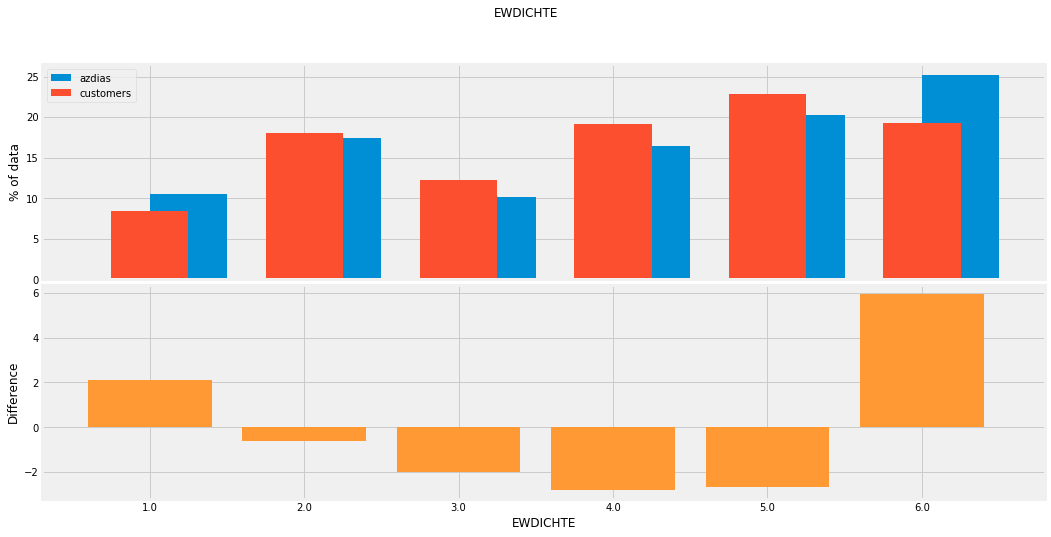

In [232]:
attribute_name = "EWDICHTE"
get_description(df_attr_p, attribute_name)
plot_attribute(azdias_9, customers_9, attribute_name)
get_meanings(df_attr_p, attribute_name)

In [228]:
for _ in df_temp.values:
    get_description(df_attr_p, _[1])

# print not found columns
get_description(df_attr_p, "KBA05_MAXHERST")

KBA05_MAXSEG                  : most common car segment in the microcell
KBA05_HERST1                  : share of top German manufacturer (Mercedes, BMW) 
KBA05_KW3                     : share of cars with an engine power of more than 119 KW
KBA05_MOTOR                   : most common engine size in the microcell
KBA05_KRSHERST1               : share of Mercedes/BMW (reffered to the county average)
KBA05_SEG5                    : share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)
KBA05_MOD1                    : share of upper class cars (in an AZ specific definition)
KBA05_MAXHERST_1.0            : not found
EWDICHTE                      : density of inhabitants per square kilometer
KBA13_ALTERHALTER_61          : share of car owners elder than 61 within the PLZ8
KBA05_MAXHERST                : most common car manufacturer in the microcell


KBA05_MAXSEG                  : most common car segment in the microcell
KBA05_MAXSEG             : ['unknown', 'small car', 'lower middleclass car', 'middle class car', 'upper class car']
_________________________: ['-1, 9', 1, 2, 3, 4]


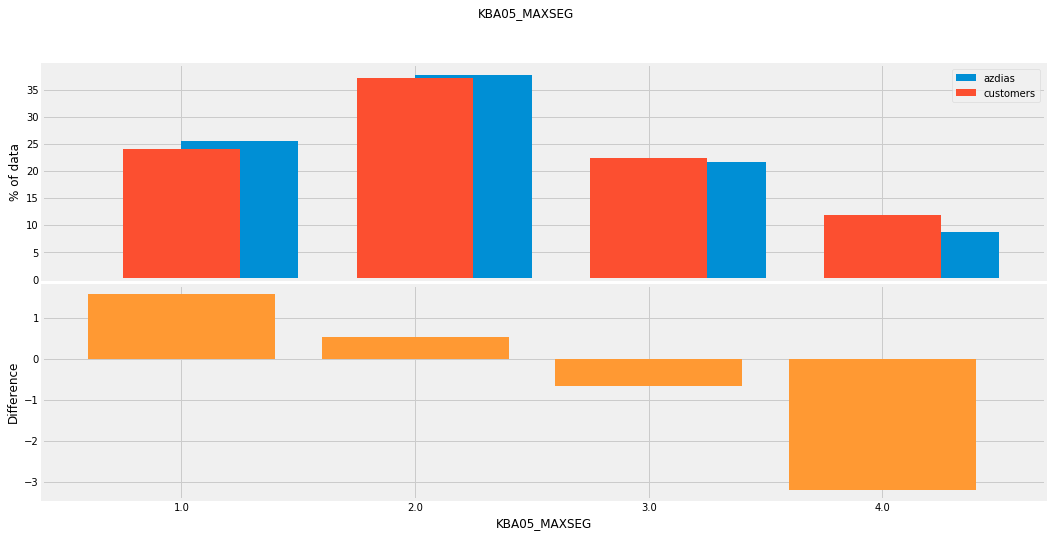

In [229]:
attribute_name = "KBA05_MAXSEG"
get_description(df_attr_p, attribute_name)
plot_attribute(azdias_9, customers_9, attribute_name)
get_meanings(df_attr_p, attribute_name)

From previous model.

#### 1.4.4 Analyze clusters

Customer's data set has over-representation of clusters 2 and 4, while under-representation  comes from clusters 0 and 10.

#### Cluster 2

This cluster indicates that customers of a mail-order sales company in Germany have:

* `KBA05_HERST1` larger share of top German manufactured cars,
* `KBA05_KW3` share of cars with 119 KW power,
* `KBA13_HERST_BMW_BENZ` share of BMW & Mercedes Benz within the PLZ8,
* `KBA05_MOTOR` customers have cars with average or large engines,
* `KBA05_MAXSEG` have more upper class cars,
* `KBA05_KRSHERST1` have above average share of Mercedes/BMW,
* `KBA13_ALTERHALTER_61` high share of old car owners,
* `KBA13_SEG_OBEREMITTELKLASSE` high share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.),
* `GREEN_AVANTGARDE` many more customers belong to the green avantgarde,
* `PRAEGENDE_JUGENDJAHRE_movement` custoemrs are mostly have avantgarde movement.

In [209]:
# inverse transform Kmean centers
centers = pca_a.inverse_transform(kmeans.cluster_centers_)

# most overrepresented feature in customer data set is Clester #2
df_temp = pd.DataFrame(centers[2,:])
df_temp.columns= ["Weight"]
df_temp["Column_name"] = azdias_ss.columns.values
df_temp = df_temp.nlargest(10, 'Weight')
df_temp

,Weight,Column_name
828,2.039811,CAMEO_DEUINTL_2015_wealth_1.0
294,1.543792,CAMEO_DEUG_2015_2
832,1.156239,CAMEO_DEUINTL_2015_wealth_5.0
39,1.138363,D19_BANKEN_ANZ_12
235,1.092289,D19_VERSAND_DATUM_4
21,1.087894,D19_GESAMT_ANZ_12
706,1.078127,D19_VERSAND_ONLINE_DATUM_4
534,1.076205,CAMEO_DEU_2015_2D
0,1.069444,ANZ_HAUSHALTE_AKTIV
245,1.063718,D19_GESAMT_ONLINE_DATUM_4


In [210]:
for _ in df_temp.values:
    get_description(df_attr_p, _[1])

# print not found columns
get_description(df_attr_p, "PRAEGENDE_JUGENDJAHRE")

CAMEO_DEUINTL_2015_wealth_1.0 : not found
CAMEO_DEUG_2015_2             : not found
CAMEO_DEUINTL_2015_wealth_5.0 : not found
D19_BANKEN_ANZ_12             : transaction activity BANKS in the last 12 months
D19_VERSAND_DATUM_4           : not found
D19_GESAMT_ANZ_12             : transaction activity TOTAL POOL in the last 12 months 
D19_VERSAND_ONLINE_DATUM_4    : not found
CAMEO_DEU_2015_2D             : not found
ANZ_HAUSHALTE_AKTIV           : number of households in the building
D19_GESAMT_ONLINE_DATUM_4     : not found
PRAEGENDE_JUGENDJAHRE         : dominating movement in the person's youth (avantgarde or mainstream)


PRAEGENDE_JUGENDJAHRE_movement: not found
PRAEGENDE_JUGENDJAHRE_movement: attribute not found


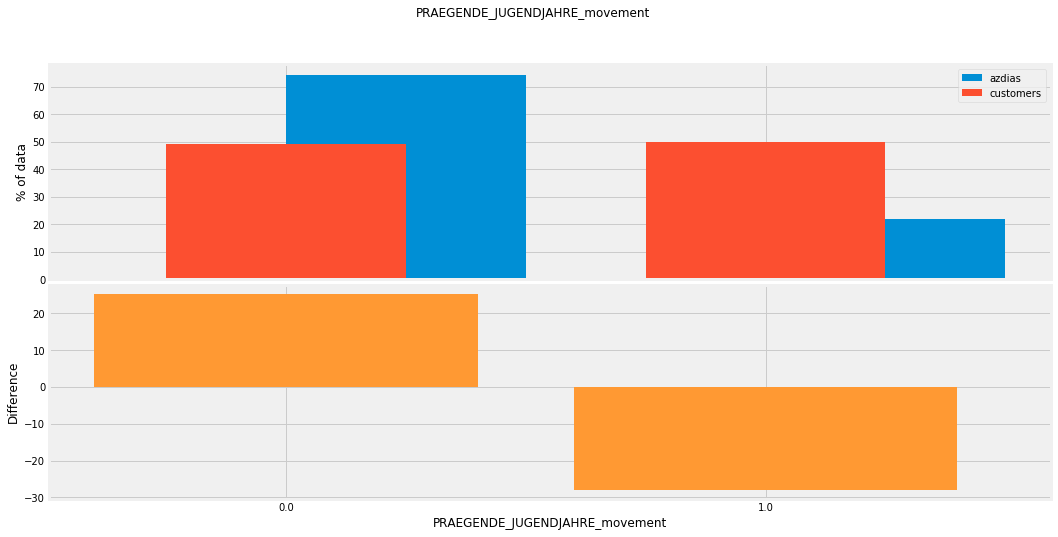

In [211]:
attribute_name = "PRAEGENDE_JUGENDJAHRE_movement"
get_description(df_attr_p, attribute_name)
plot_attribute(azdias_9, customers_9, attribute_name)
get_meanings(df_attr_p, attribute_name)

#### Cluster 4

This cluster indicates that customers of a mail-order sales company in Germany have:

* `MOBI_REGIO` shows that customers are much lower mobility as compared to general population,
* `KBA13_AUTOQUOTE` shows that custoemrs have above average share of cars within the PLZ8,
* `PLZ8_GBZ` customers life in more dense areas (number of buildings within the PLZ8 >300 buildings),
* `KBA05_GBZ` same as above, more buildings in micro cell,
* `PLZ8_BAUMAX_size_1-2` customers have more 1-2 family homes,
* `FINANZTYP_2` many more customers have "money saver" attitude tawrds finance.,
* `FINANZ_VORSORGER` have very low finiancial preparation,
* `KBA05_AUTOQUOT` have high/very high share of cars per household,
* `FINANZ_MINIMALIST` are not finiancial minimalists,
* `KBA13_ALTERHALTER_60` have larger share of older (between 46 and 60) share of car owners within the PLZ8.

In [212]:
# most overrepresented feature in customer data set is Clester #4
df_temp = pd.DataFrame(centers[4,:])
df_temp.columns= ["Weight"]
df_temp["Column_name"] = azdias_ss.columns.values
df_temp = df_temp.nlargest(10, 'Weight')
df_temp

,Weight,Column_name
77,0.871153,KBA13_KMH_180
146,0.836204,KBA13_ALTERHALTER_60
210,0.799534,KBA13_KW_0_60
81,0.777014,KBA13_HERST_FORD_OPEL
85,0.773161,KBA13_HALTER_55
160,0.769238,KBA13_KMH_140_210
132,0.748862,KBA13_SEG_KLEINWAGEN
60,0.731816,KBA13_HALTER_50
201,0.708906,KBA13_SEG_KLEINST
51,0.649093,KBA13_AUTOQUOTE


In [213]:
for _ in df_temp.values:
    get_description(df_attr, _[1])

# print "not found" columns
get_description(df_attr, "PLZ8_BAUMAX")
get_description(df_attr, "FINANZTYP")

KBA13_KMH_180                 : share of cars with max speed between 110 km/h and 180km/h within the PLZ8
KBA13_ALTERHALTER_60          : share of car owners between 46 and 60 within the PLZ8
KBA13_KW_0_60                 : share of cars up to 60 KW engine power - PLZ8
KBA13_HERST_FORD_OPEL         : share of Ford & Opel/Vauxhall within the PLZ8
KBA13_HALTER_55               : share of car owners between 51 and 55 within the PLZ8
KBA13_KMH_140_210             : share of cars with max speed between 140 and 210 km/h within the PLZ8
KBA13_SEG_KLEINWAGEN          : share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8
KBA13_HALTER_50               : share of car owners between 46 and 50 within the PLZ8
KBA13_SEG_KLEINST             : share of very small cars (Ford Ka etc.) in the PLZ8
KBA13_AUTOQUOTE               : share of cars per household within the PLZ8
PLZ8_BAUMAX                   : most common building-type within the PLZ8
FINANZTYP                     : best 

KBA13_ALTERHALTER_60          : share of car owners between 46 and 60 within the PLZ8
KBA13_ALTERHALTER_60     : ['unknown', 'none', 'very low', 'low', 'average', 'high', 'very high']
_________________________: [-1, 0, 1, 2, 3, 4, 5]


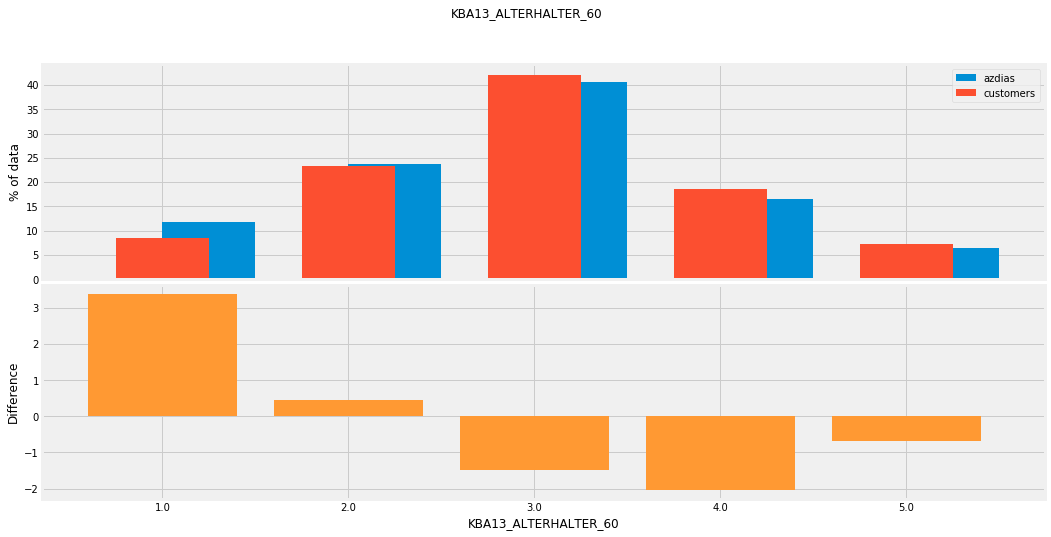

In [214]:
attribute_name = "KBA13_ALTERHALTER_60"
get_description(df_attr_p, attribute_name)
plot_attribute(azdias_7, customers_7, attribute_name)
get_meanings(df_attr_p, attribute_name)

#### Cluster 10

This cluster indicates that customers of a mail-order sales company in Germany:

* `PRAEGENDE_JUGENDJAHRE_movement` less customers have mainstream movement,
* `GREEN_AVANTGARDE` this cluster doesn't belong to the green avantgarde,
* `ONLINE_AFFINITAET` this cluster has lower online affinity,
* `LP_LEBENSPHASE_FEIN_income_high` this cluster have lower share of high income people,
* `D19_GESAMT_ANZ_24` this cluster indicates that transaction activity TOTAL POOL in the last 24 months is known,
* `LP_STATUS_FEIN_10.0` many more custostomers are top earners,
* `D19_BANKEN_ANZ_24` this cluster indicates that transaction activity BANKS in the last 24 months is known,
* `KBA13_VORB_0` customers have above average share of cars with no preowner - PLZ8,
* `D19_VERSAND_ANZ_24` this cluster indicates that transaction activity MAIL-ORDER in the last 24 months,
* `MOBI_REGIO` customers have lower mobility,

In [215]:
# most under-reperesented feature in customer data set is Clester #10
df_temp = pd.DataFrame(centers[10,:])
df_temp.columns= ["Weight"]
df_temp["Column_name"] = azdias_ss.columns.values
df_temp = df_temp.nlargest(10, 'Weight')
df_temp

,Weight,Column_name
233,2.852723,D19_VERSAND_DATUM_2
594,2.754459,D19_GESAMT_DATUM_2
243,2.648892,D19_GESAMT_ONLINE_DATUM_2
704,2.616278,D19_VERSAND_ONLINE_DATUM_2
812,1.306640,D19_GESAMT_OFFLINE_DATUM_2
21,1.264540,D19_GESAMT_ANZ_12
271,1.185206,D19_VERSAND_OFFLINE_DATUM_2
190,1.103430,D19_VERSAND_ANZ_12
82,1.029184,D19_GESAMT_ANZ_24
71,0.921586,D19_VERSAND_ANZ_24


In [216]:
for _ in df_temp.values:
    get_description(df_attr, _[1])

# print "not found" columns
get_description(df_attr, "PRAEGENDE_JUGENDJAHRE")
get_description(df_attr, "LP_STATUS_FEIN")

D19_VERSAND_DATUM_2           : not found
D19_GESAMT_DATUM_2            : not found
D19_GESAMT_ONLINE_DATUM_2     : not found
D19_VERSAND_ONLINE_DATUM_2    : not found
D19_GESAMT_OFFLINE_DATUM_2    : not found
D19_GESAMT_ANZ_12             : transaction activity TOTAL POOL in the last 12 months 
D19_VERSAND_OFFLINE_DATUM_2   : not found
D19_VERSAND_ANZ_12            : transaction activity MAIL-ORDER in the last 12 months
D19_GESAMT_ANZ_24             : transaction activity TOTAL POOL in the last 24 months 
D19_VERSAND_ANZ_24            : transaction activity MAIL-ORDER in the last 24 months
PRAEGENDE_JUGENDJAHRE         : dominating movement in the person's youth (avantgarde or mainstream)
LP_STATUS_FEIN                : social status fine


MOBI_REGIO                    : moving patterns
MOBI_REGIO               : ['very high mobility', 'high mobility', 'middle mobility', 'low mobility', 'very low mobility ', 'none']
_________________________: [1, 2, 3, 4, 5, 6]


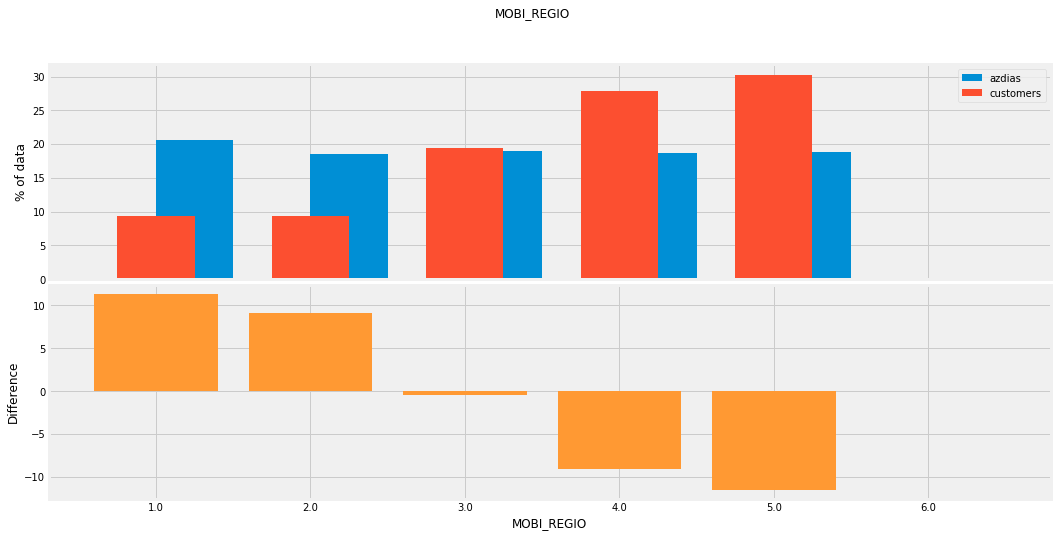

In [217]:
attribute_name = "MOBI_REGIO"
get_description(df_attr_p, attribute_name)
plot_attribute(azdias_9, customers_9, attribute_name)
get_meanings(df_attr_p, attribute_name)

#### Cluster 0

This cluster indicates that customers of a mail-order sales company in Germany:

* This cluster indicates that many more customer's last transaction was withnin last year `D19_VERSAND_DATUM_6`, `D19_GESAMT_ONLINE_DATUM_6` and ect.,
* this cluster indicates that at this life stage unit is family.

In [218]:
# most overrepresented feature in customer data set is Clester #0
df_temp = pd.DataFrame(centers[0,:])
df_temp.columns= ["Weight"]
df_temp["Column_name"] = azdias_ss.columns.values
df_temp = df_temp.nlargest(10, 'Weight')
df_temp

,Weight,Column_name
27,0.956284,MOBI_REGIO
863,0.891295,PLZ8_BAUMAX_size_1-2
31,0.820139,PLZ8_ANTG1
196,0.806612,KBA05_GBZ
148,0.797066,KBA13_SEG_VAN
49,0.757267,KBA05_AUTOQUOT
204,0.731882,KBA13_SEG_GROSSRAUMVANS
51,0.719200,KBA13_AUTOQUOTE
53,0.710219,KBA13_SEG_MINIVANS
162,0.698830,FINANZ_MINIMALIST


In [219]:
for _ in df_temp.values:
    get_description(df_attr, _[1])

# print "not found" columns
get_description(df_attr, "D19_VERSAND_DATUM")
get_description(df_attr, "D19_GESAMT_ONLINE_DATUM")
get_description(df_attr, "D19_VERSAND_ONLINE_DATUM")
get_description(df_attr, "LP_LEBENSPHASE_FEIN")
get_description(df_attr, "D19_TELKO_DATUM")
get_description(df_attr, "D19_TELKO_OFFLINE_DATUM")
get_description(df_attr, "D19_TELKO_ANZ_24")

MOBI_REGIO                    : moving patterns
PLZ8_BAUMAX_size_1-2          : not found
PLZ8_ANTG1                    : number of 1-2 family houses in the PLZ8
KBA05_GBZ                     : number of buildings in the microcell
KBA13_SEG_VAN                 : share of vans within the PLZ8
KBA05_AUTOQUOT                : share of cars per household
KBA13_SEG_GROSSRAUMVANS       : share of big sized vans within the PLZ8
KBA13_AUTOQUOTE               : share of cars per household within the PLZ8
KBA13_SEG_MINIVANS            : share of minivans within the PLZ8
FINANZ_MINIMALIST             : financial typology: low financial interest
D19_VERSAND_DATUM             : actuality of the last transaction for the segment mail-order TOTAL
D19_GESAMT_ONLINE_DATUM       : actuality of the last transaction with the complete file ONLINE
D19_VERSAND_ONLINE_DATUM      : actuality of the last transaction for the segment mail-order ONLINE
LP_LEBENSPHASE_FEIN           : lifestage fine 
D19_TELKO_DATUM

LP_LEBENSPHASE_FEIN_type_family: not found
LP_LEBENSPHASE_FEIN_type_family: attribute not found


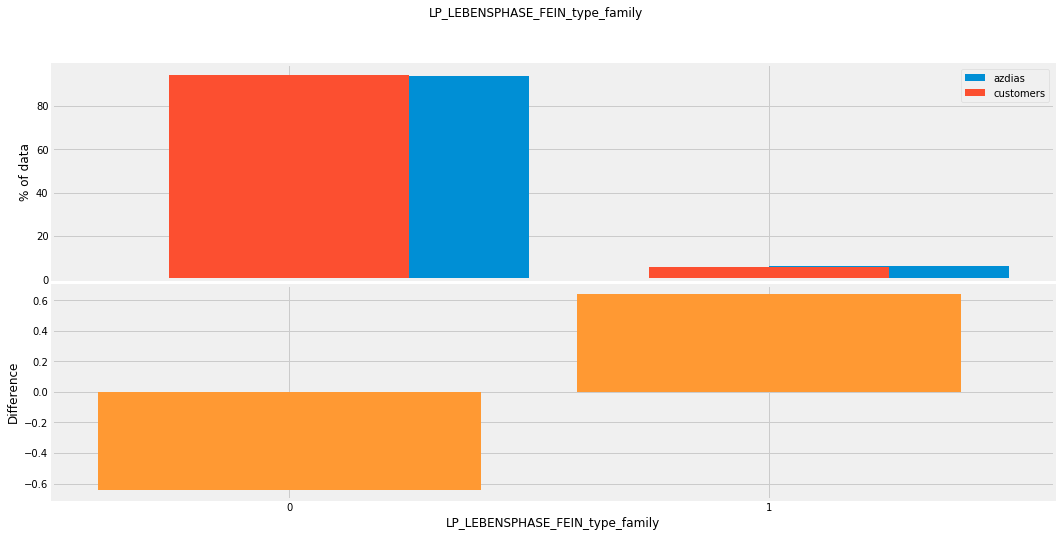

In [220]:
attribute_name = "LP_LEBENSPHASE_FEIN_type_family"
get_description(df_attr_p, attribute_name)
plot_attribute(azdias_9, customers_9, attribute_name)
get_meanings(df_attr_p, attribute_name)

### 1.5 Investigate customer types

There are 3 additional clumns in `customers` DataFrame which 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'

In [205]:
# create new DataFrame for 3 extra columns
customers_special = customers_1[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]
customers_special.head()

,CUSTOMER_GROUP,ONLINE_PURCHASE,PRODUCT_GROUP
0,MULTI_BUYER,0,COSMETIC_AND_FOOD
1,SINGLE_BUYER,0,FOOD
2,MULTI_BUYER,0,COSMETIC_AND_FOOD
3,MULTI_BUYER,0,COSMETIC
4,MULTI_BUYER,0,FOOD


#### 1.5.1 CUSTOMER_GROUP

This is categorical column indicating whatever custoemr is single or multi buyer.

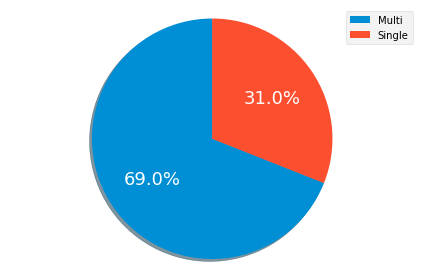

In [206]:
# calculate procentages for single and multibuyers
_ = customers_special['CUSTOMER_GROUP'].value_counts() / customers_special['CUSTOMER_GROUP'].size * 100

patches, texts, autotexts = plt.pie(_.values, shadow=True, autopct='%1.1f%%', startangle=90)
for autotext in autotexts:
    autotext.set_color('w')
    autotext.set_fontsize(18)
    
# plt.title("Customer type")
plt.legend(patches, ["Multi", "Single"], loc="best")
plt.axis('equal')
plt.tight_layout()
plt.savefig("customers_type.png", facecolor='w', dpi=96)

#### 1.5.2 ONLINE_PURCHASE

1 should indicate that customer made an online purchase. Not suprisingly, majority of users order mails not online. 

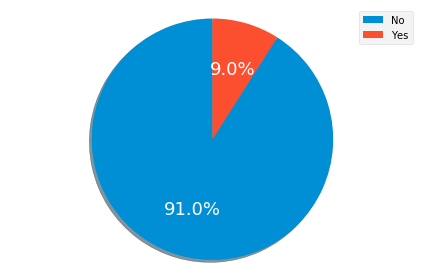

In [207]:
# calculate procentages for single and multibuyers
_ = customers_special['ONLINE_PURCHASE'].value_counts() / customers_special['ONLINE_PURCHASE'].size * 100

# fig = plt.figure()
# fig.patch.set_facecolor('r')

patches, texts, autotexts = plt.pie(_.values, shadow=True, autopct='%1.1f%%', startangle=90)
for autotext in autotexts:
    autotext.set_color('w')
    autotext.set_fontsize(18)
    
# plt.title("Made online purchase")
plt.legend(patches, ["No", "Yes"], loc="best")
plt.axis('equal')
plt.tight_layout()
plt.savefig("customers_online_p.png", facecolor='w', dpi=96)

#### 1.5.3 PRODUCT_GROUP

Custoemers can order "food", "cosmetics" or both type mails.

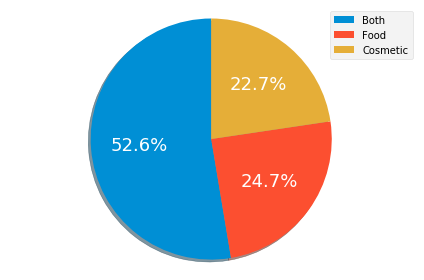

In [208]:
# calculate procentages for single and multibuyers
_ = customers_special['PRODUCT_GROUP'].value_counts() / customers_special['PRODUCT_GROUP'].size * 100

patches, texts, autotexts = plt.pie(_.values, shadow=True, autopct='%1.1f%%', startangle=90)
for autotext in autotexts:
    autotext.set_color('w')
    autotext.set_fontsize(18)
    
# plt.title("Product group")
plt.legend(patches, ["Both", "Food", "Cosmetic"], loc="best")
plt.axis('equal')
plt.tight_layout()
plt.savefig("customers_product_group.png", facecolor='w', dpi=96)

Split between different segments.

In [215]:
customers_special['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [221]:
_ = pd.DataFrame({'count' : customers_special.groupby('CUSTOMER_GROUP')['PRODUCT_GROUP'].value_counts()}).reset_index()
_

,CUSTOMER_GROUP,PRODUCT_GROUP,count
0,MULTI_BUYER,COSMETIC_AND_FOOD,100860
1,MULTI_BUYER,COSMETIC,19088
2,MULTI_BUYER,FOOD,12290
3,SINGLE_BUYER,FOOD,35092
4,SINGLE_BUYER,COSMETIC,24322


In [244]:
# separate DataFrames according to customer type
multi_df = _[_.CUSTOMER_GROUP=="MULTI_BUYER"].copy()
single_df = _[_.CUSTOMER_GROUP=="SINGLE_BUYER"].copy()
# calculate procentages
multi_df['count'] = multi_df['count']/132238 * 100
single_df['count'] = single_df['count']/59414 * 100
# reindex to match row order
multi_df = multi_df.reindex([2, 1, 0])

In [245]:
single_df

,CUSTOMER_GROUP,PRODUCT_GROUP,count
3,SINGLE_BUYER,FOOD,59.06352
4,SINGLE_BUYER,COSMETIC,40.93648


In [246]:
multi_df

,CUSTOMER_GROUP,PRODUCT_GROUP,count
2,MULTI_BUYER,FOOD,9.293849
1,MULTI_BUYER,COSMETIC,14.434580
0,MULTI_BUYER,COSMETIC_AND_FOOD,76.271571


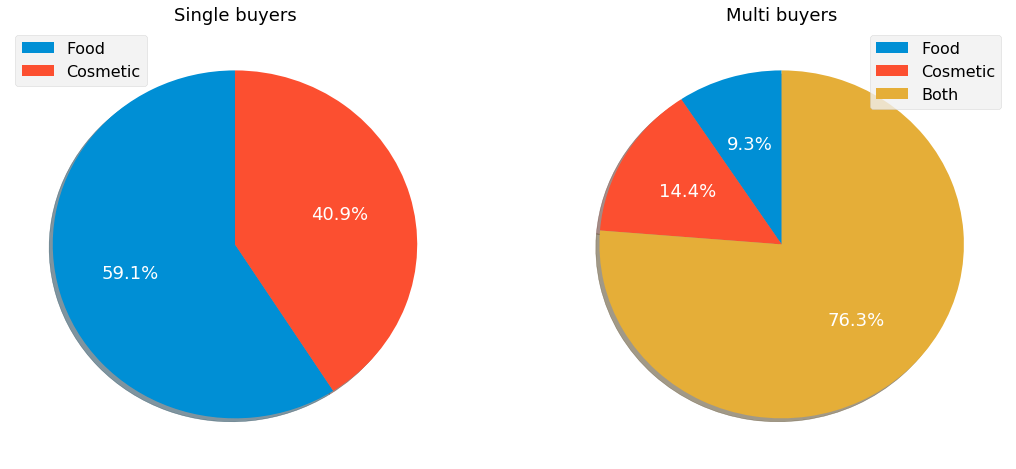

In [259]:
# create figure and axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey='row')
# figure title
# fig.suptitle(attribute_name)

# single buyers
patches, texts, autotexts = ax1.pie(single_df['count'].values, shadow=True, autopct='%1.1f%%', startangle=90)
for autotext in autotexts:
    autotext.set_color('w')
    autotext.set_fontsize(18)

# add legend
ax1.legend(patches, ["Food", "Cosmetic"], loc="best", fontsize=16)
ax1.set_title('Single buyers', fontsize=18)    
    
# multi buyers
patches, texts, autotexts = ax2.pie(multi_df['count'].values, shadow=True, autopct='%1.1f%%', startangle=90)
for autotext in autotexts:
    autotext.set_color('w')
    autotext.set_fontsize(18)
    
# add legend
ax2.legend(patches, ["Food", "Cosmetic", "Both"], loc="best", fontsize=16)
ax2.set_title('Multi buyers', fontsize=18);

plt.savefig("customers_product_groupby_type.png", facecolor='w', dpi=96)

## Part 1: Comments about data processing

### Visual and numeric analysis

* By visualizing (ploting distributions) mixed-type features, it was revealed that `customers` dataset contains more wealthy and earderly people as compared to general German population.

### PCA

#### Feature scalling

* For `azdias` DataFrame missing values in `ANZ_HH_TITEL`, `KBA05_SEG6` and `PLZ8_BAUMAX_cell_type` columns were replaced with zeros. For column `KBA13_ANZAHL_PKW` missing values were imputed with mean value. For remaining columns `VERS_TYP`, `PRAEGENDE_JUGENDJAHRE_movement` and `WOHNLAGE_score_rular`. 7.1% of data was droped after this step.
* Same procedure was applied for `customers` DataFrame for handling missing values. Only 3.92% of data was droped due to NAN values.

#### Dimensionality Reduction

* Dimensionality was reduced by 55% which allowed retaining ~>80% of variance,
* Top 3 components for both DataFrames were:
    * Afinity towards online shoping and mail ordering,
    * Cars people have,
    * Size of the family.

## Part 1: Final customer segmentation report

This one is written is separate `Customer_segmentation_report.ipynb` document.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 2.1 Extract

Extract and process data.

In [ ]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)
del mailout_train['Unnamed: 0']
mailout_train.head()

### 2.2 Transform

### 2.3 Process

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
mailout_test.to_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')